In [3]:
import numpy as np
import time
import os, zipfile, shutil,gzip
import pandas as pd
import glob
from scipy.stats import linregress
import requests
import os
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings
import math
import scipy
from numpy import polyfit, poly1d
from scipy import interpolate
import matplotlib as mpl
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from sklearn.preprocessing import PolynomialFeatures
from collections import Counter
import collections
import Hawkes as hk
from sklearn.linear_model import LinearRegression 
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import joblib
import statistics
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# DL预测
## Data

In [4]:
path = f'C:/Users/杜威/Desktop/tardis/Pred/baseline/'

In [3]:
#获取kraken的日k线
def get_kk_data(coin, days):
    f = lambda x: datetime.fromtimestamp(x)
    current_date = datetime.now().date()
    current_datetime = datetime.combine(current_date, datetime.min.time())
    timestamp = int(datetime.timestamp(current_datetime))
    since_time = timestamp - 1440 * 60 * days
    resp = requests.get(f'https://api.kraken.com/0/public/OHLC?pair={coin}&interval=1440&since={since_time}')
    name = list(resp.json()['result'].keys())[0]
    df = resp.json()['result'][name]
    df = pd.DataFrame(df, columns = ['time', 'O', 'H', 'L', 'C', 'price', 'amount', 'num']).astype(float)
    df['time_D'] = df['time'].map(f)
    df['value'] = df['price'] * df['amount']
    df = df[['time_D', 'price', 'value']].iloc[:-1,:]
    return df

#获取日均fp
def get_fp_map(days):
    fp_coin_ls = ['EUR', 'GBP', 'CAD', 'CHF', 'AUD', 'PAXG', 'USDT', 'DAI', 'USDC',
              'BTC', 'ETH', 'ADA', 'SOL', 'MATIC', 'DOT', 'DOGE', 'LINK', 'LTC', 'XRP']
    fp_map = {}
    for fp_coin in fp_coin_ls:
        if fp_coin not in ['CHF', 'CAD']:
            coin = fp_coin + 'USD'
            fp = get_kk_data(coin, days)[['time_D', 'price']]
        else:
            coin = 'USD' + fp_coin
            fp = get_kk_data(coin, days)[['time_D', 'price']]
            fp['price'] = 1 / fp['price']
        fp_map[fp_coin] = fp
    return fp_map

#转变为美元价值
def get_dv(df, fp_coin):
    if fp_coin == 'USD':
        return df[['time_D', 'value', 'time']]
    fp = fp_map[fp_coin]
    df = pd.merge(df, fp, on = 'time_D', how = 'left').dropna()
    df['value'] = df['value'] * df['price']
    return df[['time_D', 'value', 'time']]

In [4]:
#清洗s_data数据为美元价值和回归形态
def turn_dv(file):
    if file in os.listdir(path + f's_data'):
        df = pd.read_csv(path + f's_data/{file}')
        df['time_D'] = df['time_D'].astype('datetime64[s]')
        return df
    df = pd.read_csv(f'Y:/Trade Pro/data_wei/Prob_Pred/baseline/s_data/{file}', usecols = ['time', 'sum'])
    df.rename(columns = {'sum':'value'}, inplace = True)
    #时间为中央时区
    df['time'] = df['time'].astype('datetime64[ms]') - timedelta(hours = 8)
    #结合fp的时间为+8时区
    df['time_D'] = df['time'].dt.floor('D') + timedelta(hours = 8)
    fp_coin = file.split('_')[0].split('-')[1].replace('XBT', 'BTC').replace('XDG', 'DOGE')
    df = get_dv(df, fp_coin)
    df.to_csv(f'{path}s_data/{file}')
    return df

#平均发生次数法
def clean_data(delay, file, begin, end, A):
    df = turn_dv(file)
    df = df[df['value'] > A]
    df['c'] = 1
    df = df.groupby('time_D', as_index = False).sum()
    df['T'] = df['time_D'].dt.dayofweek
    df['log c'] = np.log10(df['c'])
    df.rename(columns = {'value':'v'}, inplace = True)
    for i in range(delay):
        df[f'v{i+1}'] = df['v'].shift(i+1)
        df[f'c{i+1}'] = df['log c'].shift(i+1)
    df = df.dropna()
    df = df[(df['time_D'] >= begin) & (df['time_D'] <= end)]
    df['coin'] = coin_map[file]
    return df

#发生时间间隔法
def clean_data_way_2(delay, file, begin, end, A):
    df = turn_dv(file)
    df = df[(df['time_D'] >= begin) & (df['time_D'] <= end)]
    df['time'] = pd.to_datetime(df['time']).astype('datetime64[s]')
    df = df[['time', 'value']].groupby('time', as_index = False).sum()
    df = df[df['value'] > A]
    df = df[-10000:]
    df['t_diff'] = df['time'].diff().map(lambda x:x.total_seconds())
    df['day'] = df['time'].dt.dayofweek
    df['hour'] = df['time'].dt.hour
    df.rename(columns = {'value':'v'}, inplace = True)
    df['t'] = np.log10(df['t_diff'])
    for i in range(delay):
        df[f'v{i+1}'] = df['v'].shift(i+1)
        df[f't{i+1}'] = df['t'].shift(i+1)
    df = df.dropna()
    df['coin'] = coin_map[file]
    return df

def get_train(delay, begin, end, A):
    dt = []
    file_ls = os.listdir(f'Y:/Trade Pro/data_wei/Prob_Pred/baseline/s_data')
    for file in tqdm(file_ls):
        df = clean_data_way_2(delay, file, begin, end, A)
        dt.append(df)
    dt = pd.concat(dt)
    dt.to_csv(f'{path}train/train_gap_mini_{A}.csv')

In [9]:
fp_map = get_fp_map(720)

In [5]:
fp_coin_ls = ['EUR', 'GBP', 'CAD', 'CHF', 'AUD', 'PAXG', 'USDT', 'DAI', 'USDC',
              'BTC', 'ETH', 'ADA', 'SOL', 'MATIC', 'DOT', 'DOGE', 'LINK', 'LTC', 'XRP']
fp_map = {}
for fp_coin in fp_coin_ls:
    fp = pd.read_csv(f'{path}fp_map/{fp_coin}.csv')
    fp['time_D'] = fp['time_D'].astype('datetime64[s]')
    fp_map[fp_coin] = fp
    
coin_map = {}
k = 0
for file in os.listdir(f'{path}s_data'):
    coin_map[file] = k
    k += 1

In [6]:
begin = '2021-08-11'
end1 = '2023-09-01'
end = '2023-10-24'
num = 60
A = 10000

In [ ]:
A_ls = []

In [49]:
get_train(num, begin, end1, A)

100%|████████████████████████████████████████████████████████████████████████████████| 136/136 [04:57<00:00,  2.19s/it]


## 导入数据，训练模型

In [5]:
train = pd.read_csv(f'{path}train/train_10000.csv')

In [6]:
train.head(5)

Unnamed: 0.1               time_D  Unnamed: 0             v   c  T  \
0            14  2021-12-10 08:00:00   135468914  1.870297e+06  67  4   
1            15  2021-12-11 08:00:00   200512622  4.076045e+06  99  5   
2            16  2021-12-12 08:00:00    91238324  1.358554e+06  45  6   
3            17  2021-12-13 08:00:00   152261628  2.503421e+06  75  0   
4            18  2021-12-14 08:00:00   158635703  2.056600e+06  78  1   

      log c            v1        c1            v2  ...       c10  \
0  1.826075  2.104400e+06  1.913814  1.508132e+06  ...  1.732394   
1  1.995635  1.870297e+06  1.826075  2.104400e+06  ...  1.763428   
2  1.653213  4.076045e+06  1.995635  1.870297e+06  ...  2.389166   
3  1.875061  1.358554e+06  1.653213  4.076045e+06  ...  1.968483   
4  1.892095  2.503421e+06  1.875061  1.358554e+06  ...  2.705008   

            v11       c11           v12       c12           v13       c13  \
0  2.607621e+06  1.903090  5.520093e+06  2.222716  2.054703e+06  1.748188   
1  1.296898e+06  1.732394  2.607621e+06  1.903090  5.520093e+06  2.222716   
2  1.627814e+06  1.763428  1.296898e+06  1.732394  2.607621e+06  1.903090   
3  8.331411e+06  2.389166  1.627814e+06  1.763428  1.296898e+06  1.732394   
4  3.120724e+06  1.968483  8.331411e+06  2.389166  1.627814e+06  1.763428   

            v14       c14  coin  
0  6.362220e+06  2.357935     0  
1  2.054703e+06  1.748188     0  
2  5.520093e+06  2.222716     0  
3  2.607621e+06  1.903090     0  
4  1.296898e+06  1.732394     0  

[5 rows x 36 columns]

In [8]:
def get_x(num):
    x = ['day', 'hour', 'coin']
    for i in range(num):
        x.append(f'v{i+1}')
        x.append(f't{i+1}')
    return x

def get_model(y, num):
    x = get_x(num)
    Y = [y]
    other_params = { 'max_depth': 10, 'min_child_weight': 3, 'seed': 0,
                       'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 2, 'reg_alpha': 0, 'reg_lambda': 1}
    LR = XGBRegressor( n_estimators=500,learning_rate=0.02,**other_params)
    LR = LinearRegression()
    LR.fit(train[x], train[Y])
    joblib.dump(LR, f'C:/Users/杜威/Desktop/tardis/Pred/model/Line_{y}_{num}_{A}.dat')

In [9]:
y = 't'
num = 5
x = get_x(num)

In [112]:
get_model(y, num)

In [10]:
LR = joblib.load(f'C:/Users/杜威/Desktop/tardis/Pred/model/XGB_{y}_{num}_{A}.dat', mmap_mode=None)

In [25]:
def test_pred(file, num, y, A):
    test = clean_data_way_2(num, file, end1, end, A)
    test = test[-100:].reset_index()
    y_prediction = LR.predict(test[x])
    plt.figure(figsize = (15,8))
    plt.scatter(test.index, 10**y_prediction, label = 'pred', color = 'red')
    plt.plot(test.index, test[y], label = 'real',color = 'green')
    plt.xlabel('sequence')
    plt.ylabel('time gap')
    plt.title(file)
    add_compara(test, y)
    plt.legend()
    return
    plt.savefig(f'C:/Users/杜威/Desktop/tardis/kraken/pred_test/{file[:-3]}.jpg')
    
def add_compara(test, y):
    real_line = test[y].mean()
    plt.plot(test.index, [real_line] * len(test), color = 'black', label = 'mean_baseline')
    test['possion'] = test[['t1', 't2', 't3', 't4', 't5']].apply(lambda x: statistics.harmonic_mean(x), axis = 1)
    plt.plot(test.index, 10**test['possion'], '--', color = 'red', label = 'possion')

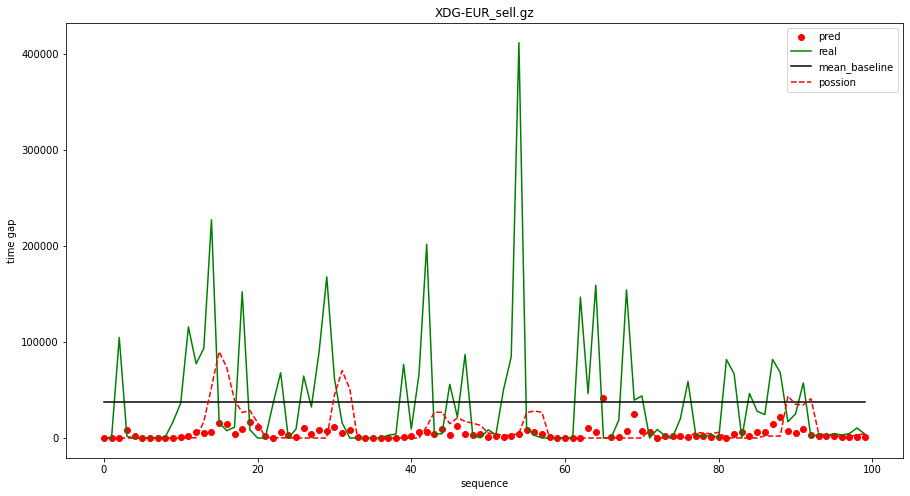

In [27]:
test_pred('XDG-EUR_sell.gz', num, 't_diff', A)

## 获取最新数据，进行预测

In [8]:
MD = {}
for j in [3, 4, 5]:
    MD[j] = joblib.load(f'C:/Users/杜威/Desktop/tardis/Pred/{j}.dat', mmap_mode=None)

In [11]:
#获取预测因子
def get_y(file):
    coin = file.split('_')[0].replace('-', '')
    df = get_kk_data(coin, 14)
    df['value'] = df['value'] / 2
    fp_coin = file.split('_')[0].split('-')[1].replace('XBT', 'BTC').replace('XDG', 'DOGE')
    df = get_dv(df, fp_coin)
    cols = get_x(14)
    x = {}
    x[cols[0]] = [(df['time_D'][13] + timedelta(days = 1)).dayofweek]
    x[cols[1]] = [coin_map[file]]
    for i in range(14):
        x[cols[i+2]] = [df['value'][13-i]]
    x = pd.DataFrame(x)
    ls = []
    for j in [3, 4, 5]:
        ls.append(MD[j].predict(x))
    return ls

def p2d(params, L):
    a = params['a']
    b = params['b']
    x=list(range(1000,L * 100,100))
    y = [max(a * u + b) for u in x]
    dpp = pd.DataFrame()
    dpp['amount'],dpp['prob']=x,y
    dpp['prob']=10**dpp['prob']
    dpp=dpp[['amount','prob']]
    dpp['prob'][len(dpp)-1]=0
    dpp = dpp[dpp['prob'] > 0.01][dpp['prob'] < 10000]
    x,y=dpp['amount'],np.log10(dpp['prob'])
    return x, y

def new_params(params, y):
    y = np.log10(y)
    params = params.sort_values(by = 'a')
    params['a2'] = params['a'].shift(-1)
    params['b2'] = params['b'].shift(-1)
    params['x'] = (params['b2'] - params['b']) / (params['a'] - params['a2'])
    diff = []
    for n in [1000, 10000, 100000]:
        try:
            b = params[params['x'] > n].reset_index()['b'][0] + params[params['x'] > n].reset_index()['a'][0] * n
        except:
            b = params['b'][len(params) - 1] + params['a'][len(params) - 1] * n
        diff.append(b)
    diff = y.reshape(-1) - np.array(diff)
    params['b'] = params.apply(lambda x:x['b'] + diff[0] if x['x'] < 10000 else x['b'] + diff[1] if x['x'] < 100000 else x['b'] + diff[2], axis = 1)
    return params

In [12]:
def final_output(file):    
    params = pd.read_csv(f'Y:/Trade Pro/data_wei/Prob_Pred/baseline/params/{file}')
    sheet = pd.read_csv(f'Y:/Trade Pro/data_wei/Prob_Pred/baseline/proba_sheet/{file}')
    L = len(sheet)
    file2 = file[:-4] + '.gz'
    out_y = get_y(file2)
    params2 = new_params(params, out_y)
    params2[['a', 'b']].to_csv(f'Y:/Trade Pro/data_wei/Prob_Pred/baseline/history/20231116/params/{file}')
    x, y = p2d(params, L)
    x1, y1 = p2d(params2, L)
    plt.figure(figsize=(15, 8))
    plt.title(f'{file}')
    plt.xlabel('amount')
    plt.ylabel('log prob')
    plt.plot(x,y,label='average')
    plt.plot(x1,y1,label='forcast')
    plt.legend()
    plt.grid(axis="y")
    plt.grid(axis="x")
    plt.savefig(f'Y:/Trade Pro/data_wei/Prob_Pred/baseline/history/20231116/plot/{file[:-4]}.jpg')

In [15]:
fp_map = get_fp_map(14)

# 概率表量级对比

In [16]:
def get_value(name, lim):
    new_dic = {}
    for file in os.listdir(f'C:/Users/杜威/Desktop/tardis/kraken/{name}_sheet'):
        df = pd.read_csv(f'C:/Users/杜威/Desktop/tardis/kraken/{name}_sheet/{file}')
        file = file.replace('XDG', 'DOGE').replace('XBT', 'BTC')[:-4]
        T = file.split('_')
        side = T[1]
        coin = T[0].split('-')
        if side == 'buy':
            coin = coin[1]
        else:
            coin = coin[0]
        value = df[df['prob'] > lim]['amount'][-1:].values[0]
        coin = file
        if coin in new_dic.keys():
            new_dic[coin] += value
        else:
            new_dic[coin] = value
    return new_dic

def diff(lim):
    dic = {}
    dic['new'] = get_value('proba', lim)
    dic['old'] = get_value('kraken_old', lim)
    df = pd.DataFrame(dic)
    df = df.iloc[:-1,:].append(pd.DataFrame(df.sum(axis = 0)).rename(columns = {0: 'all'}).T)
    df['diff'] = df['new'] - df['old']
    df['rate'] = df['diff'] / df['old']
    df0 = df.sort_values(by = 'diff', ascending = False)
    return df0

In [17]:
df = diff(0.5)

# 概率表尾部修正

In [19]:
def sum_df(df):
    df.rename(columns = {'sum':'value'}, inplace = True)
    dt=df[:]
    dt['time_D'] = dt['time'].astype('datetime64[D]')
    dt=dt.groupby('time_D', as_index =False)['time_D'].sum()
    n=len(dt)
    df=df[df['value'] >= 1000]
    df['log amount']=np.log10(df['value'])
    other_coin = df.groupby('log amount', as_index =False)['log amount'].agg(['count'])
    other_coin = other_coin.reset_index()
    other_coin1 = other_coin.iloc[1: , :]
    sum_count = other_coin1['count'].sum()
    other_coin1['sum'] = other_coin1['count']
    other_coin1 = other_coin1.reset_index()
    for i in range(1,len(other_coin1['sum'])):
        other_coin1['sum'][i] = other_coin1['sum'][i-1]+other_coin1['sum'][i]
    #other_coin1['sum'][0] = other_coin1['count'][0]
    other_coin1['prob_real'] = (sum_count- other_coin1['sum']+1)/n
    other_coin1['amount'] = 10**other_coin1['log amount']
    other_coin1['log prob'] = np.log10(other_coin1['prob_real'])
    return other_coin1[[ 'amount','log prob']]

def get_lines(x: np.ndarray, y: np.ndarray):
    n = len(x)
    k_lis=[n//i for i in [3,10,20,50,100,200,300,500,750,1000]]
    a_lis=[]
    b_lis=[]
    len_lis=[]
    for k in k_lis:
        try:
            g = [i // (n // k + 1) for i in range(n)]
            history = []
            while True:
                p = [[] for _ in range(k)]
                for i in range(n):
                    p[g[i]].append(i)
                p = [i for i in p if i]
                k = len(p)
                a = []
                b = []
                for i in range(k):
                    if len(p[i]) > 1:
                        res = linregress(x[p[i]], y[p[i]])
                        a.append(res.slope)
                        b.append(res.intercept)
                a = np.array(a)
                b = np.array(b)
                g = [np.argmax(a * x[i] + b) for i in range(n)]
                if g in history:
                    a_lis.append(a)
                    b_lis.append(b)
                    len_lis.append(len(a))
                    break
                history.append(g)
        except:
            continue
    maxx=np.argmax(len_lis)
    return a_lis[maxx],b_lis[maxx]

def get_proba(df):
    df = df[:-2]
    maxp = int(df['amount'].max() / 100)
    dpp=pd.DataFrame(list(range(10,maxp)))
    dpp['amount']=1
    dpp['log prob']=0.1
    df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
    a, b = get_lines(df['amount'], df['log prob'])
    params = pd.DataFrame()
    params['a'] = a
    params['b'] = b
    x=list(range(1000,maxp*100,100))
    y = [max(a * u + b) for u in x]
    return x, y, params

def get_p3(p1, p2, df):
    maxp = int(df['sum'].max() / 100)
    p3 = p1.sort_values('a').reset_index()
    p3.loc[len(p3) - 1: , 'a'] = min(p2['a'].max(), p3['a'].max())
    a = p3['a']
    b = p3['b']
    x=list(range(1000,maxp*100,100))
    y = [max(a * u + b) for u in x]
    return x, y, p3

def rejust(coin1, side):
    coin = coin1.replace('XBT', 'BTC').replace('XDG', 'DOGE')
    df1 = pd.read_csv(f'C:/Users/杜威/Desktop/tardis/kraken/dist/{coin1}_{side}_dist.gz')
    df1 = df1.sort_values('sum')[:-3]
    #df1 = sum_df(df1)
    p1 = pd.read_csv(f'C:/Users/杜威/Desktop/tardis/kraken/params/{coin}_{side}.csv')
    p2 = pd.read_csv(f'C:/Users/杜威/Desktop/tardis/kraken/params_last/{coin}_{side}.csv')
    #p3 = pd.read_csv(f'C:/Users/杜威/Desktop/tardis/kraken/p3/{coin}_{side}.csv')
    x3, y3, p3 = get_p3(p1, p2, df1)
    p3.to_csv(f'C:/Users/杜威/Desktop/tardis/kraken/p3/{coin}_{side}.csv')
    
    x1, y1, p1 = get_p3(p1, p1, df1)
    x2, y2, p2 = get_p3(p2, p2, df1)
    
    plt.figure(figsize = (15, 8))
    #plt.plot(df1['amount'], df1['log prob'], label = '2m')
    #plt.plot(df2['amount'], df2['log prob'], label = '1y')
    plt.plot(x1, y1, label = 'new_L')
    plt.plot(x2, y2, label = 'last_L')
    plt.plot(x3, y3, label = 'final_L')
    plt.legend()
    plt.grid(axis="y")
    plt.grid(axis="x")
    plt.title(f'{coin}_{side}')
    plt.savefig(f'C:/Users/杜威/Desktop/tardis/kraken/p3_plot/{coin}_{side}.jpg')

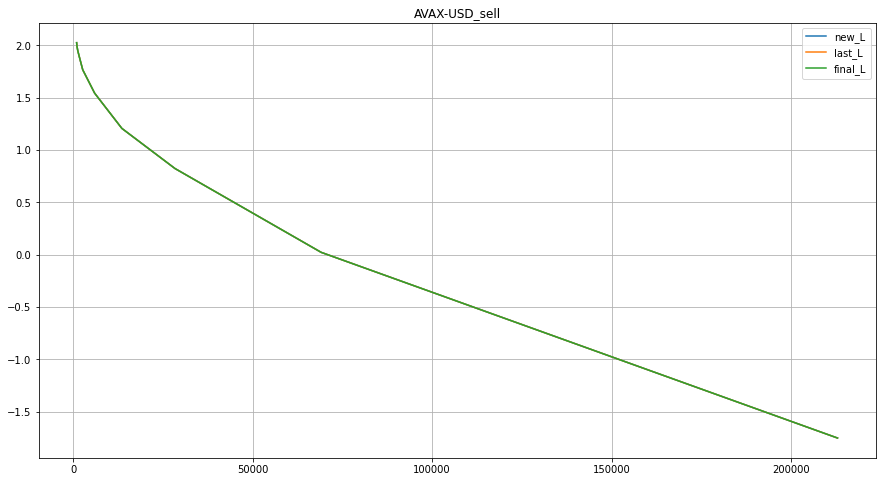

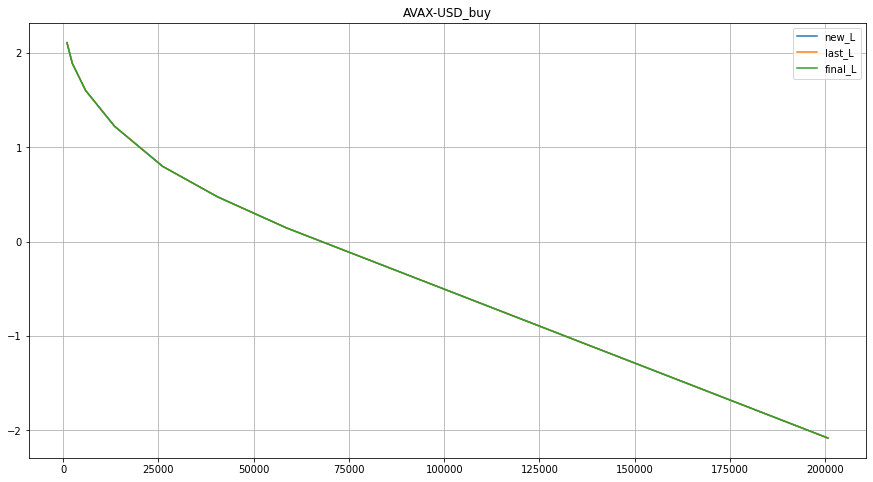

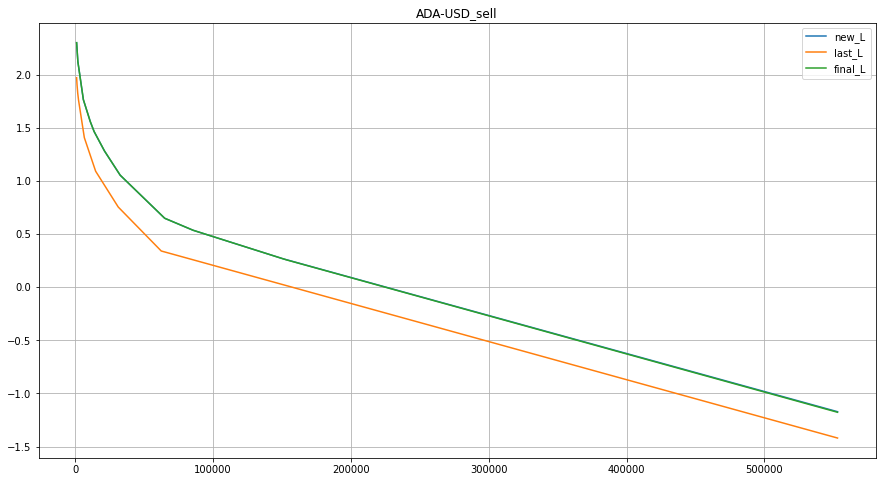

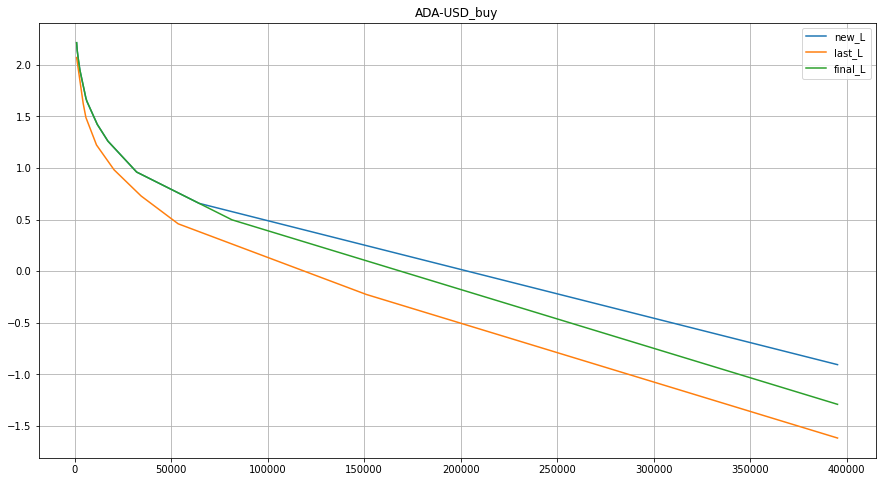

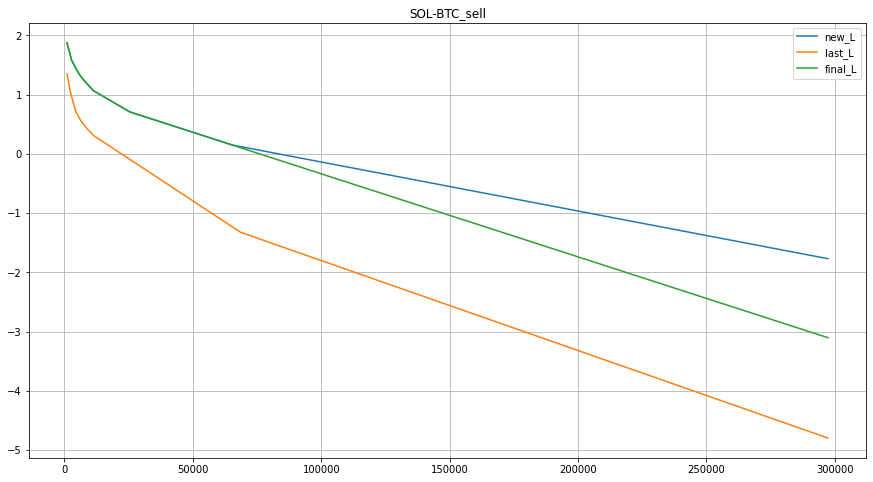

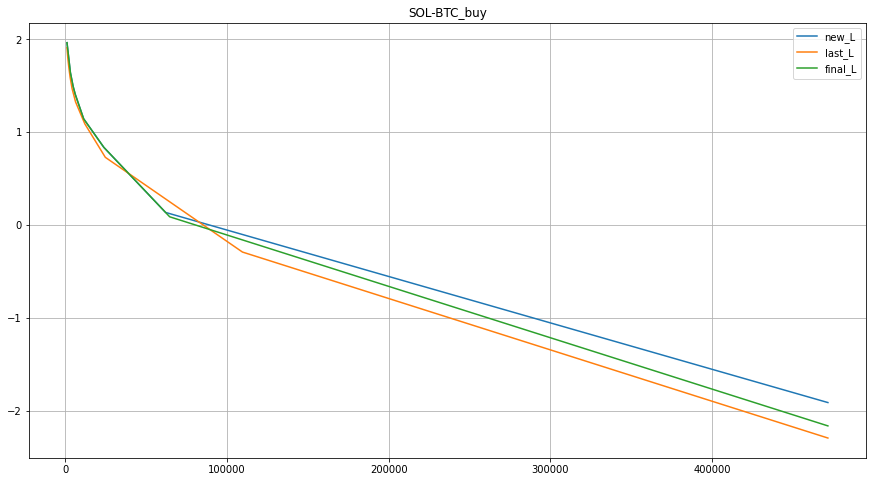

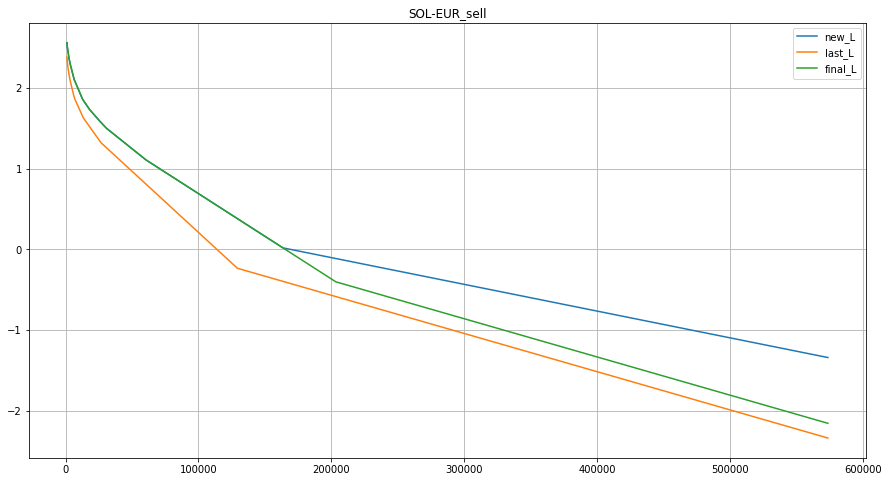

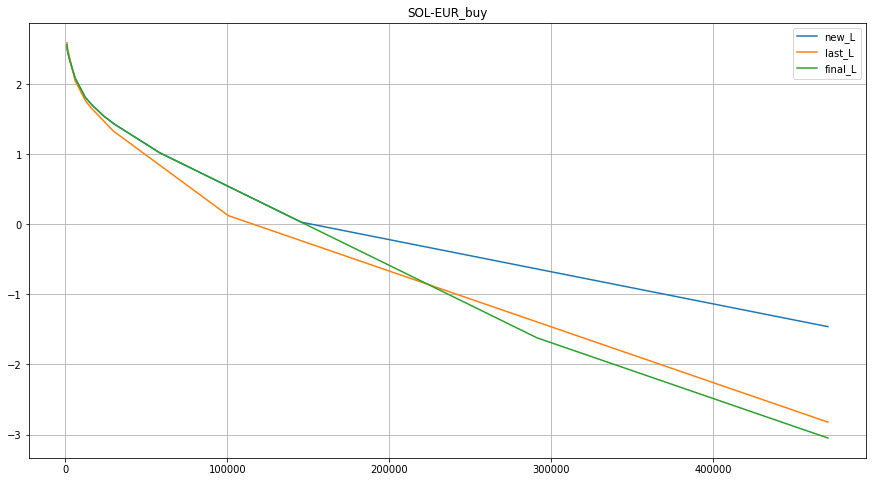

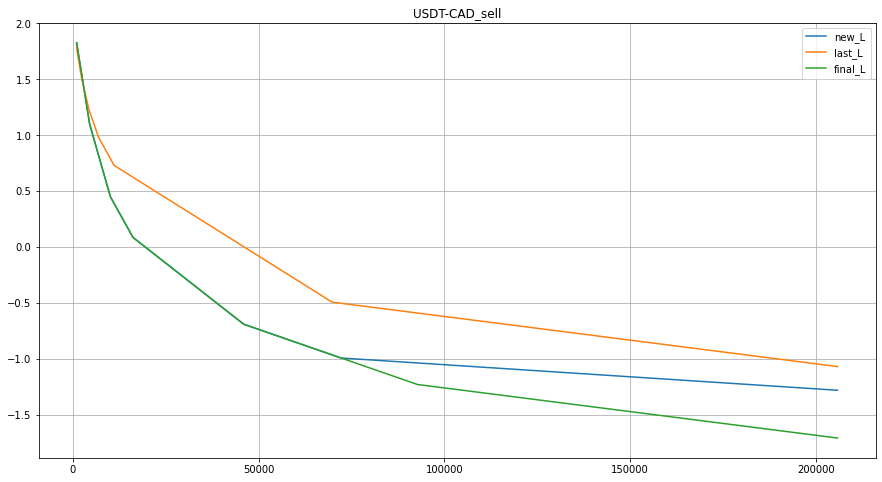

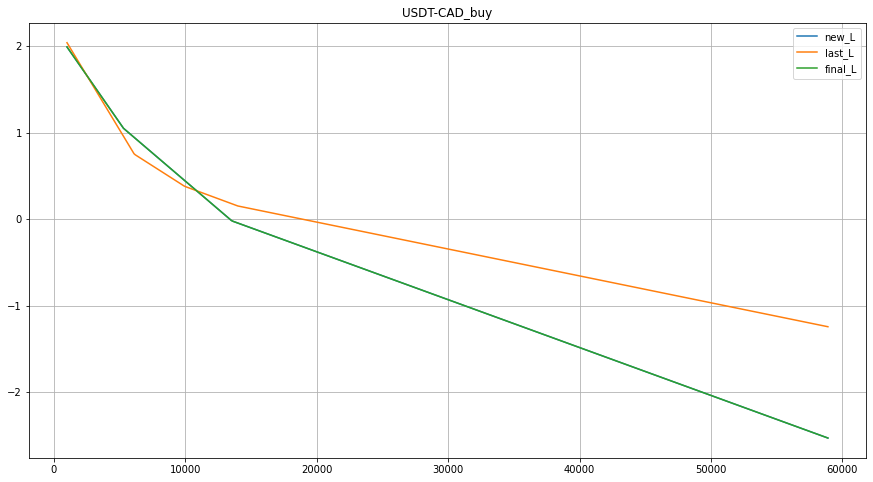

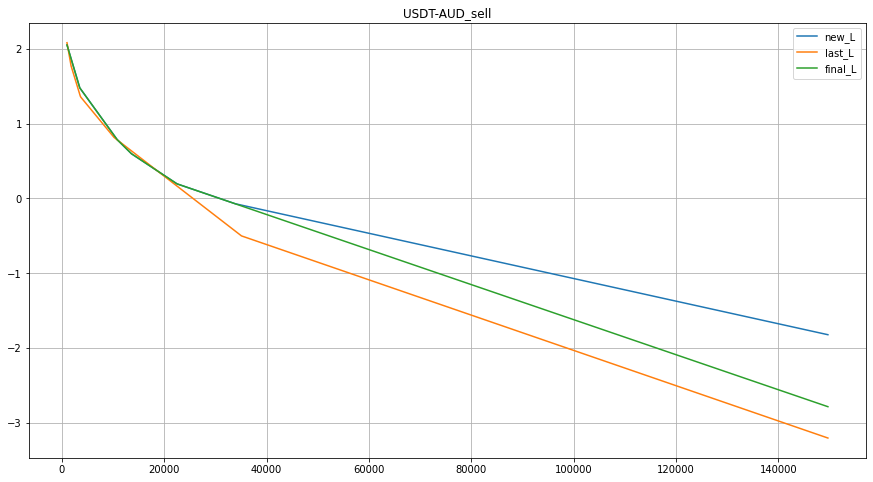

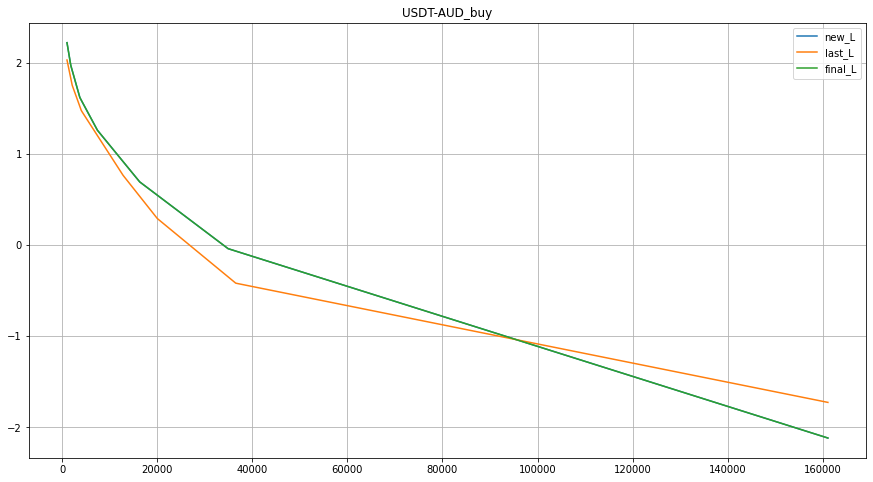

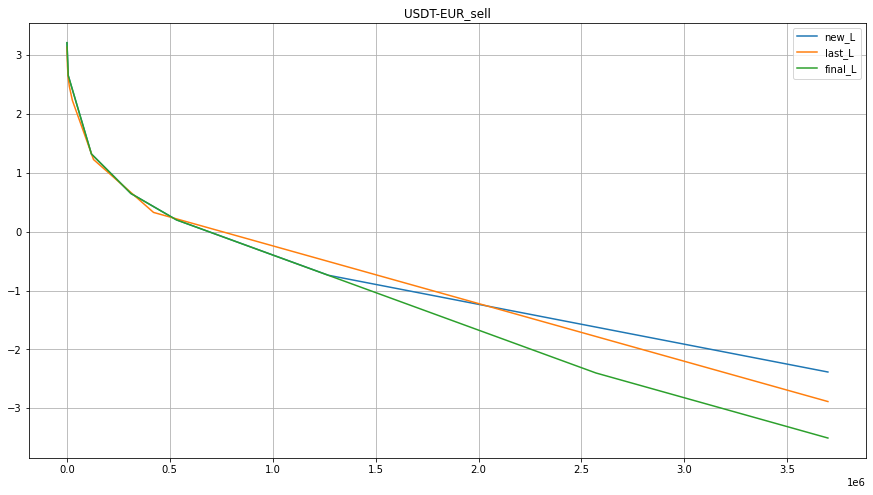

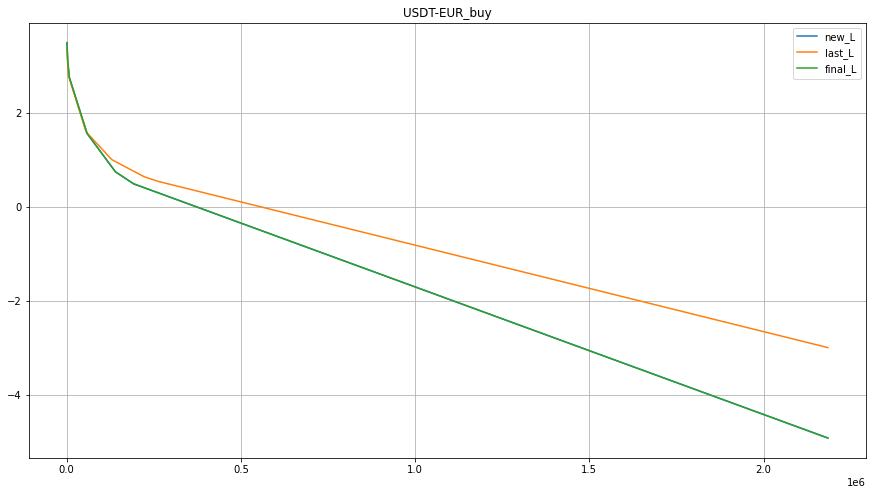

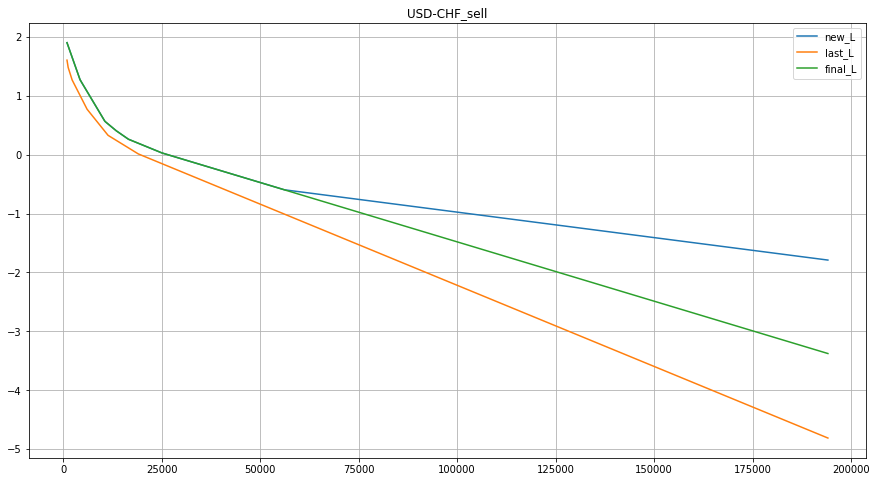

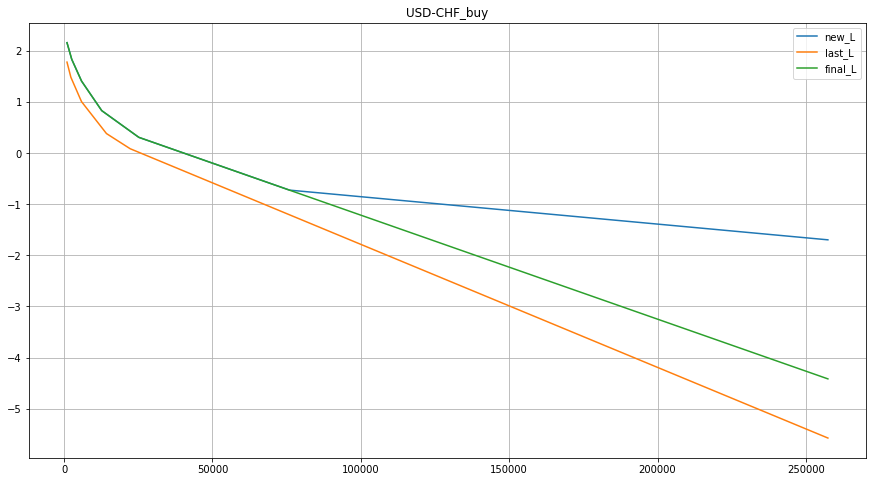

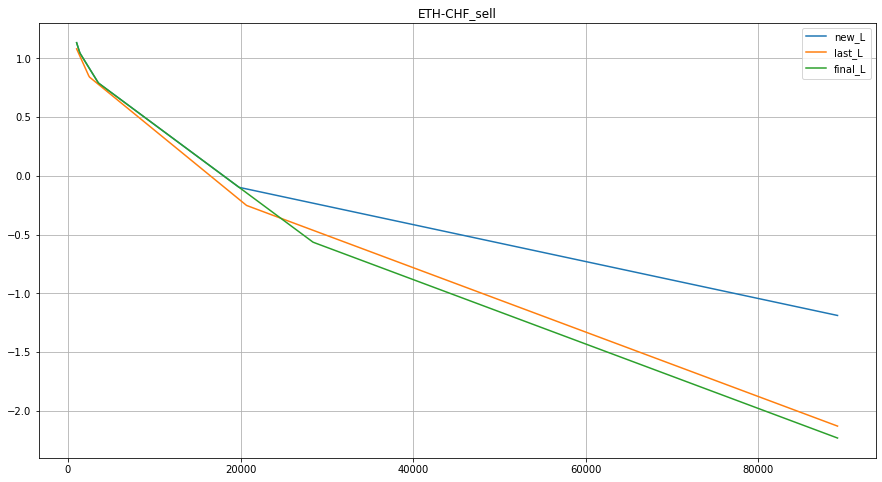

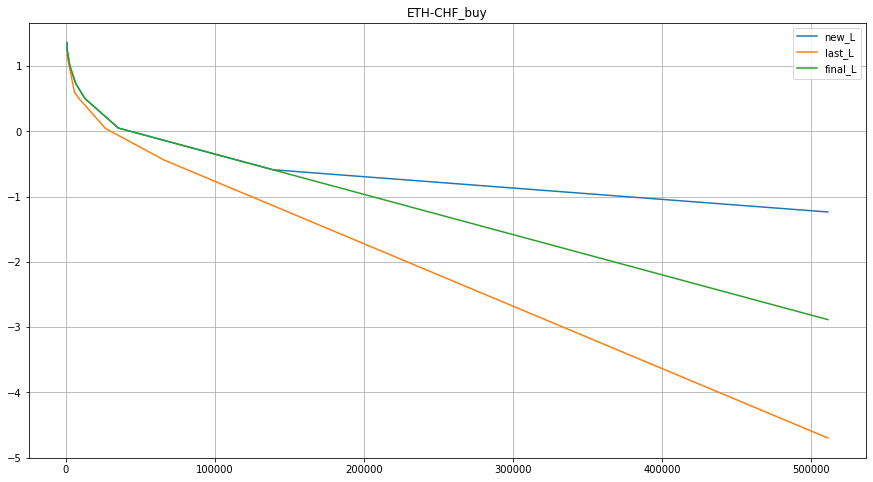

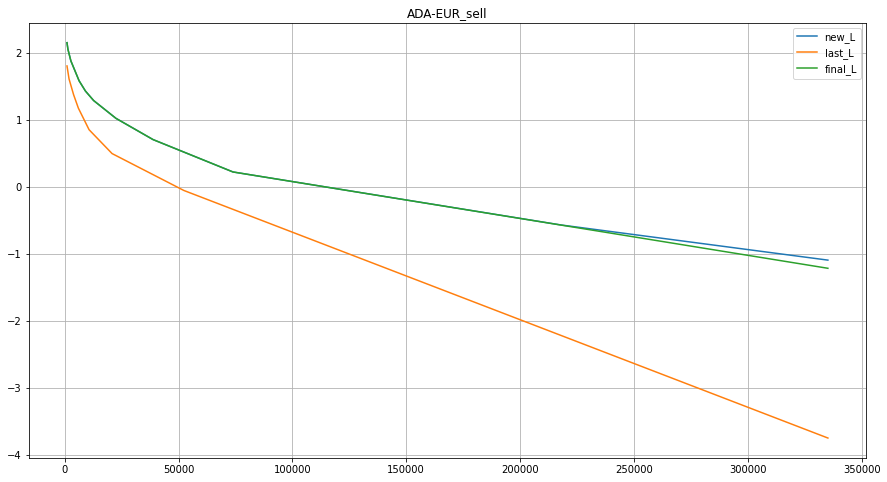

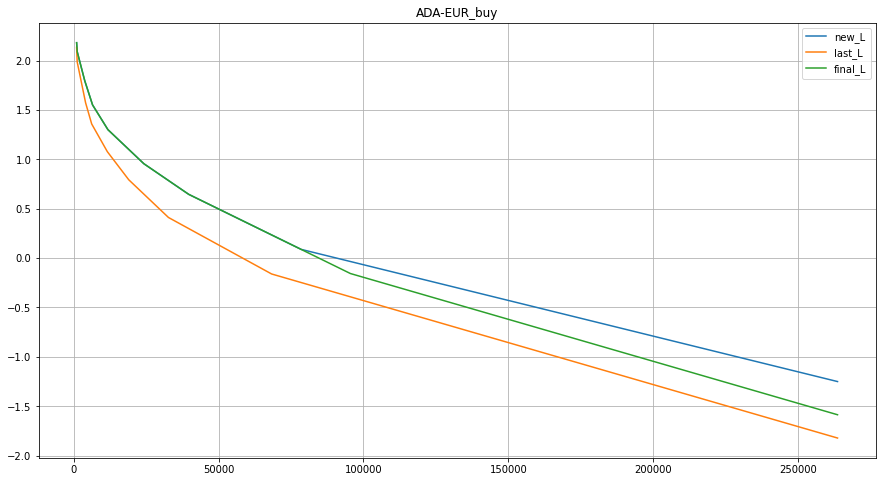

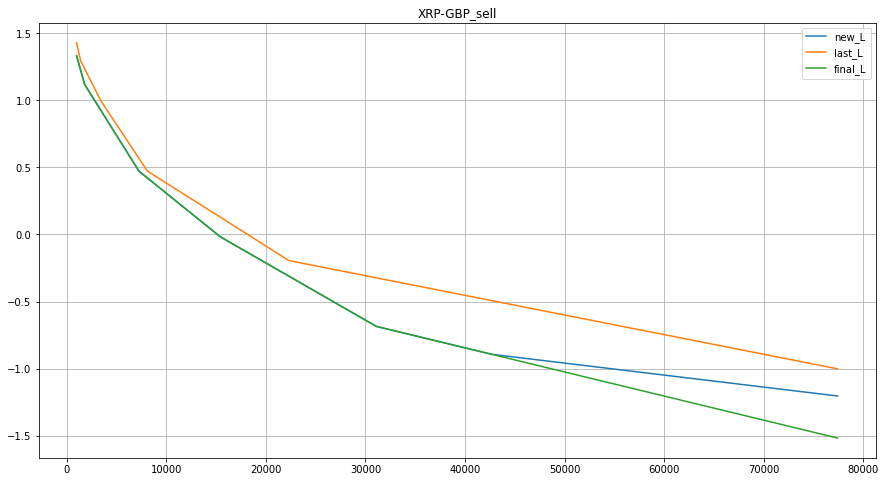

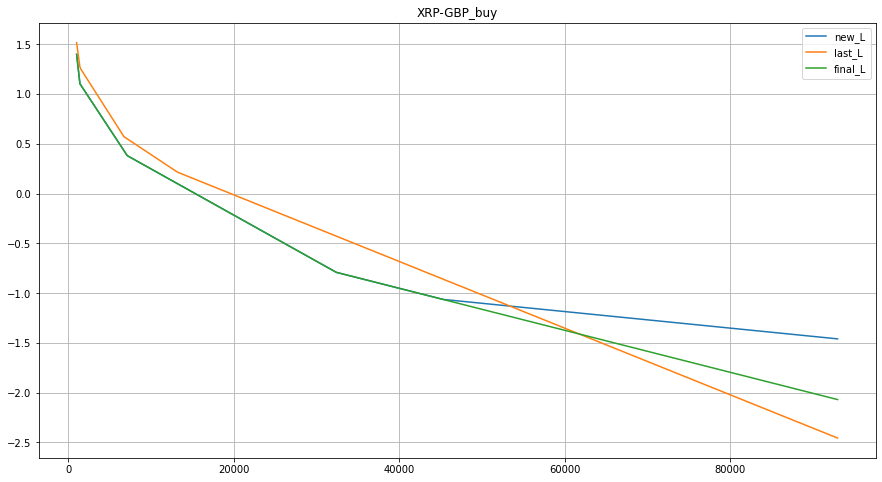

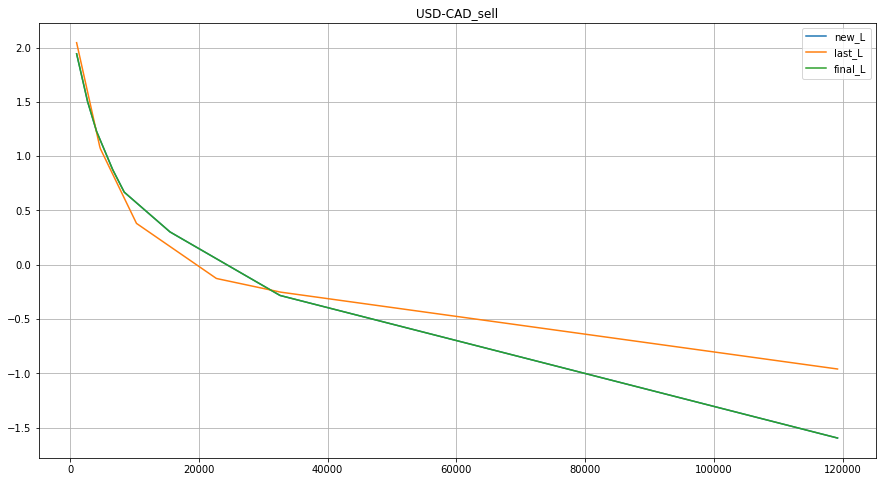

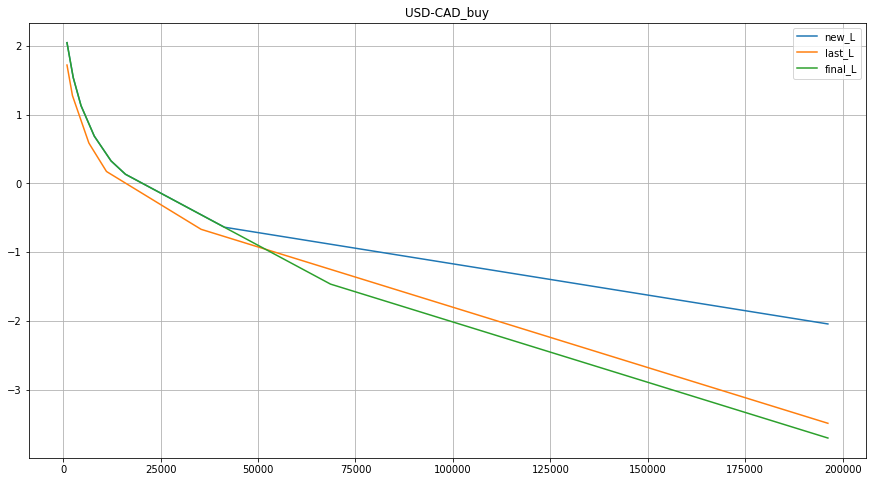

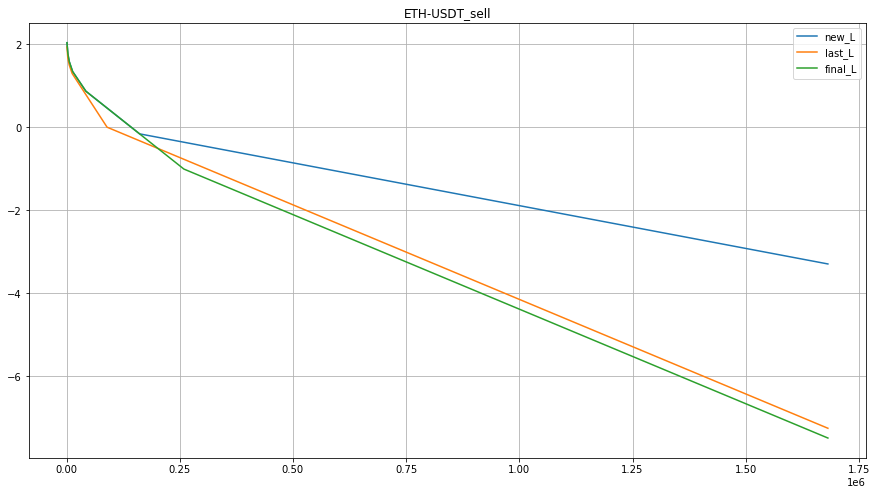

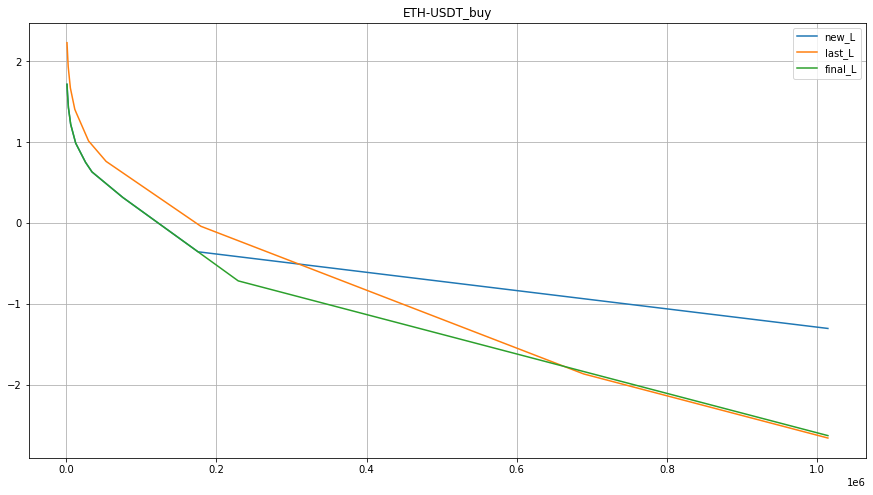

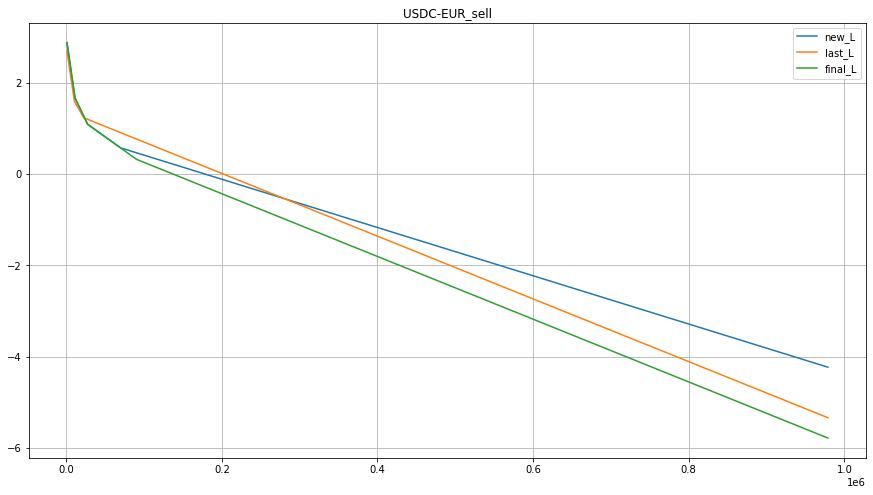

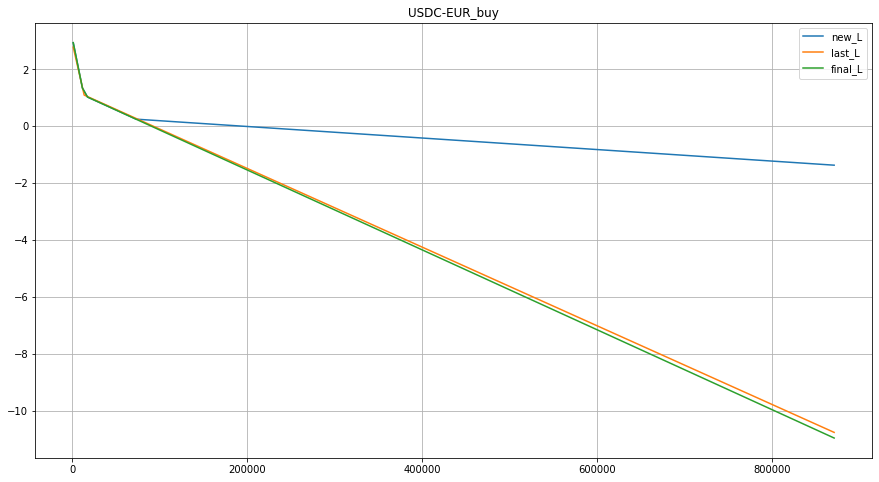

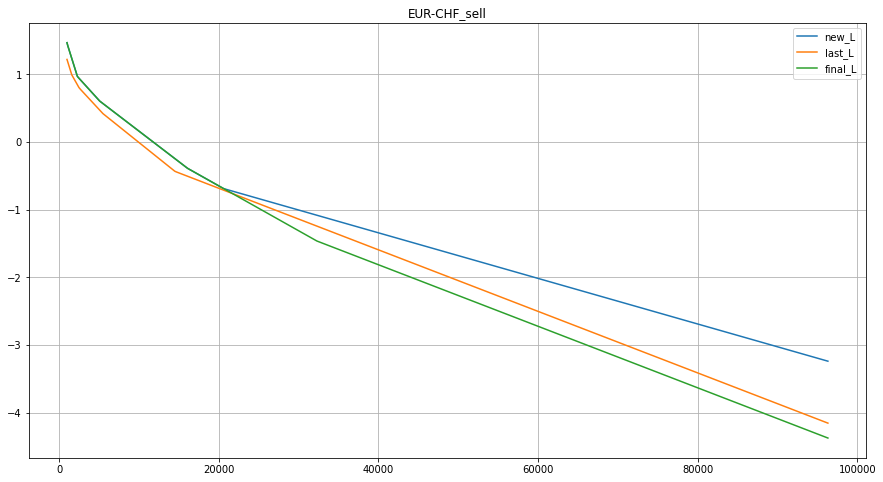

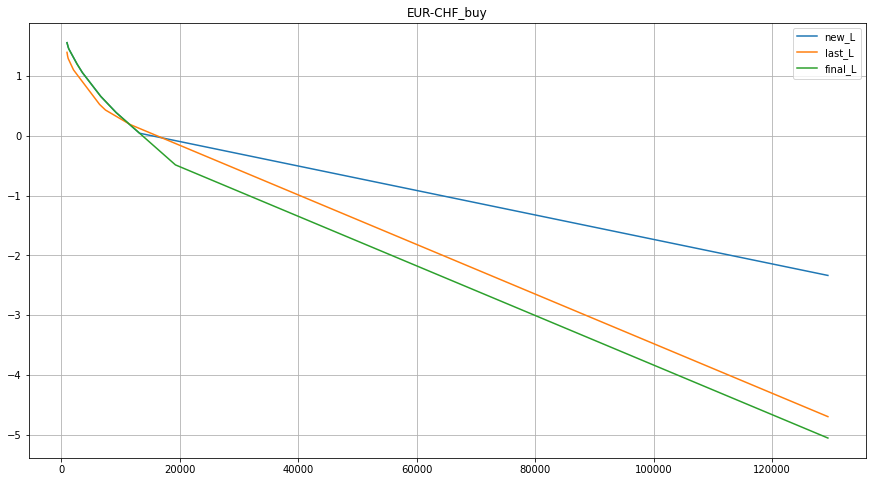

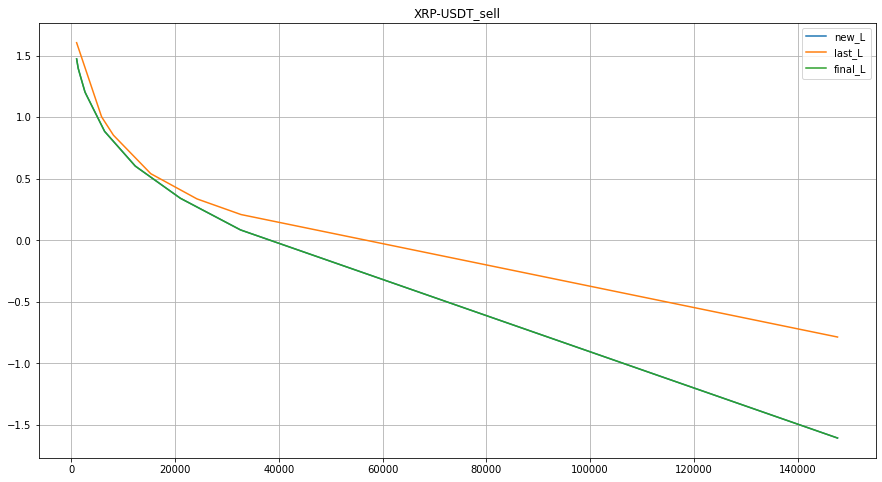

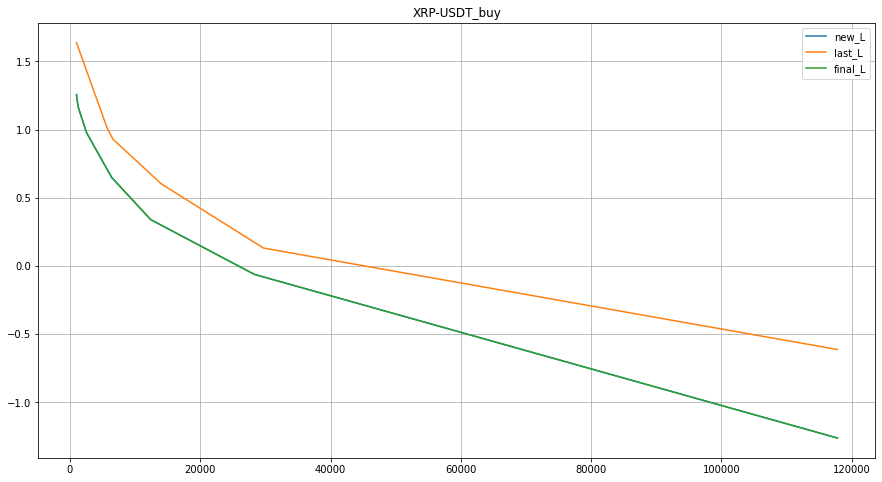

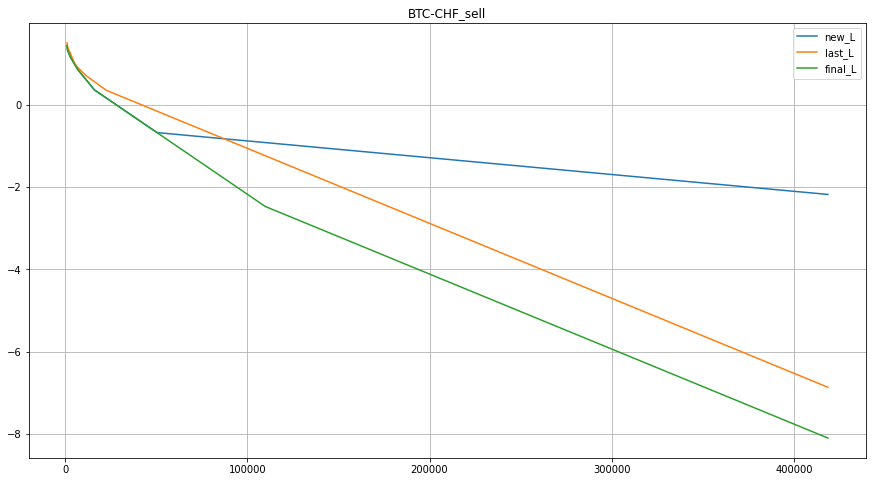

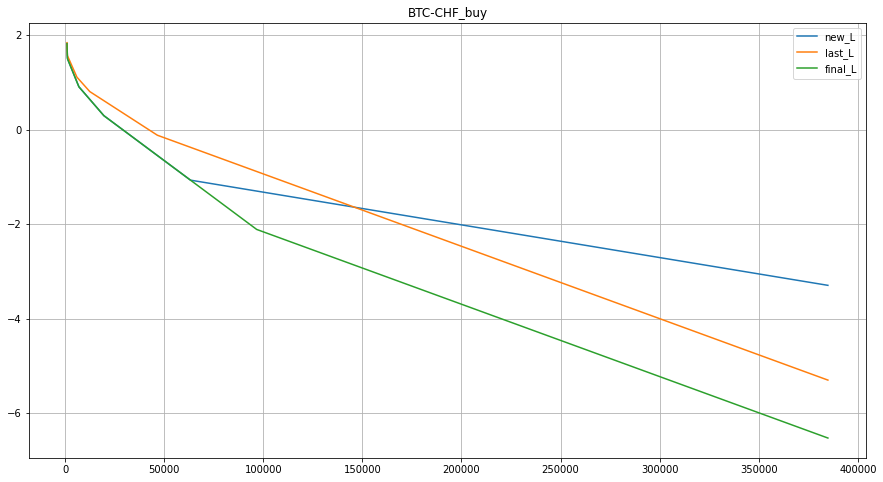

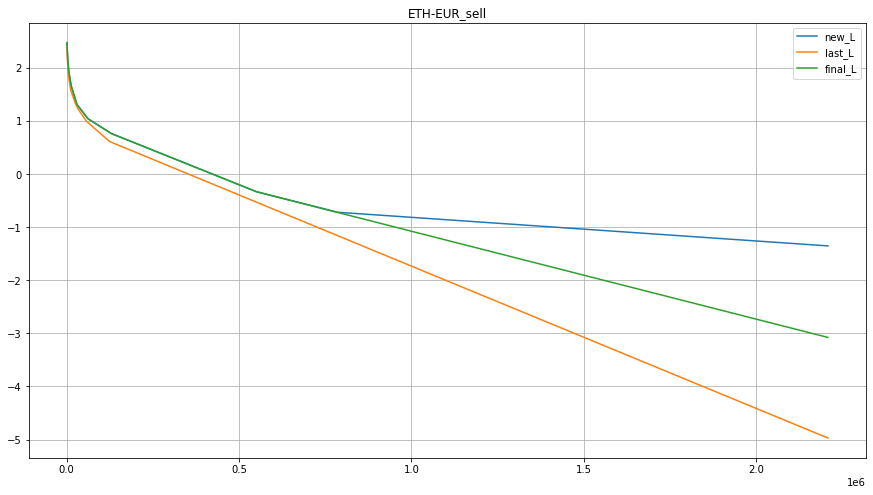

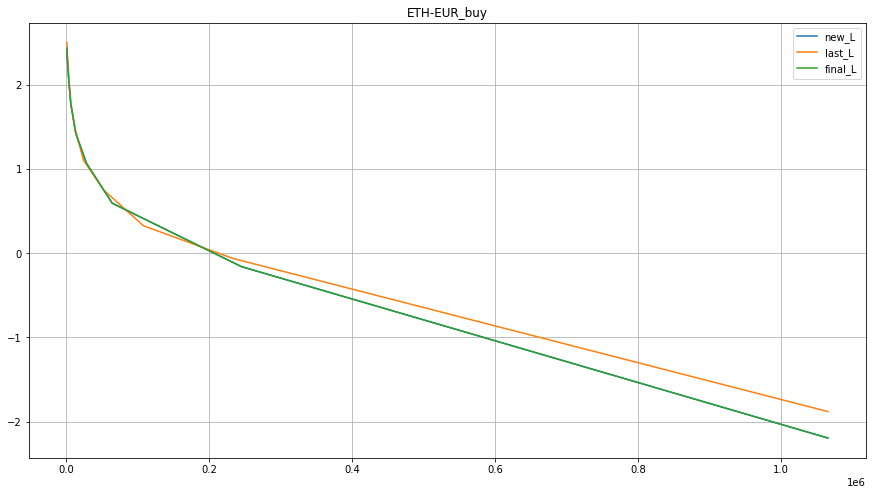

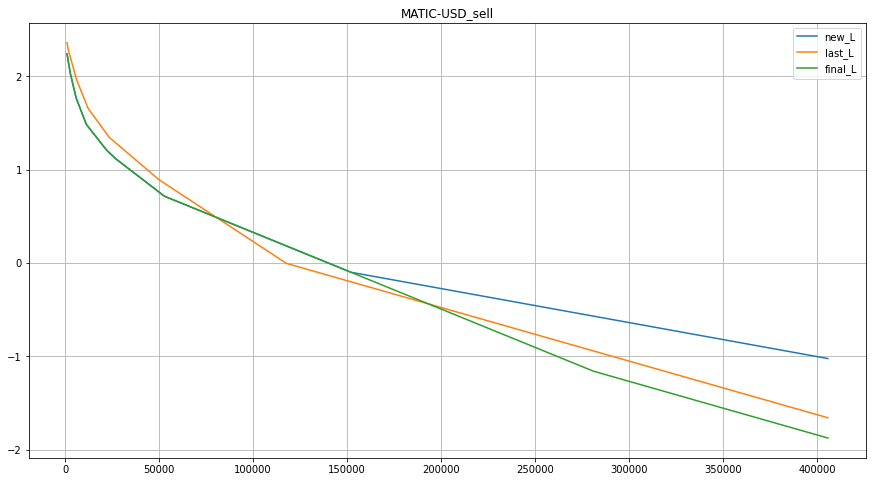

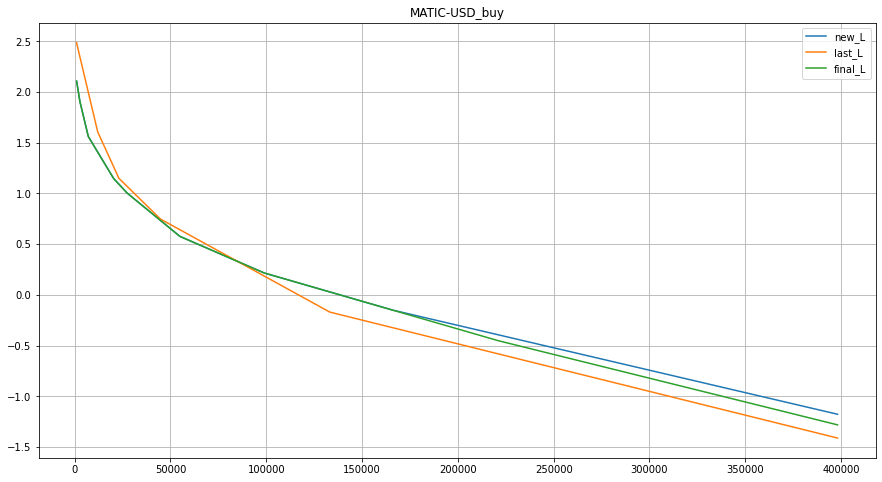

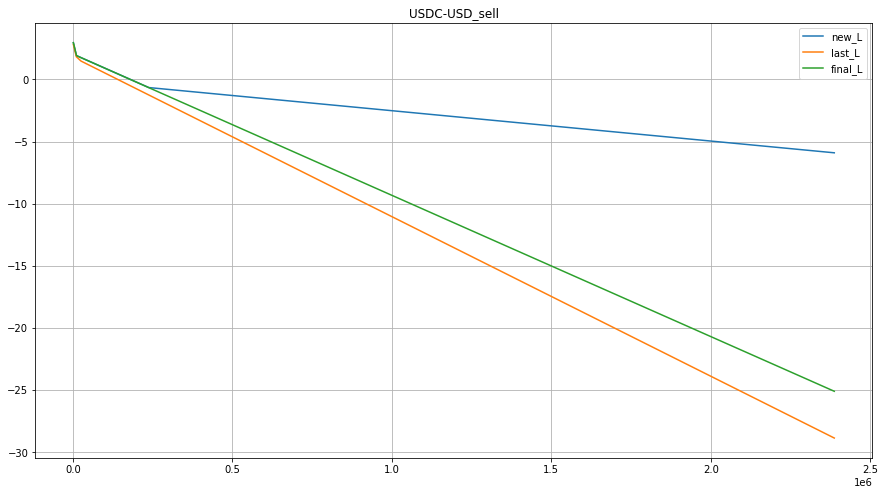

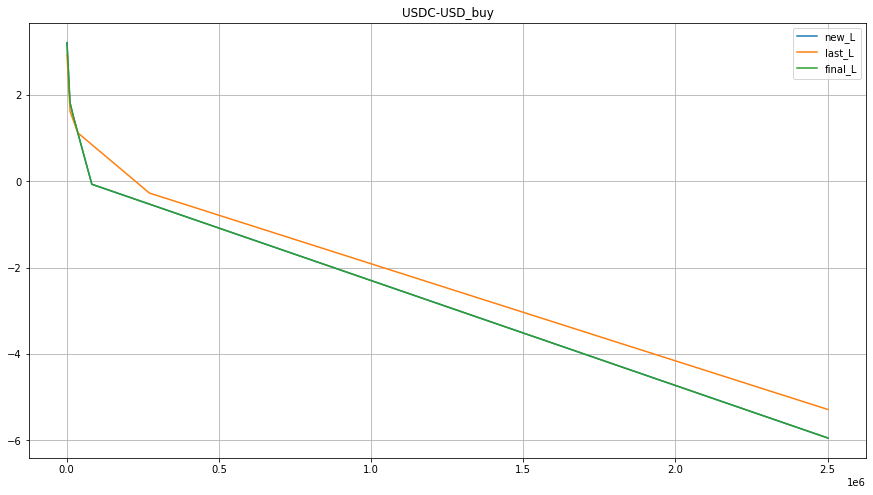

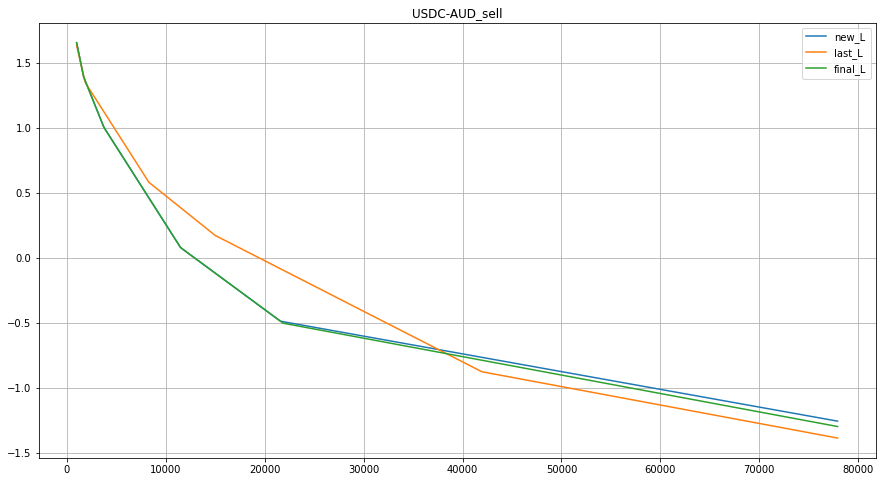

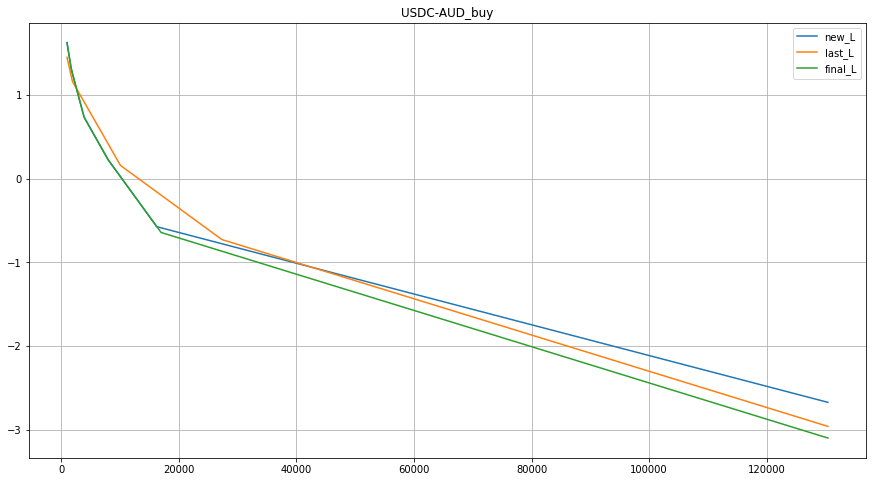

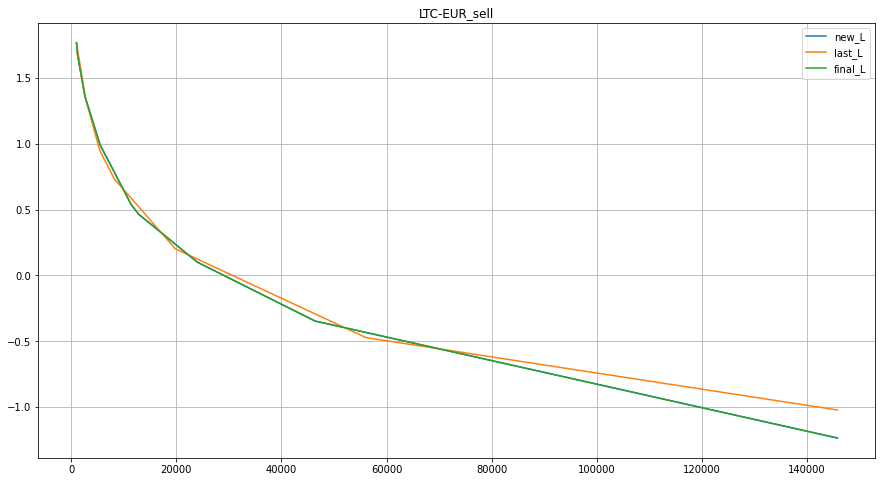

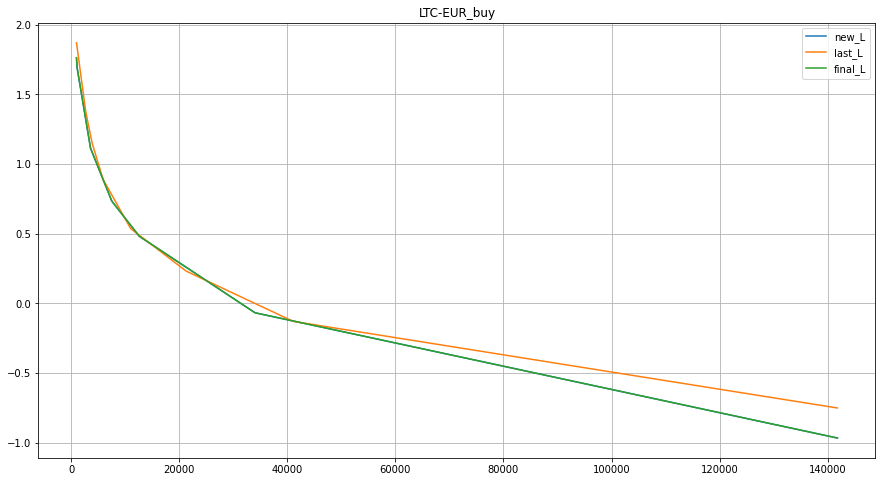

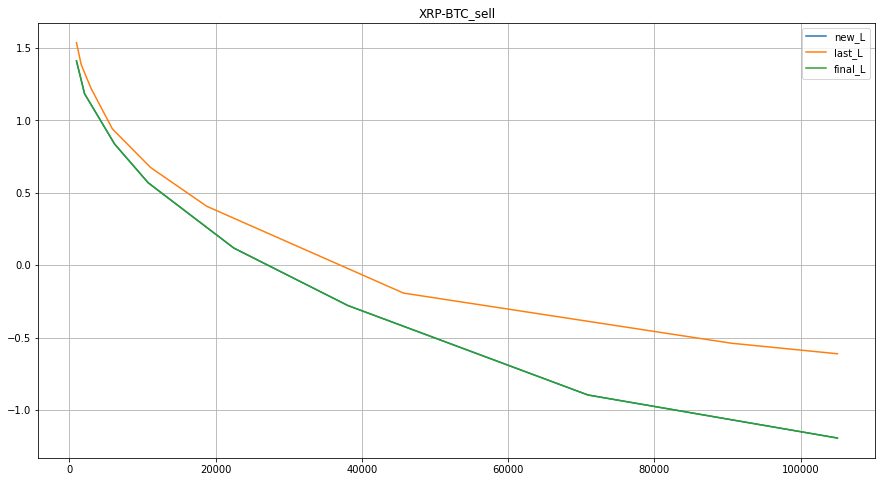

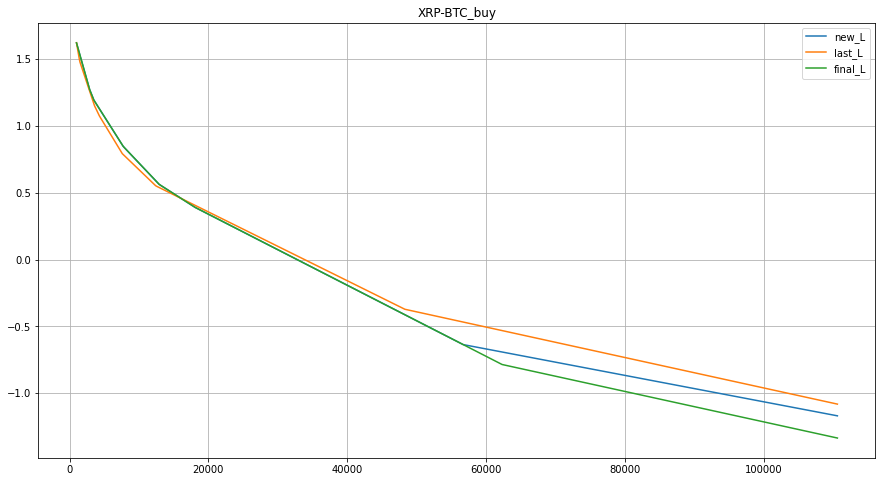

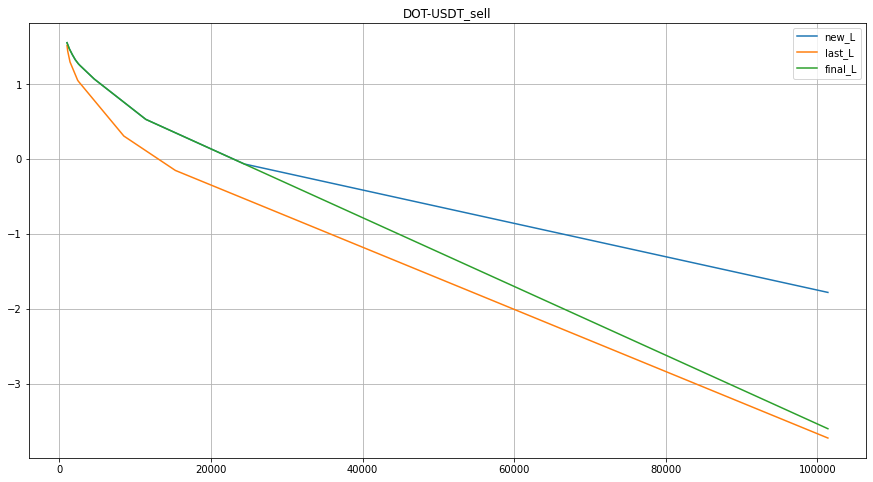

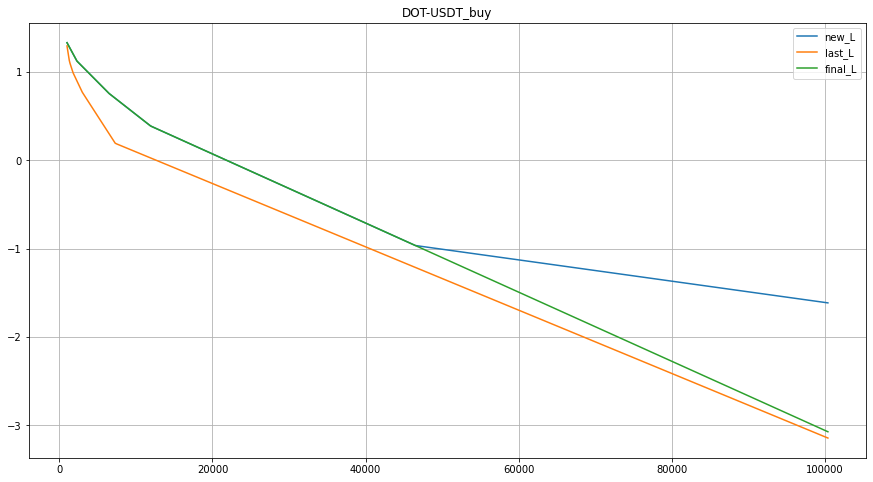

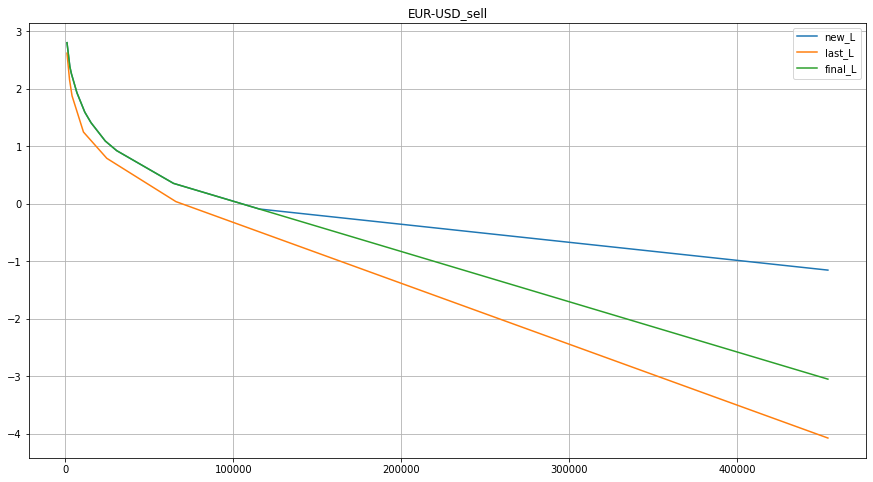

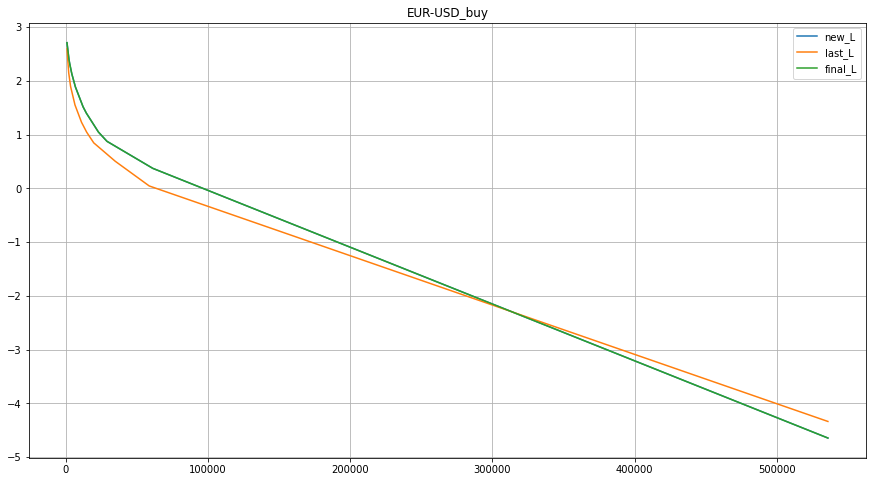

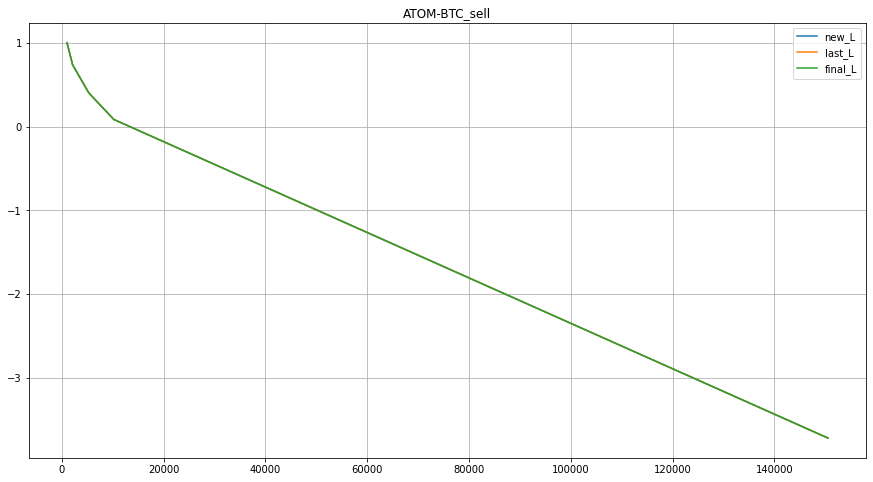

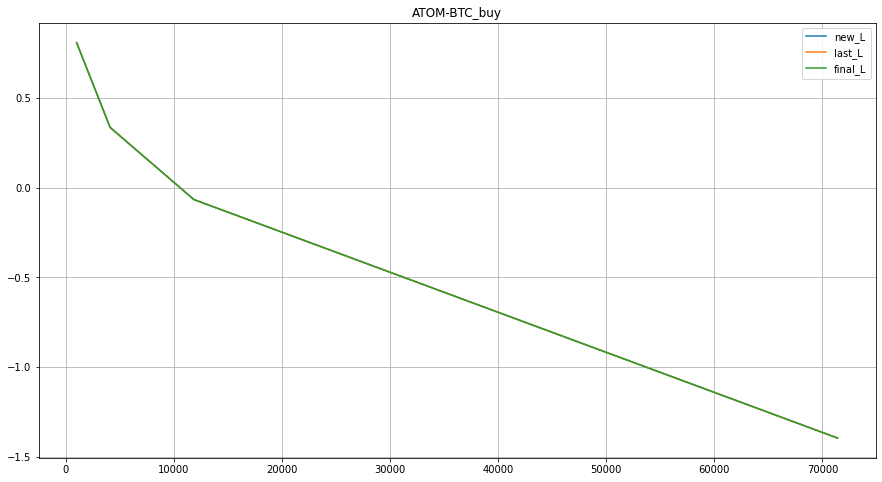

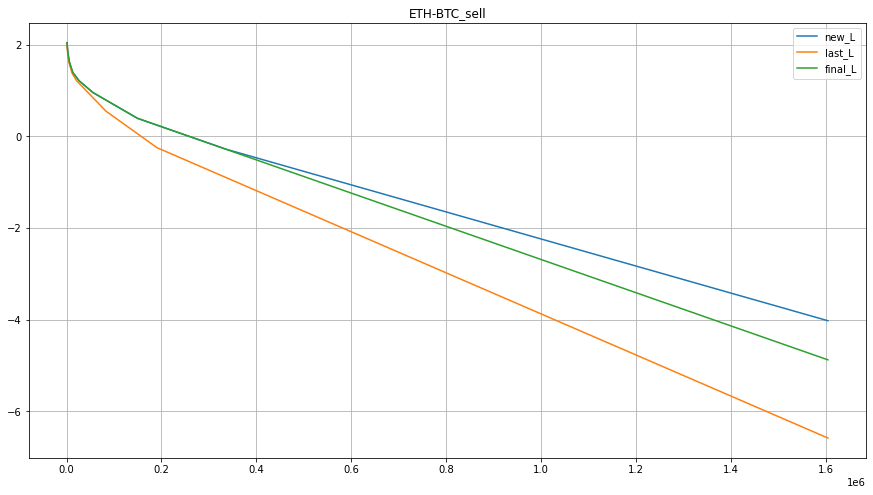

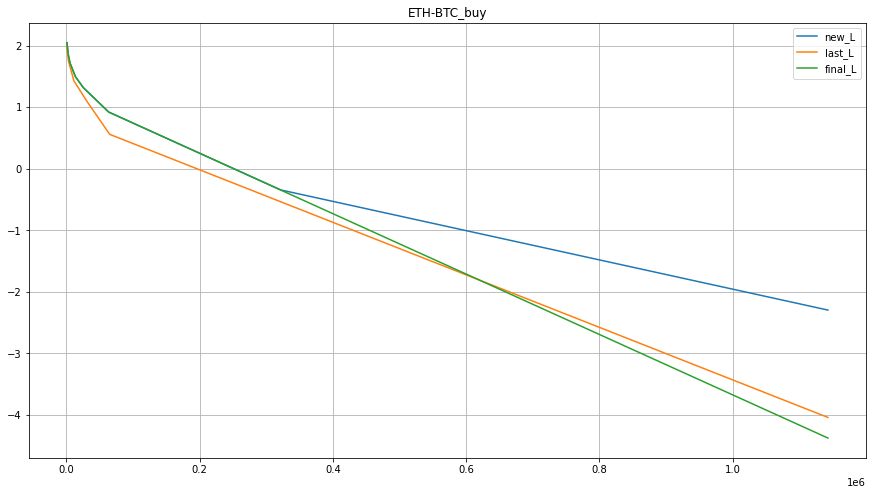

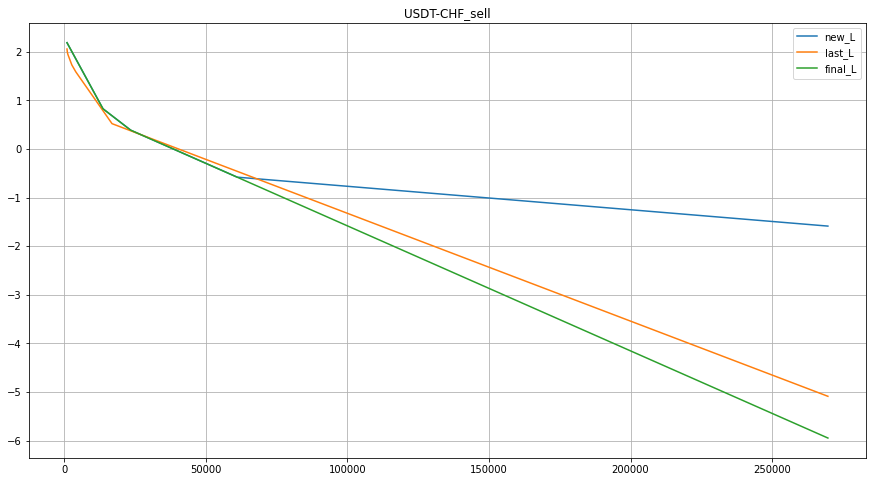

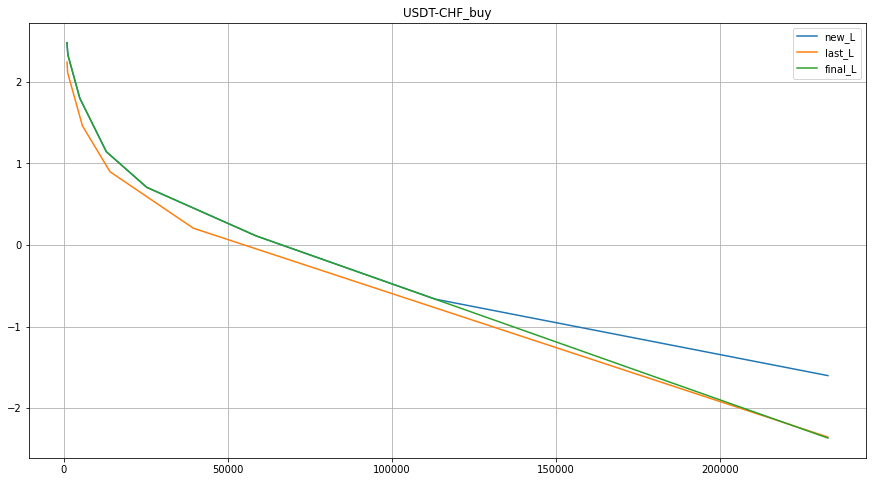

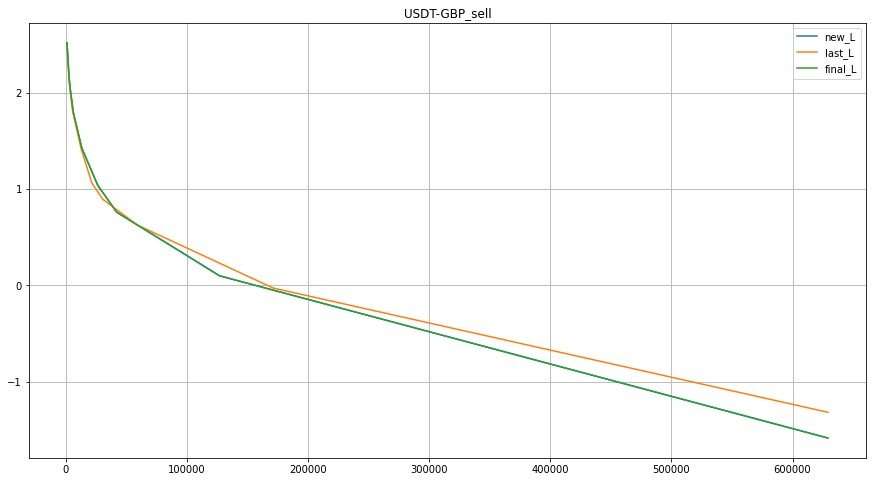

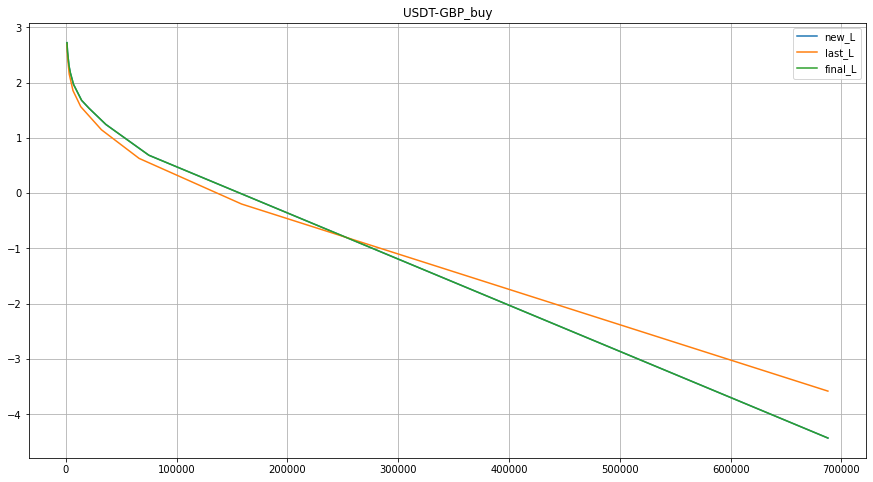

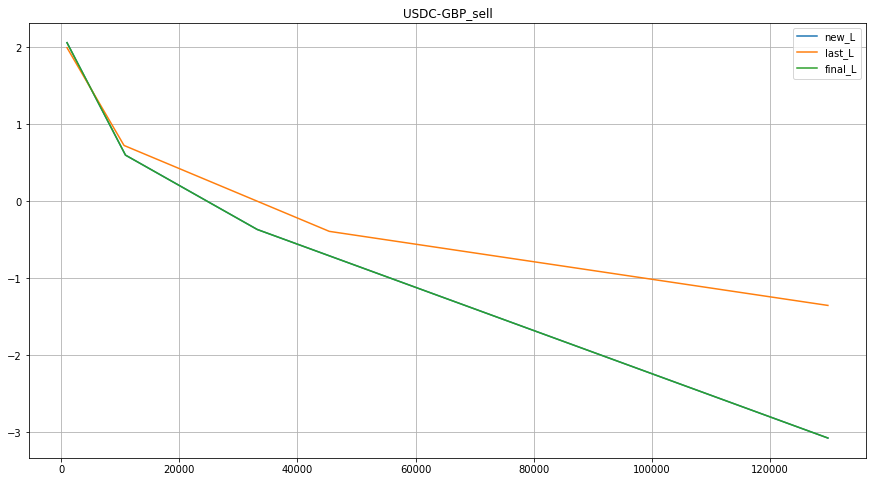

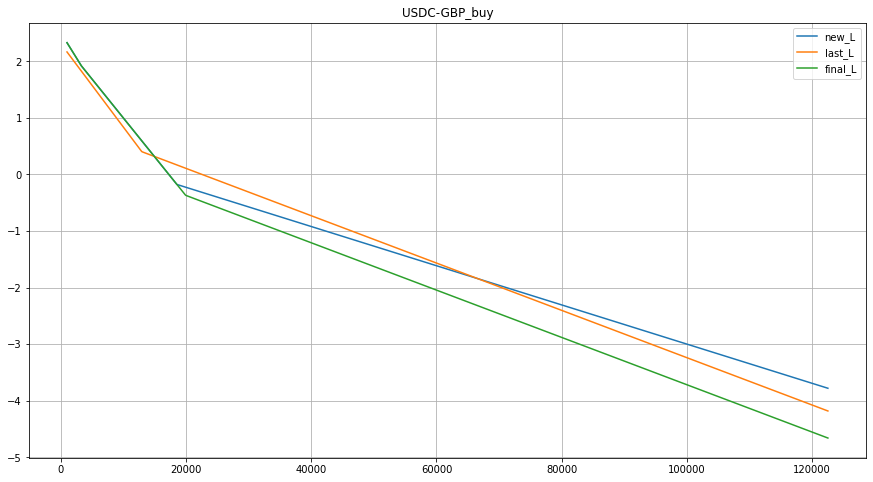

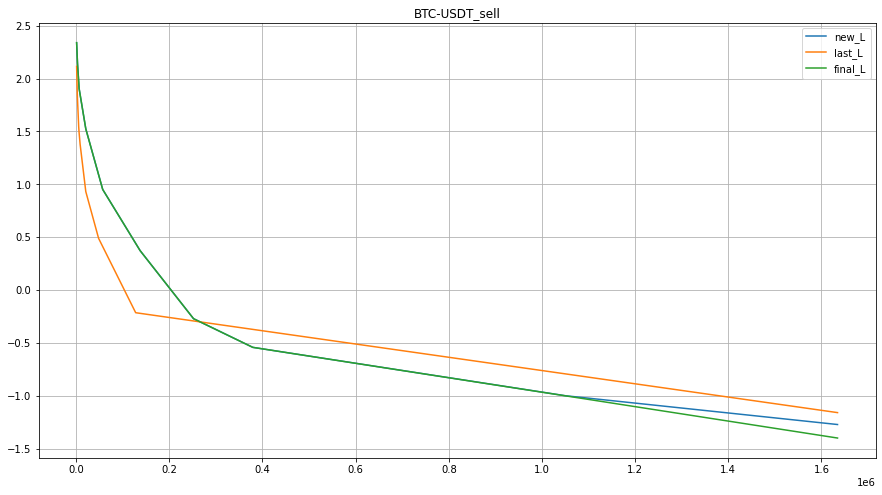

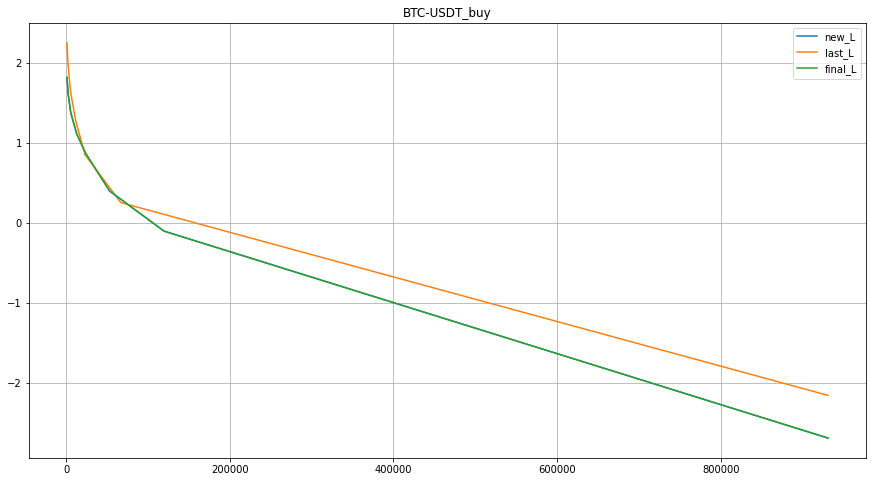

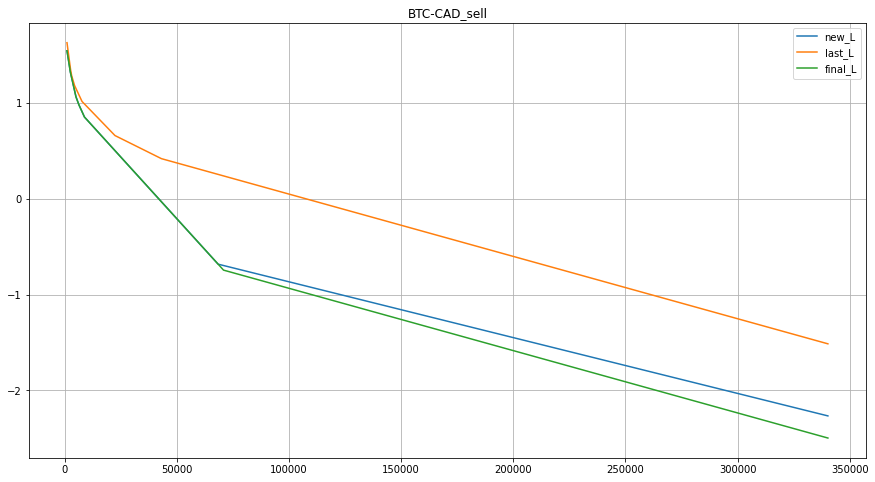

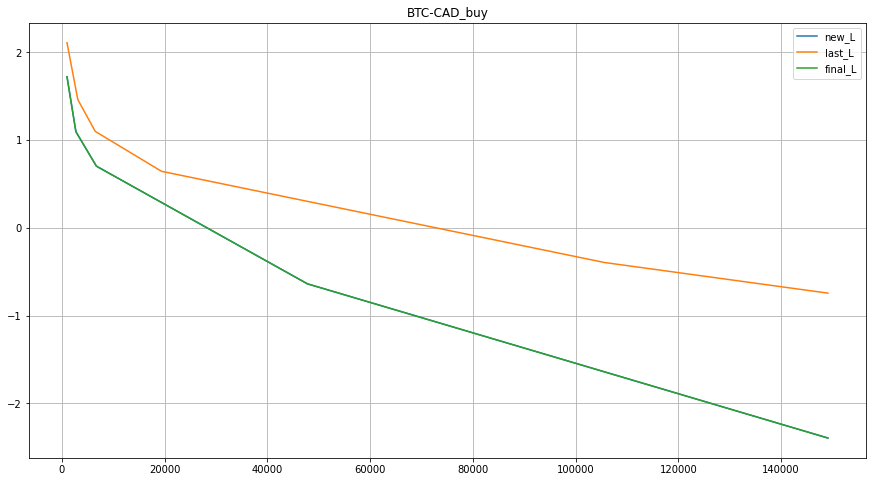

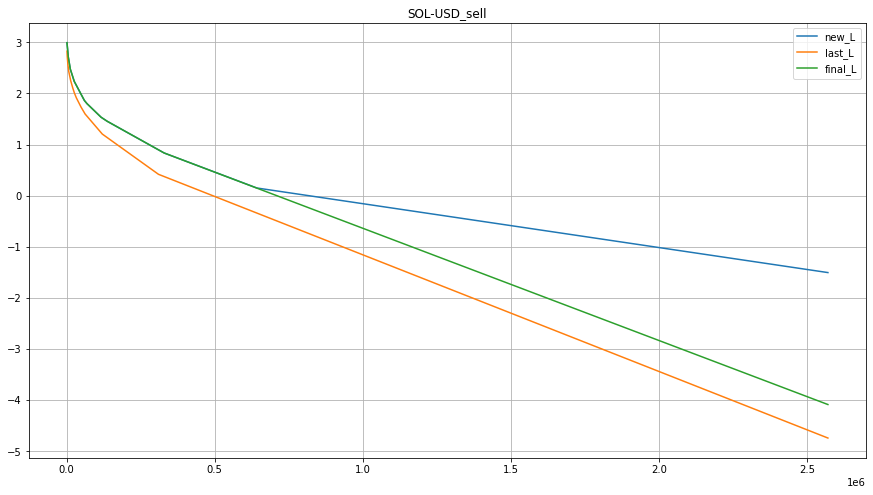

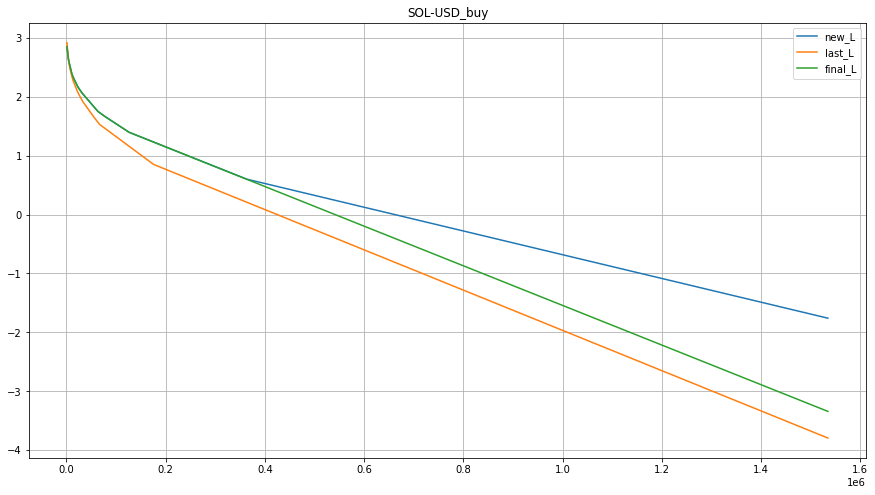

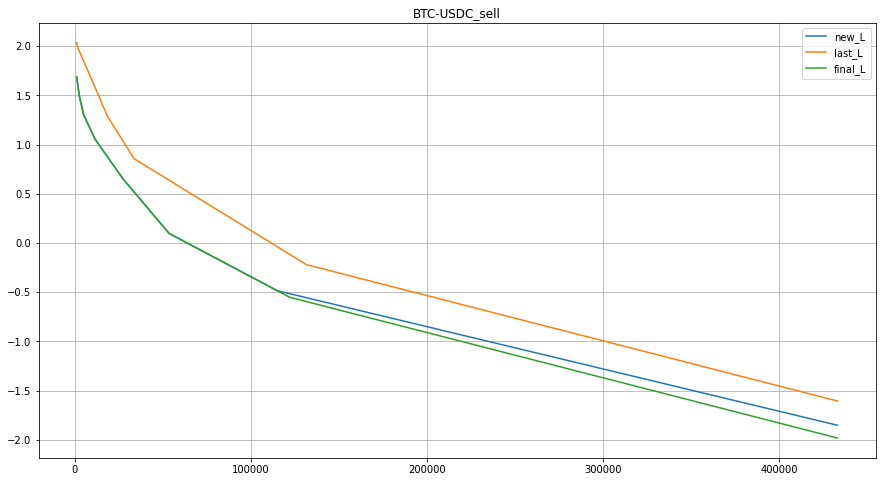

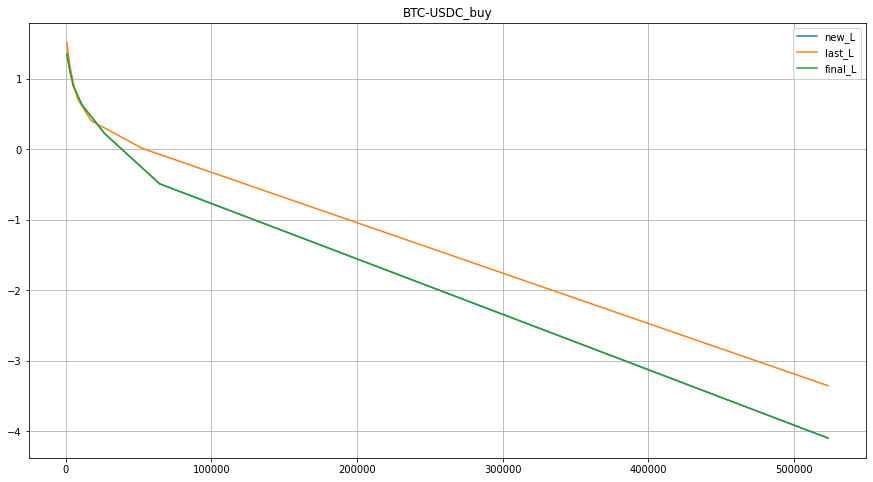

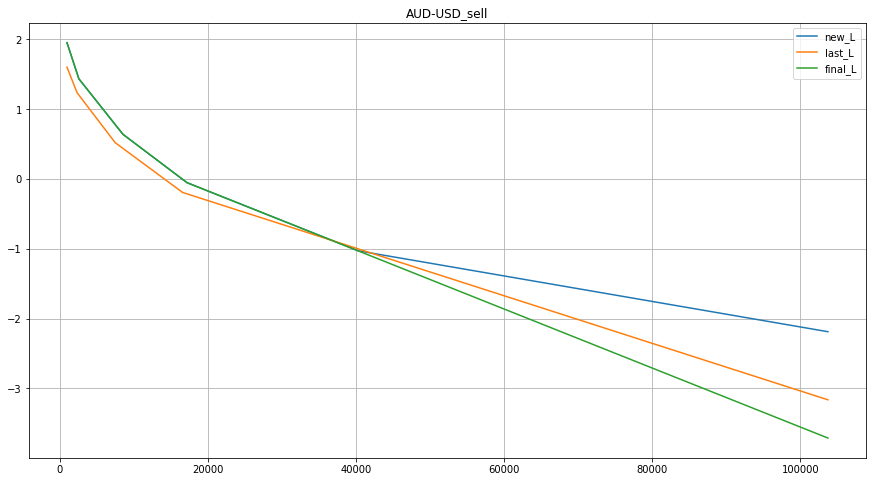

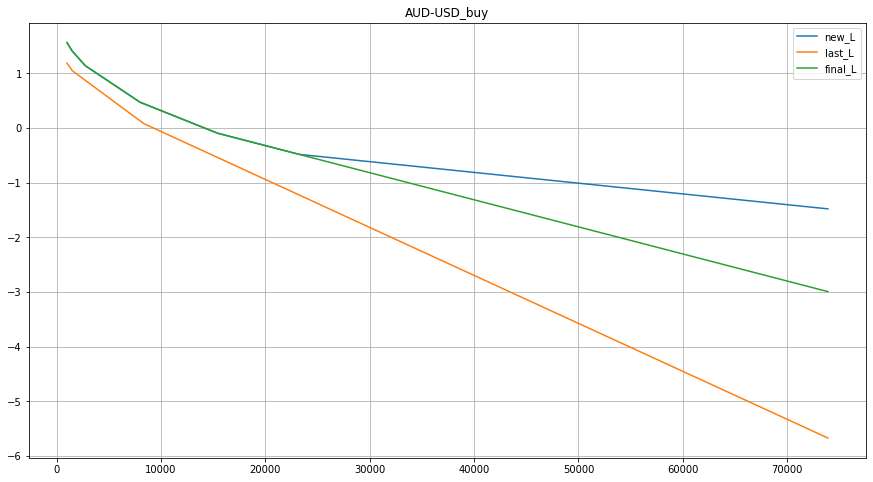

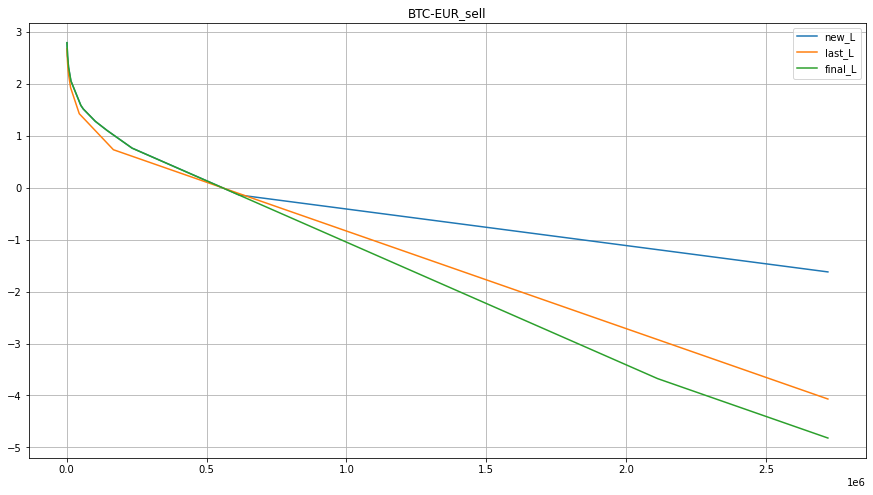

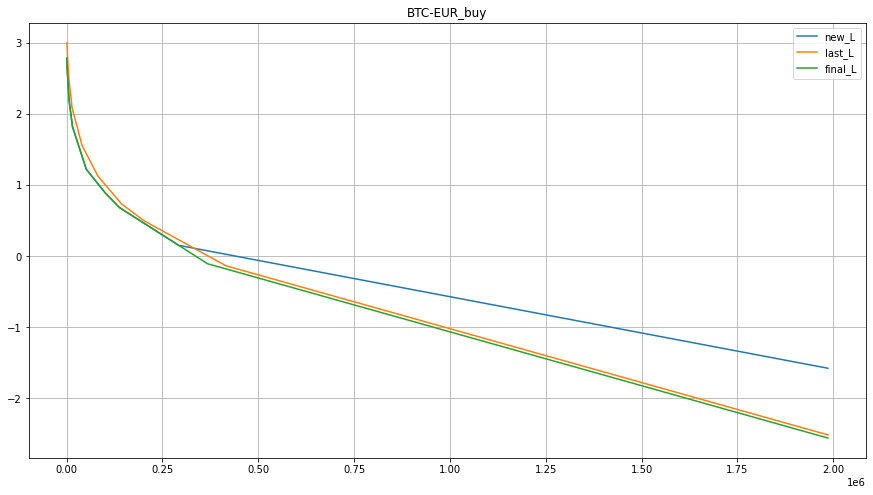

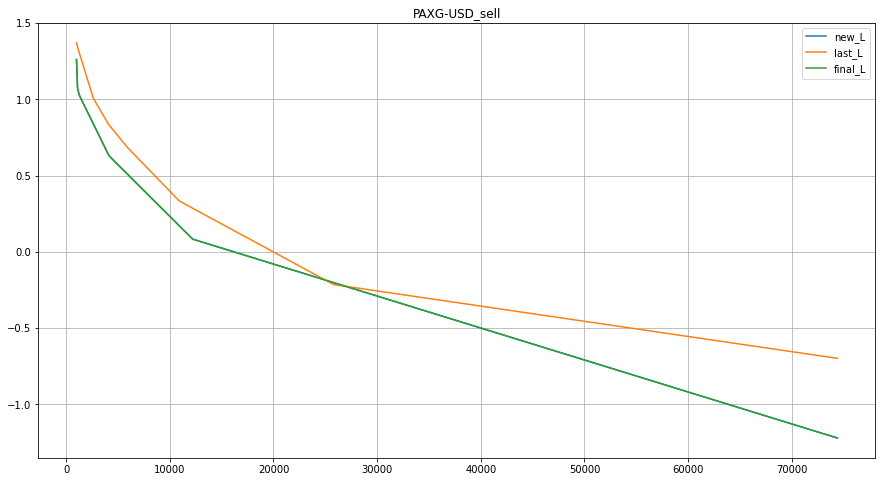

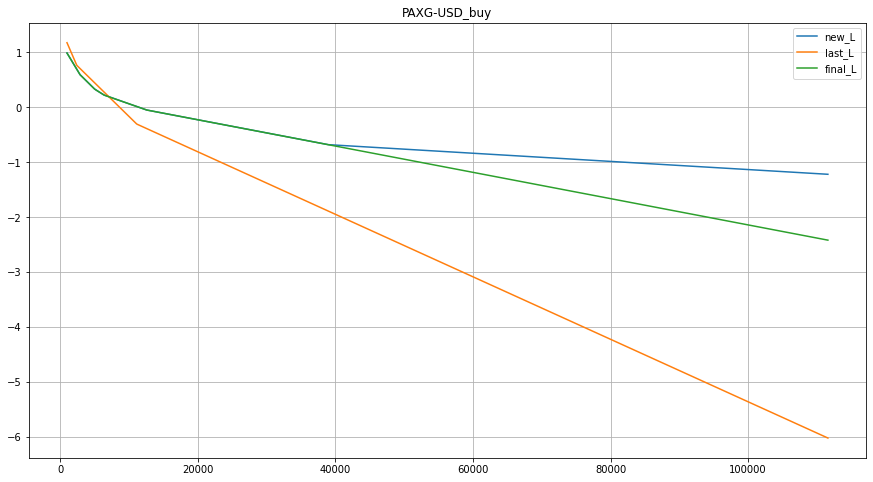

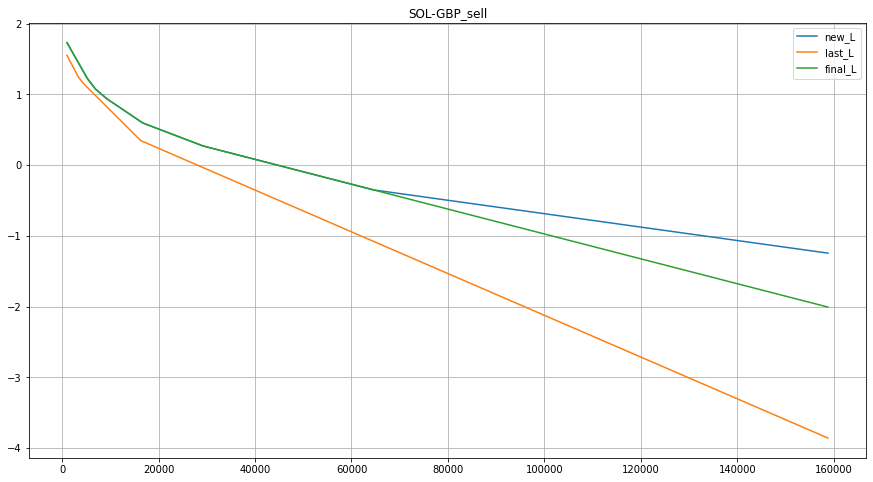

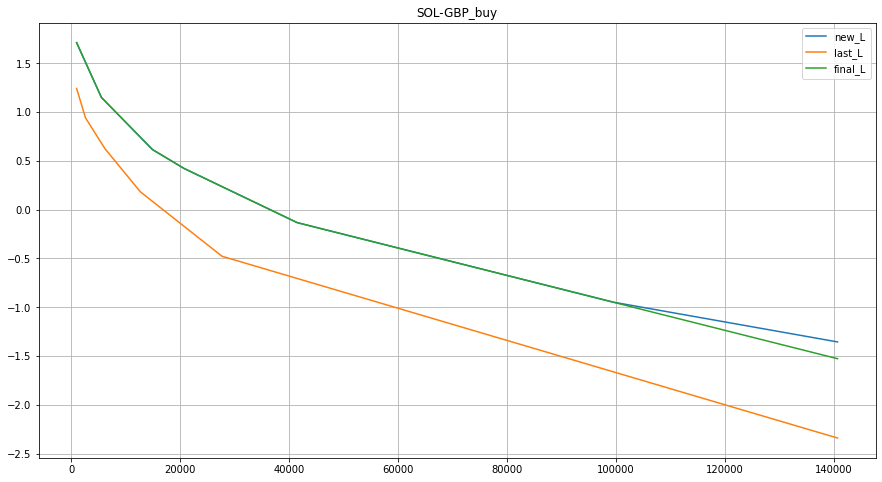

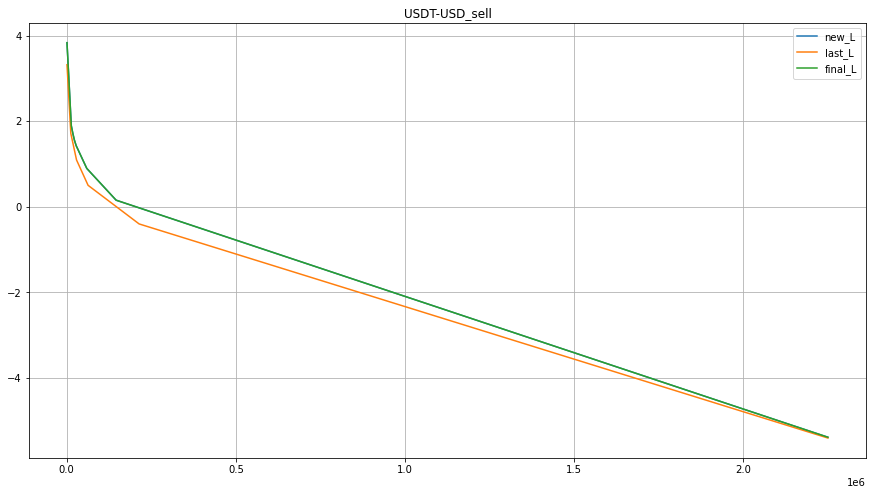

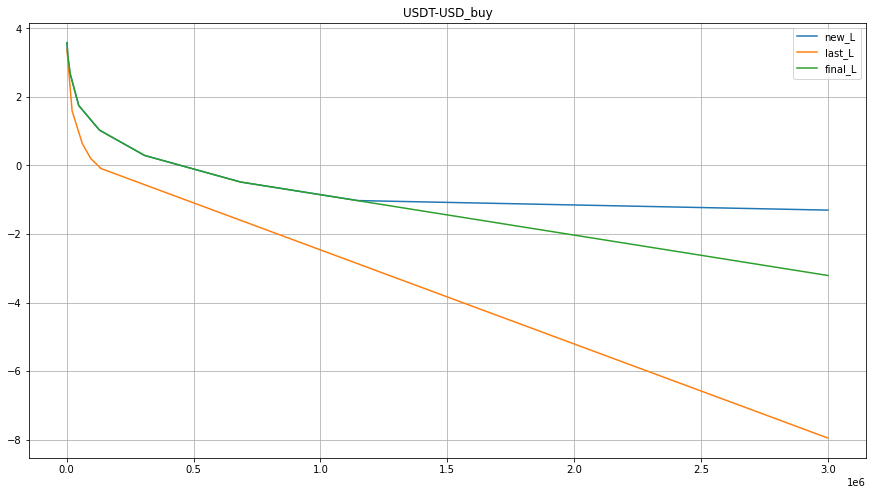

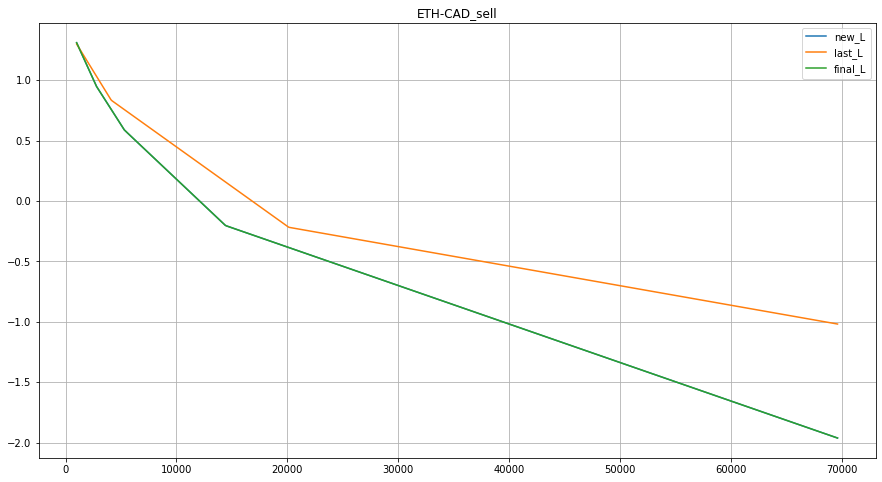

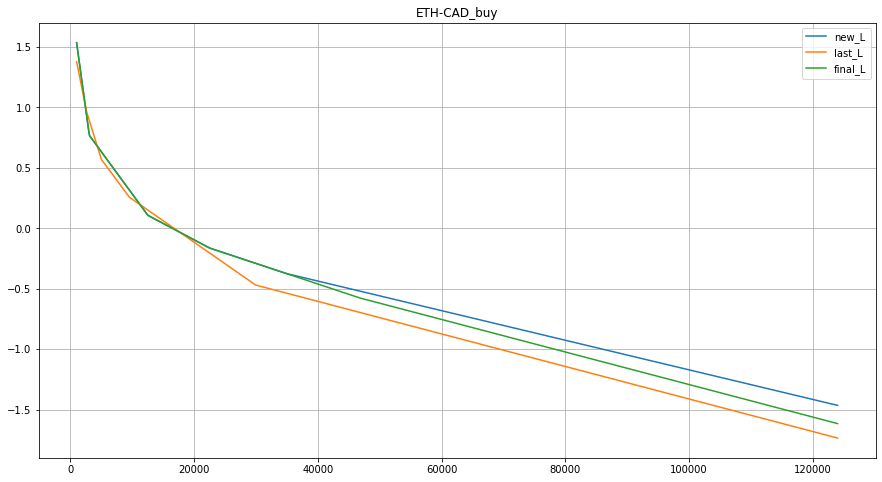

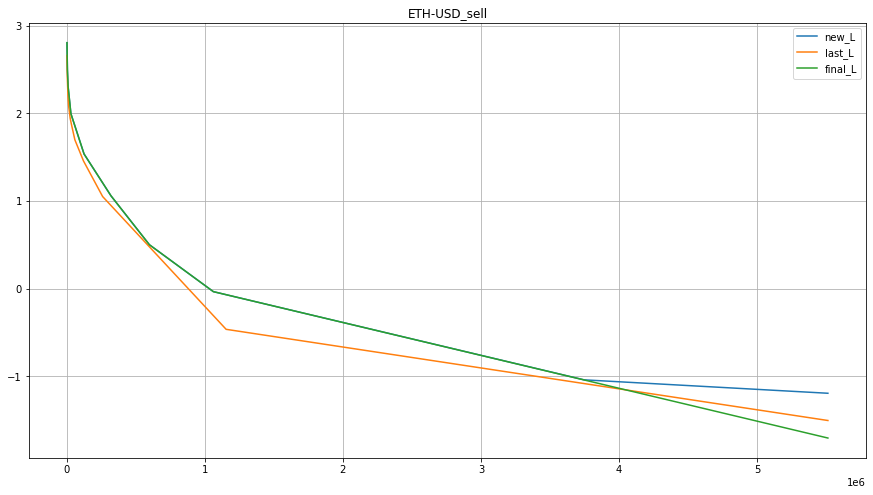

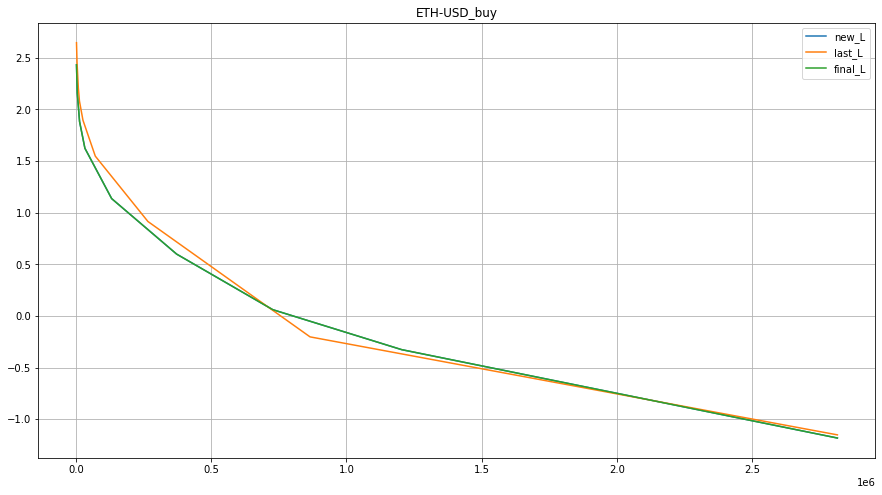

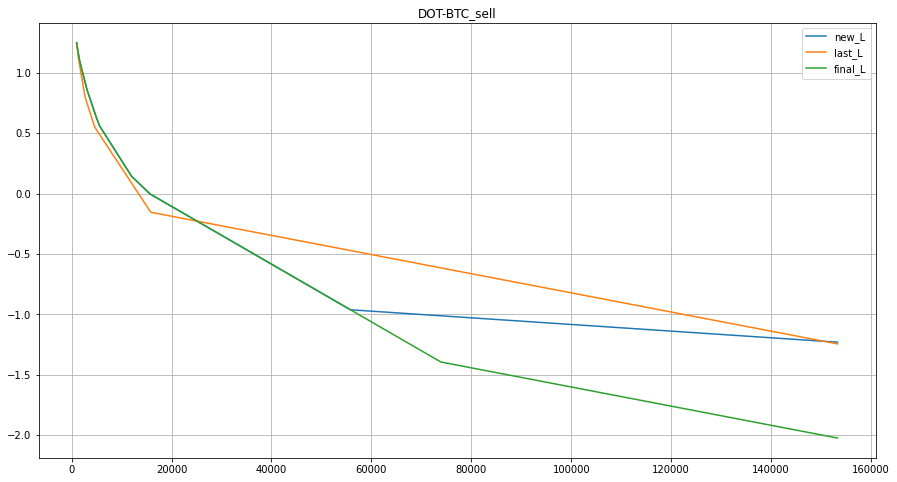

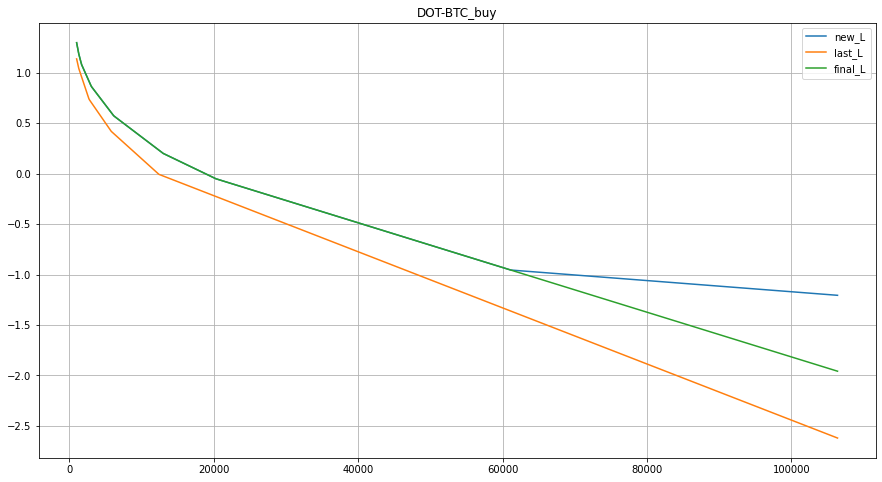

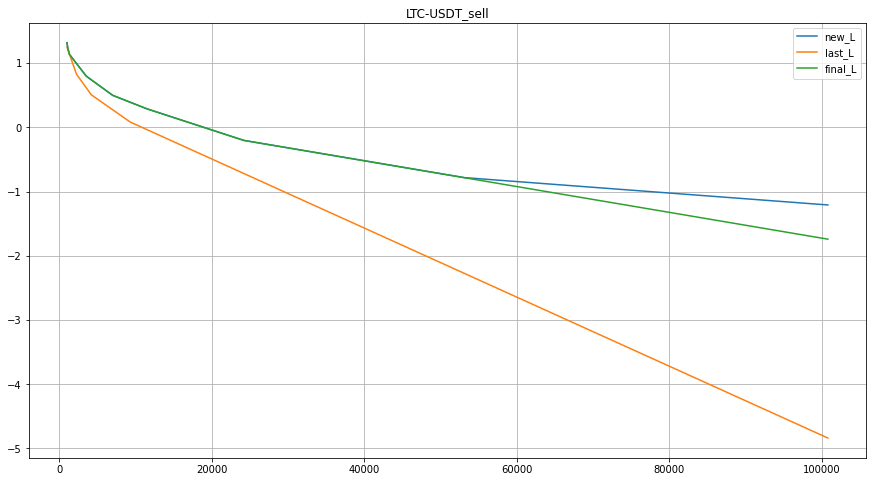

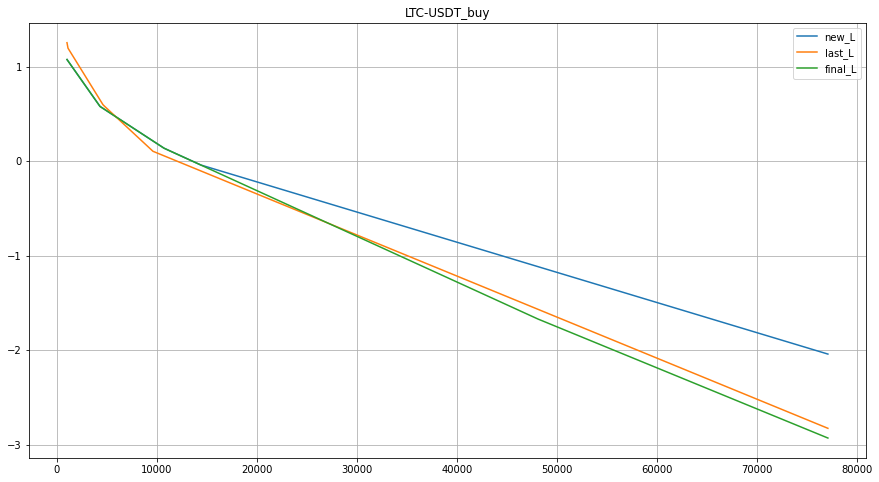

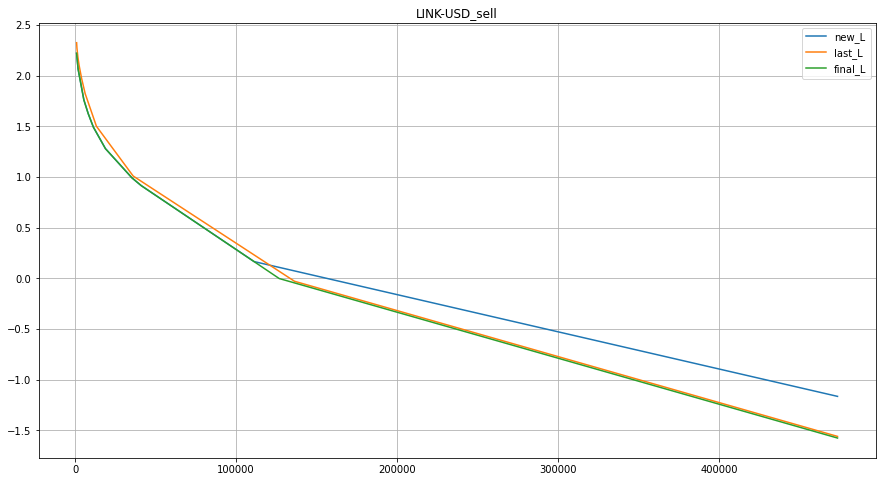

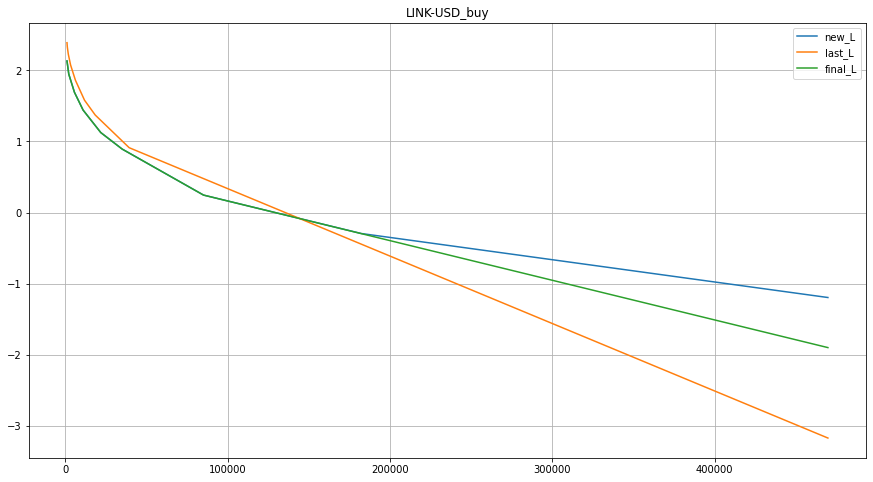

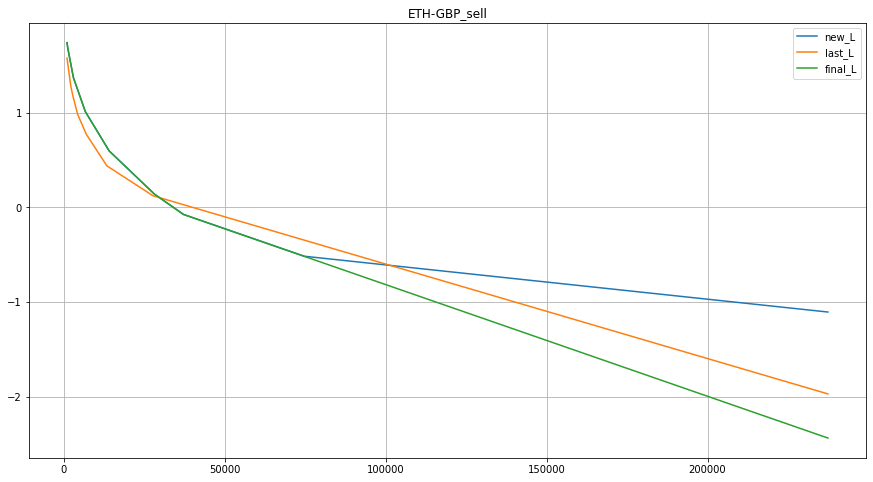

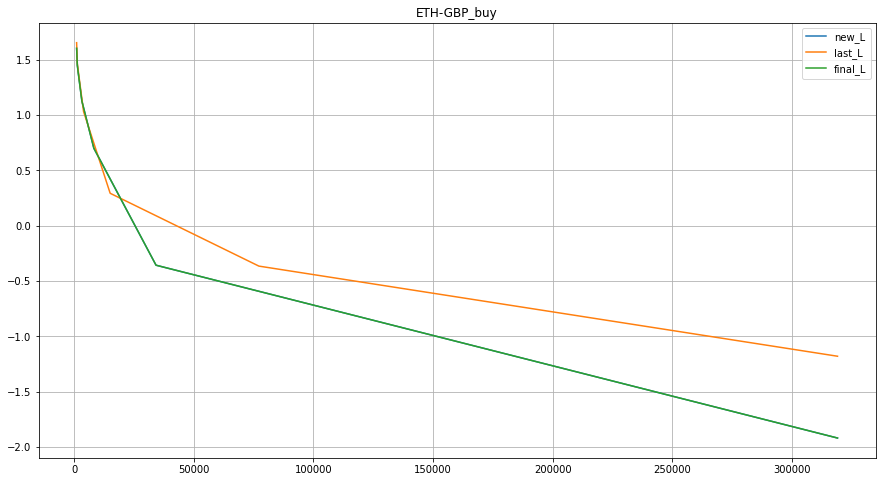

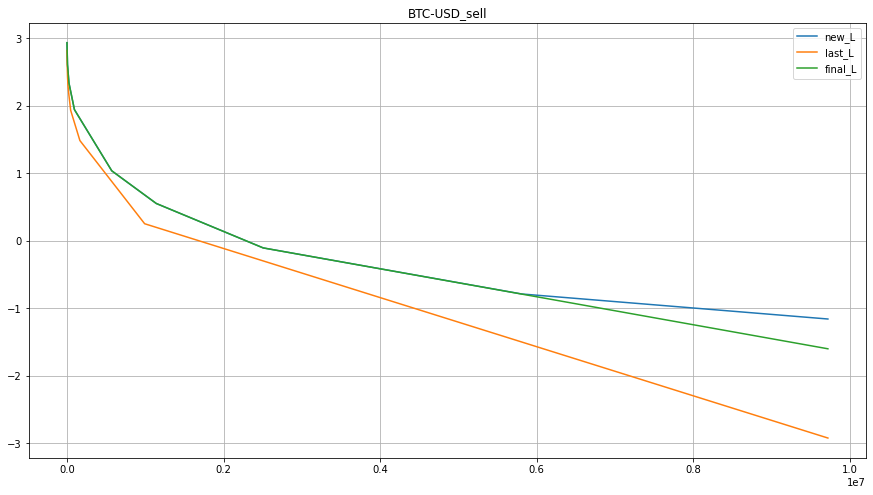

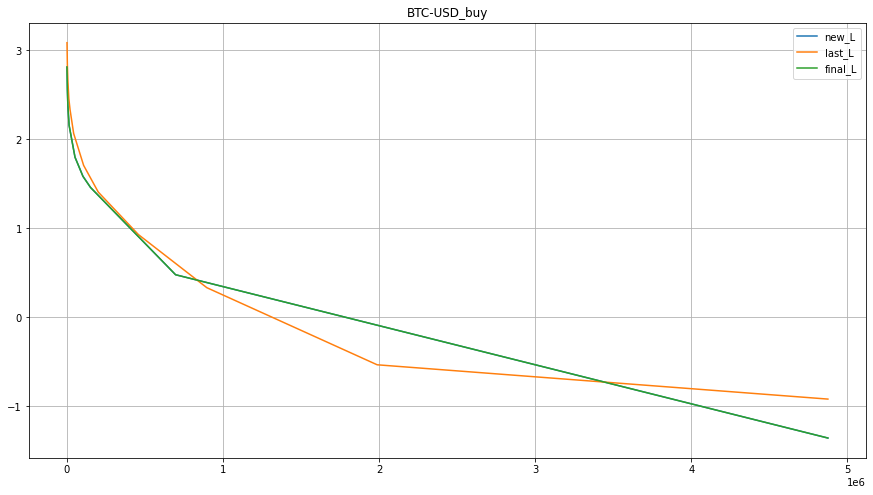

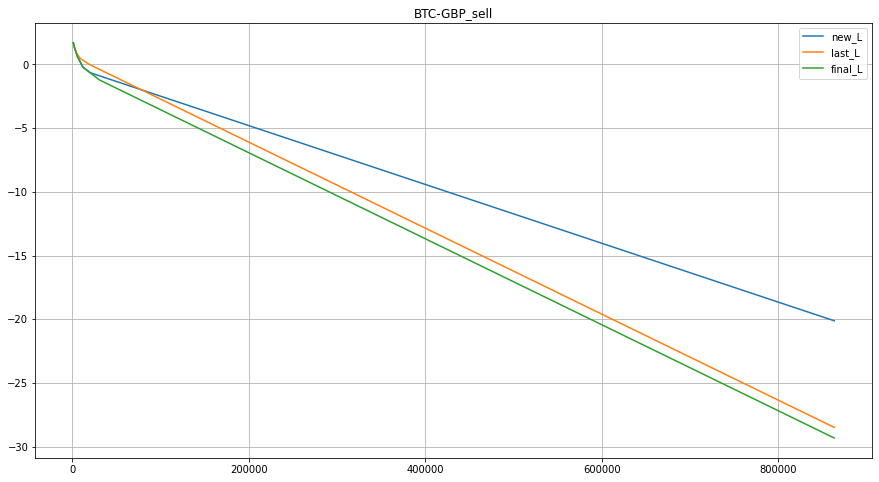

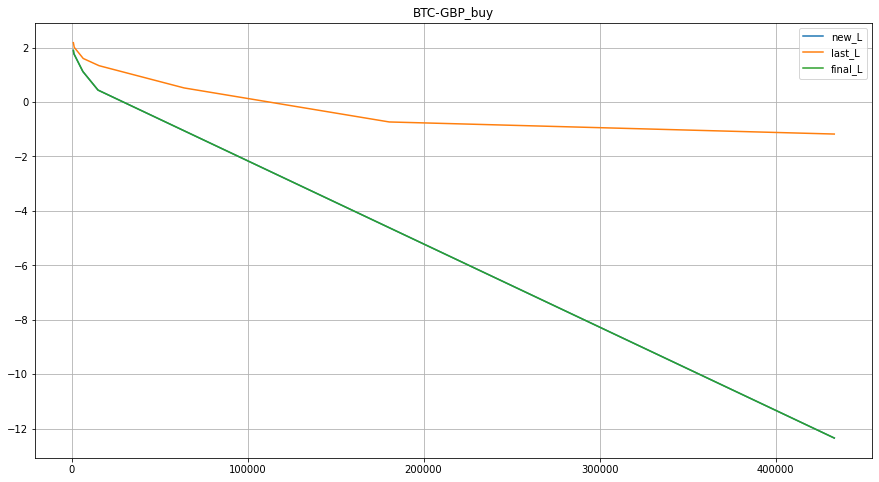

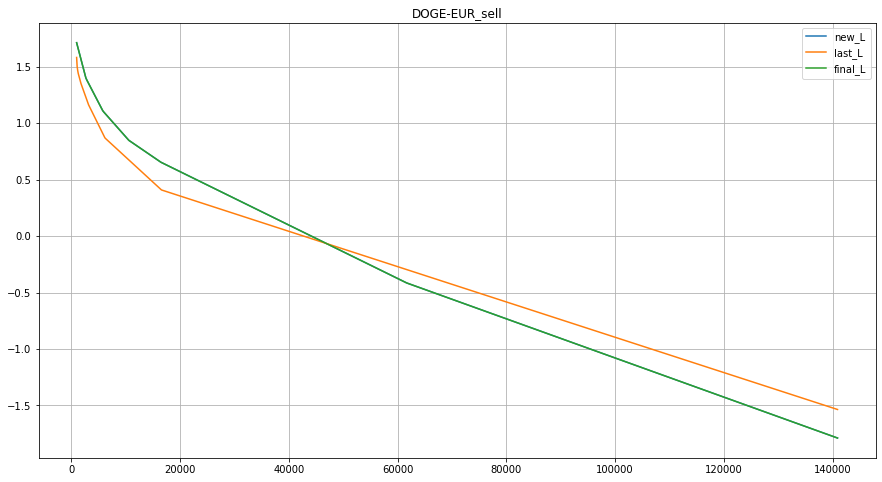

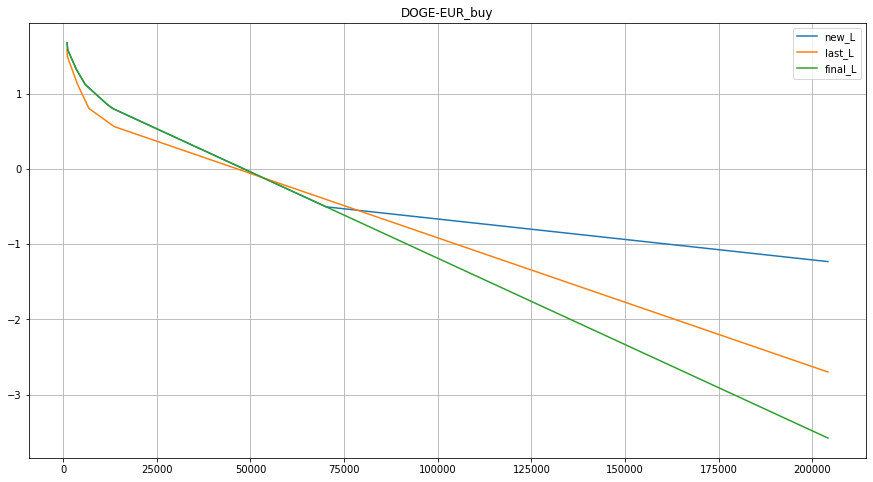

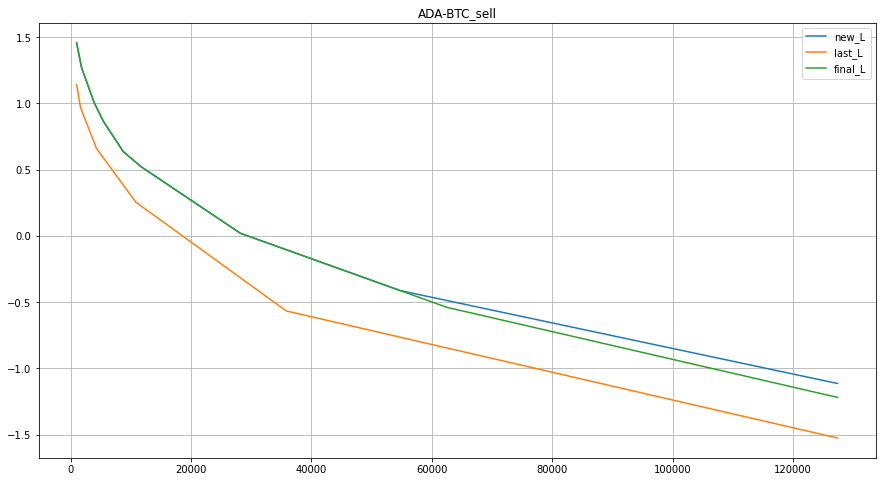

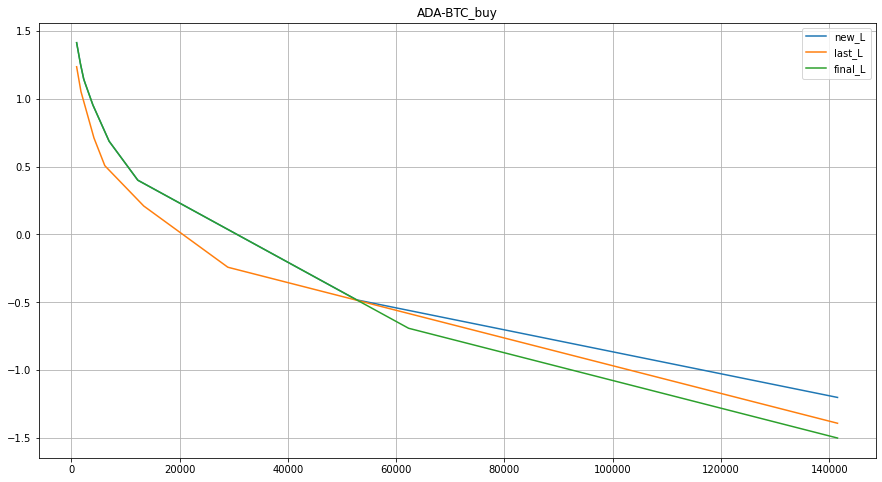

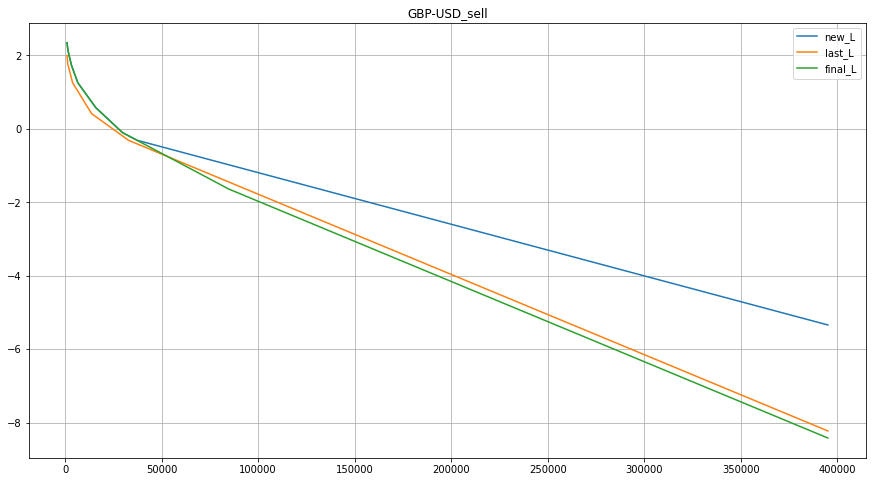

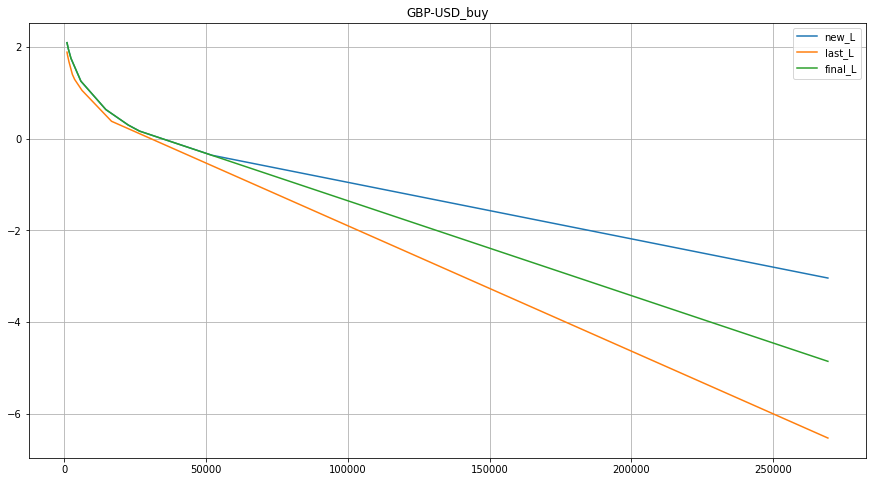

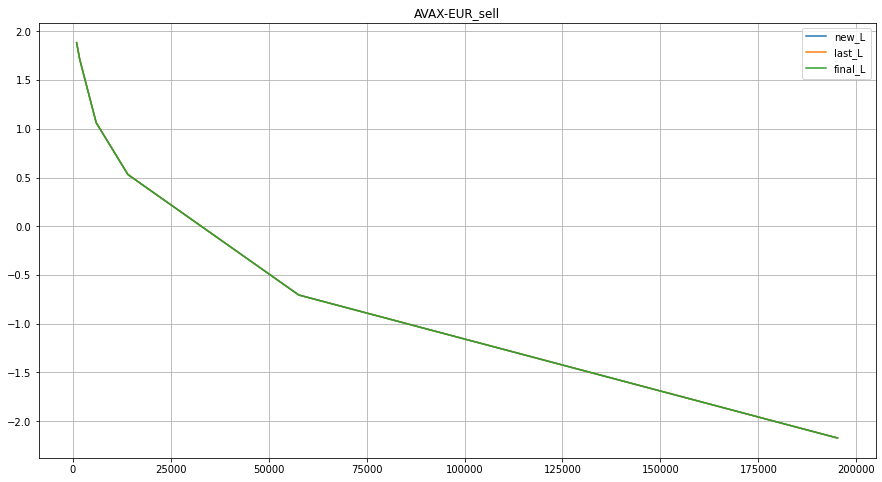

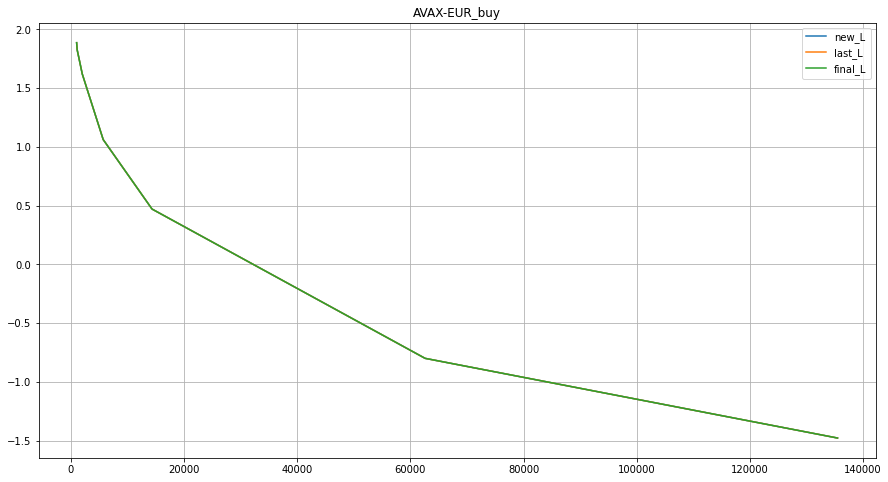

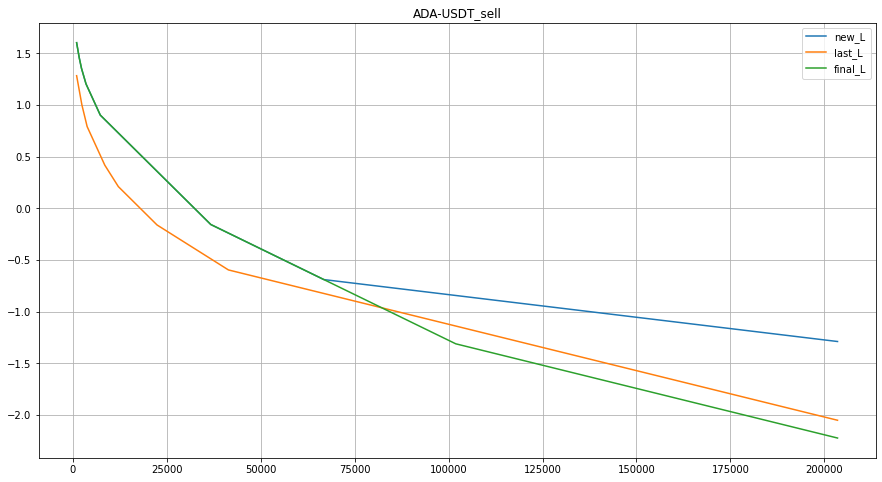

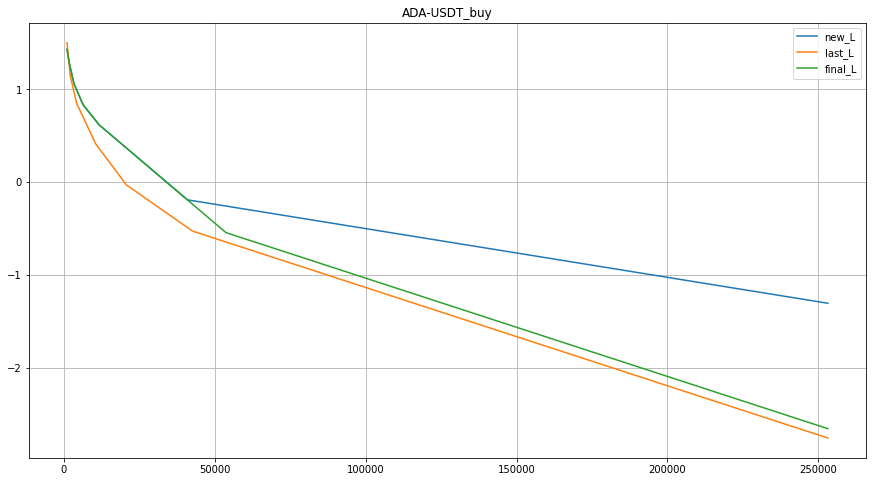

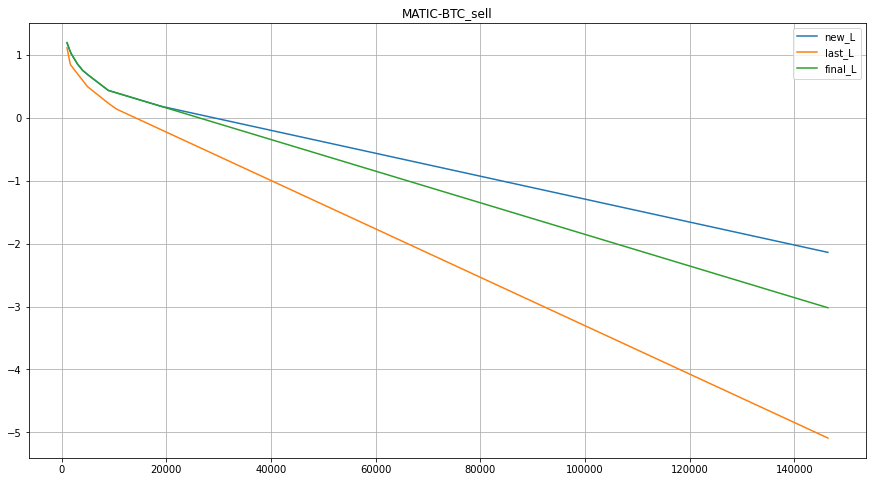

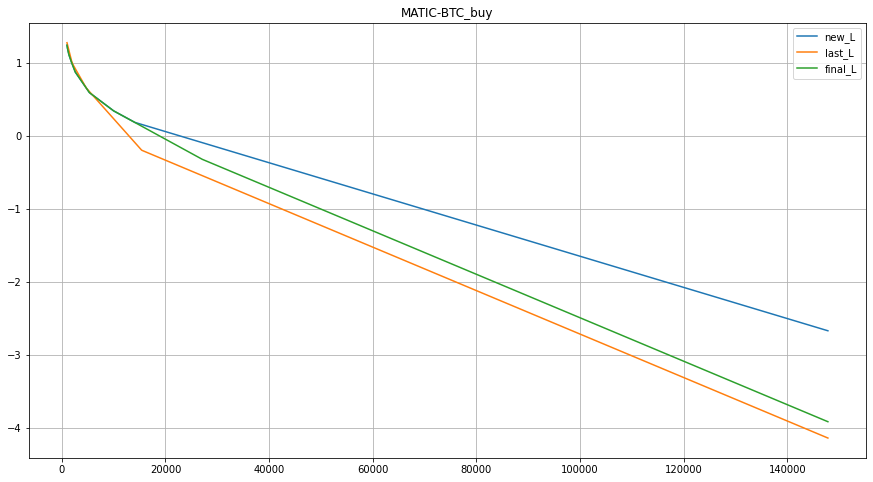

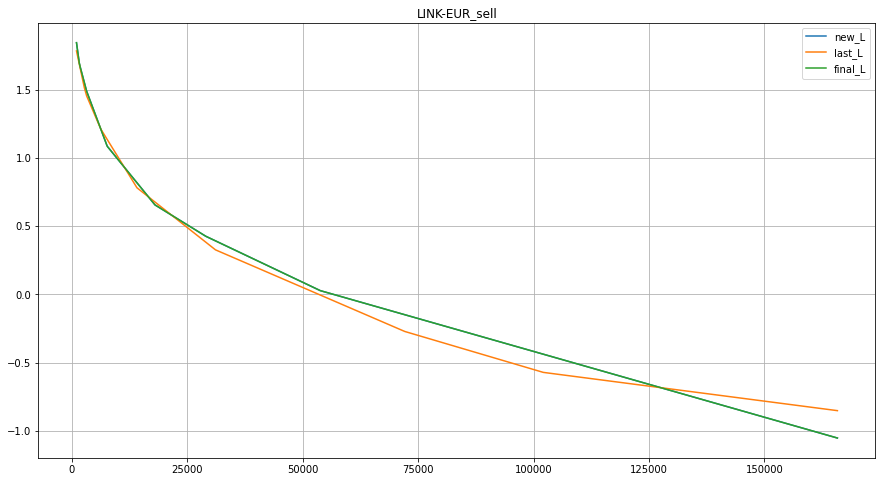

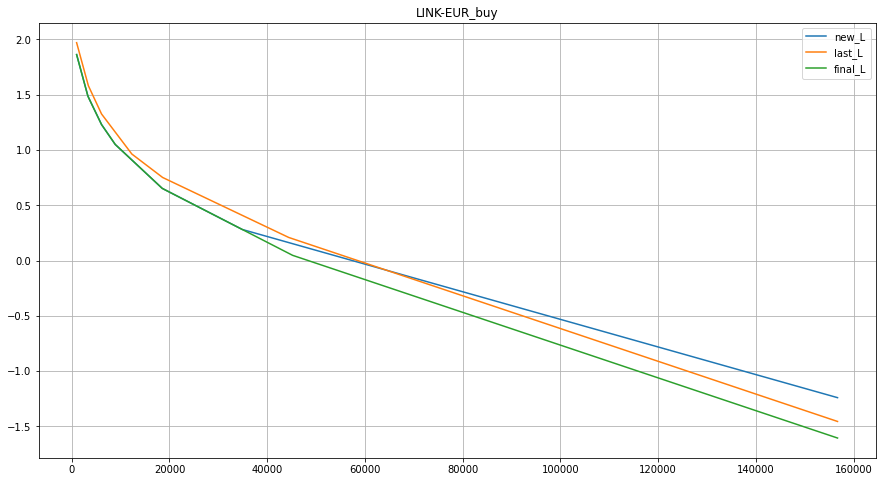

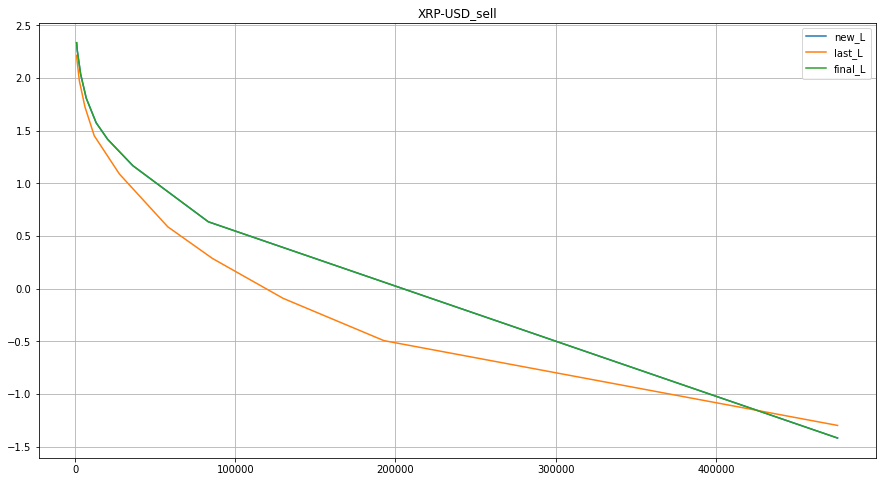

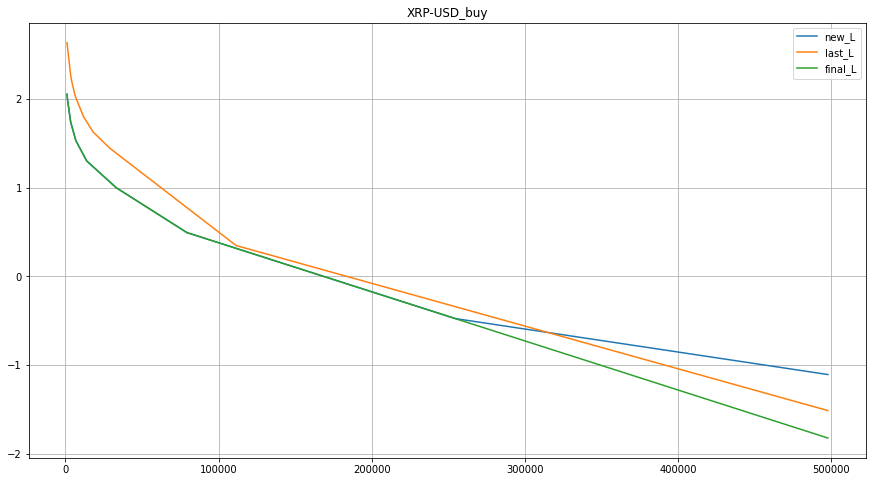

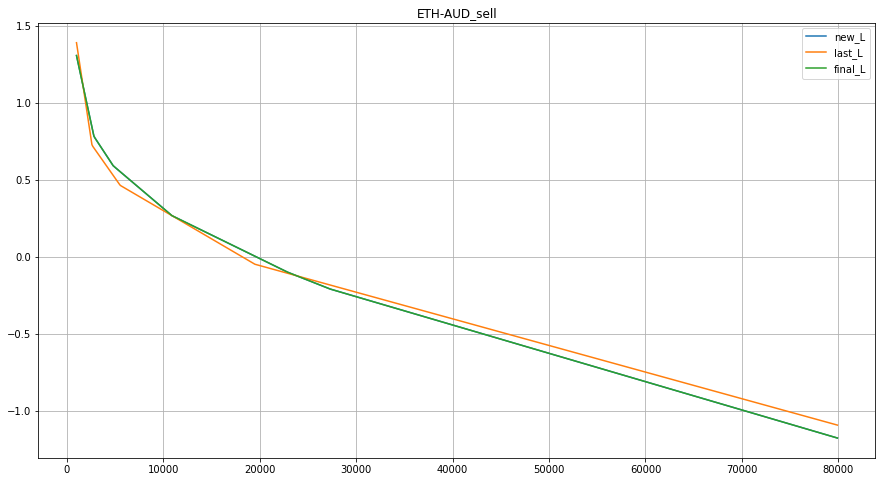

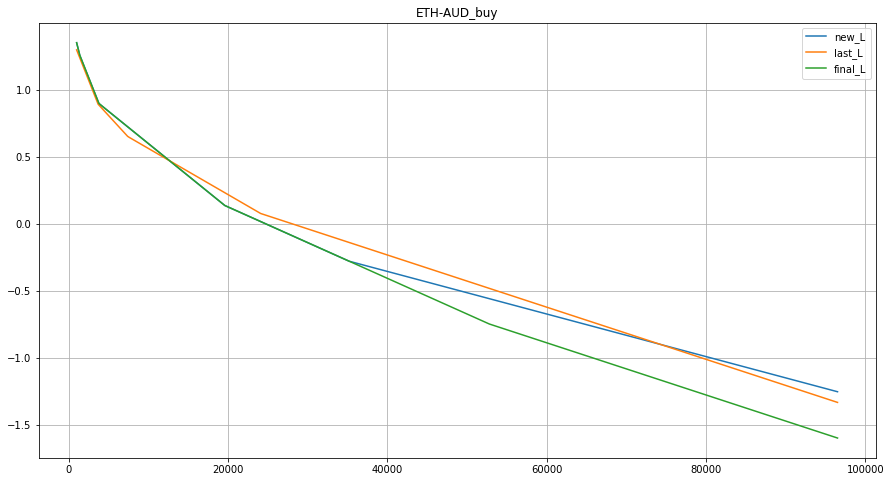

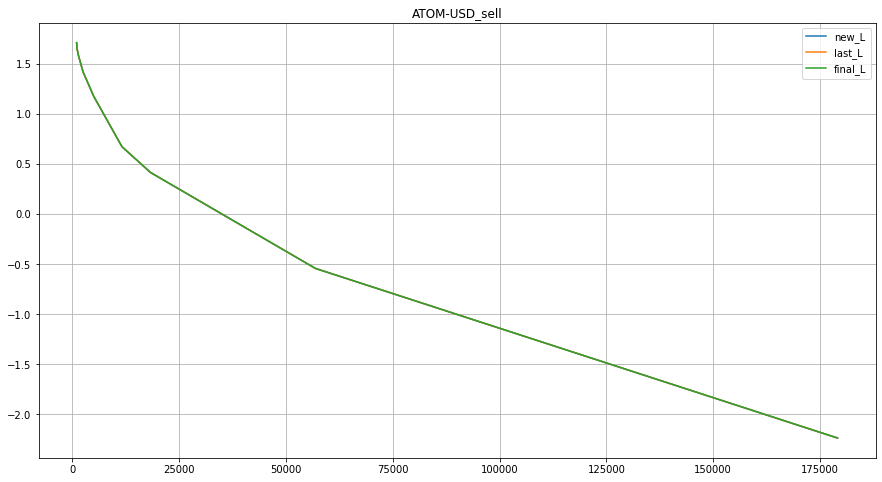

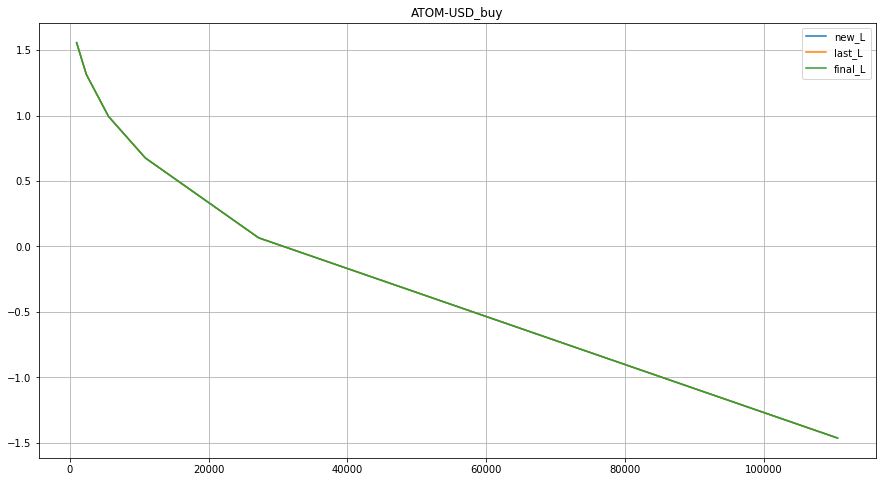

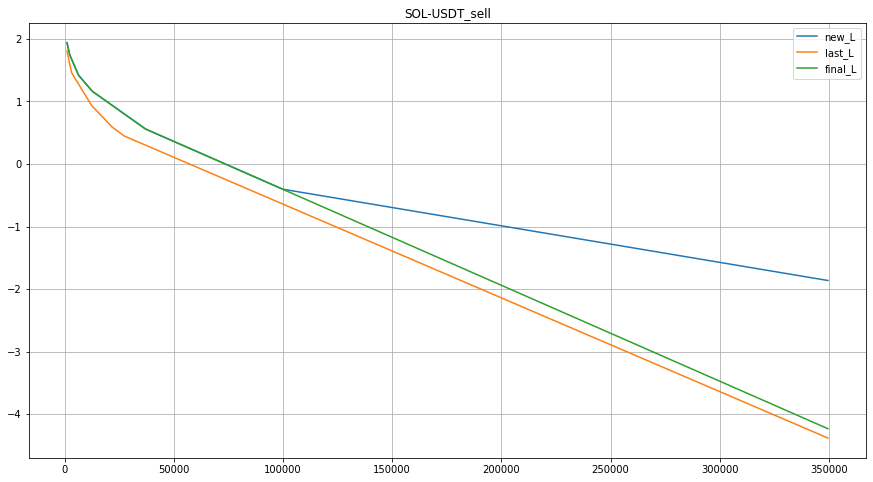

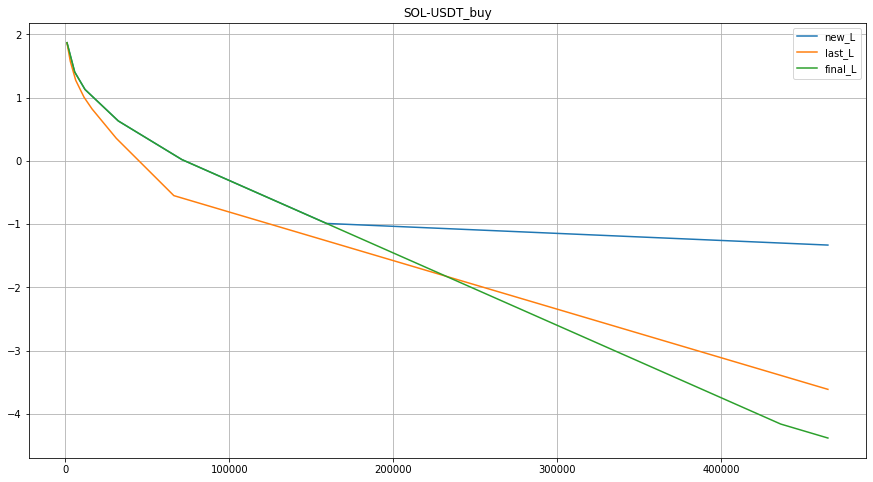

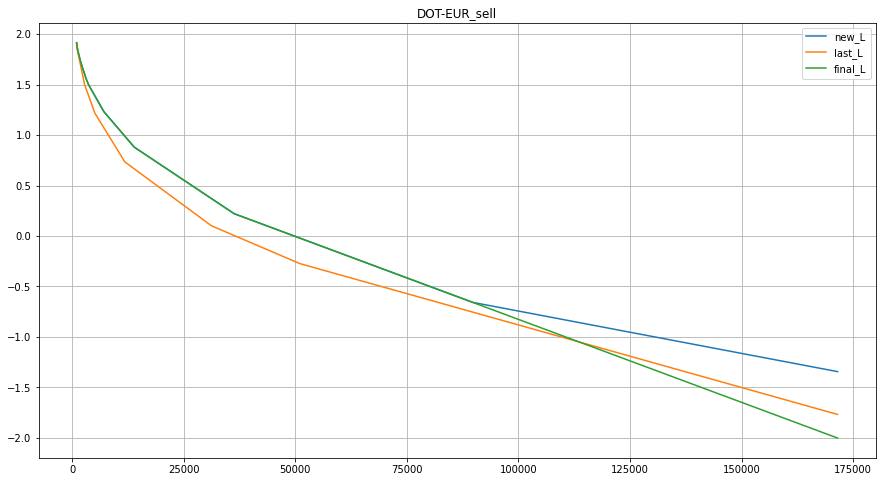

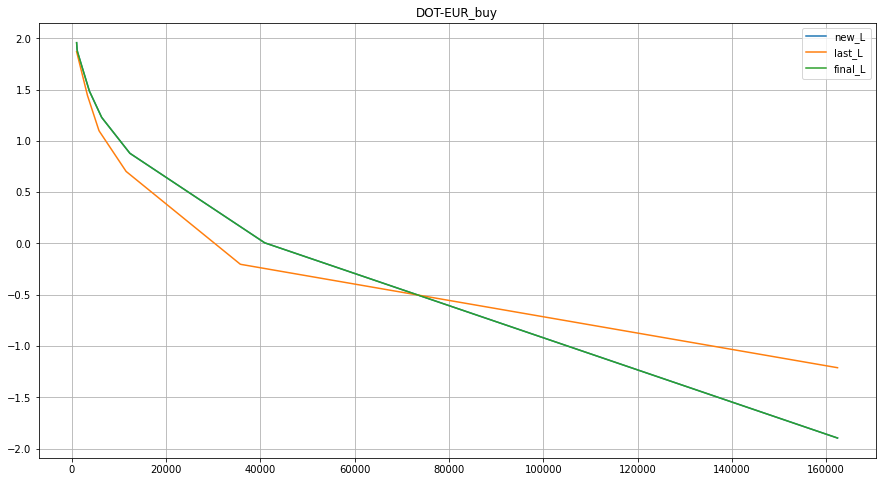

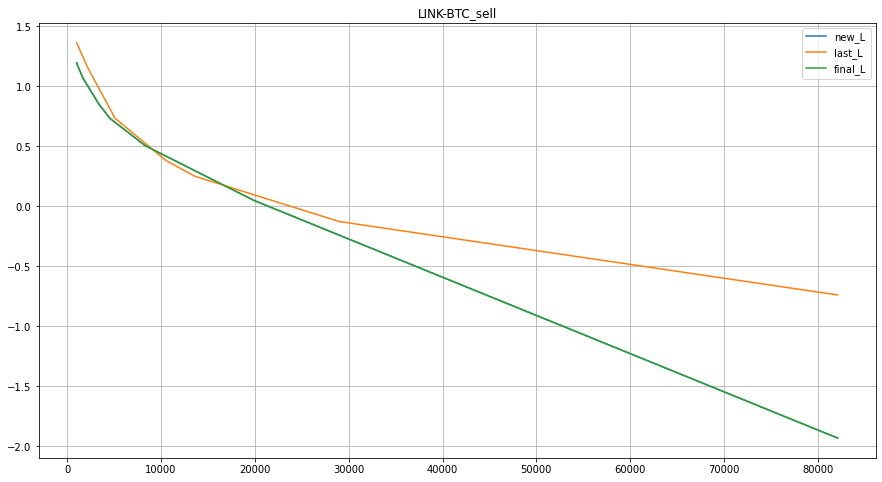

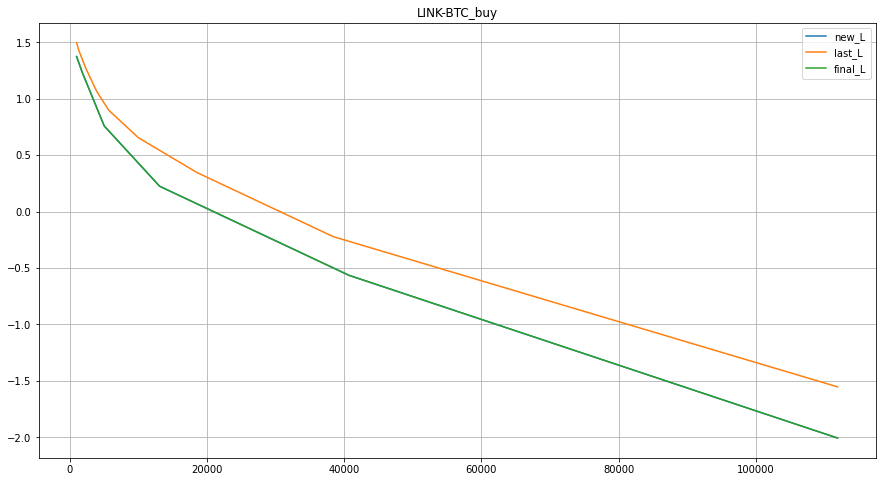

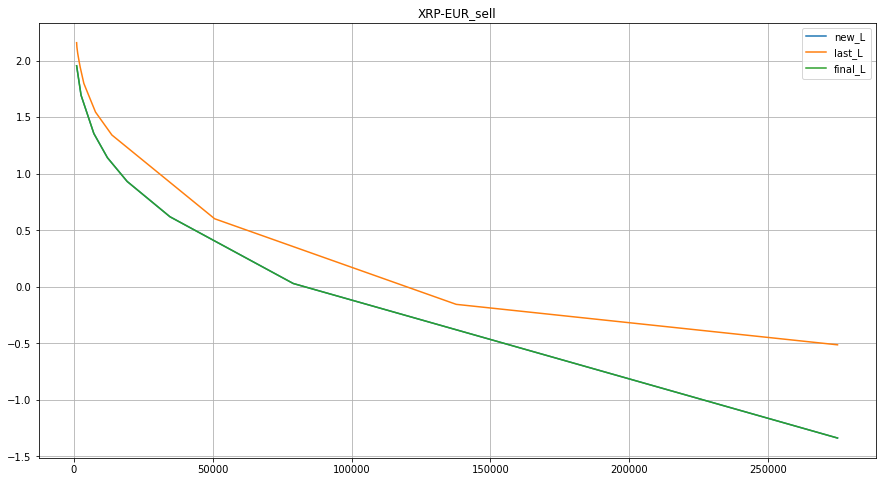

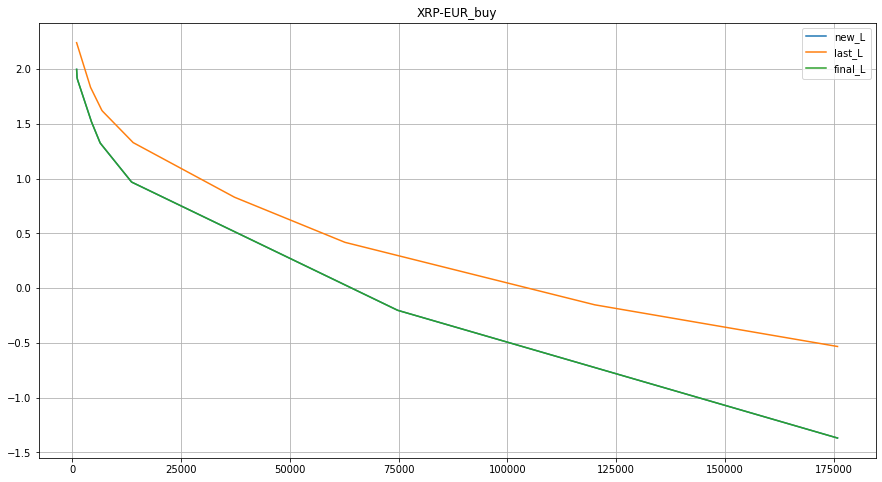

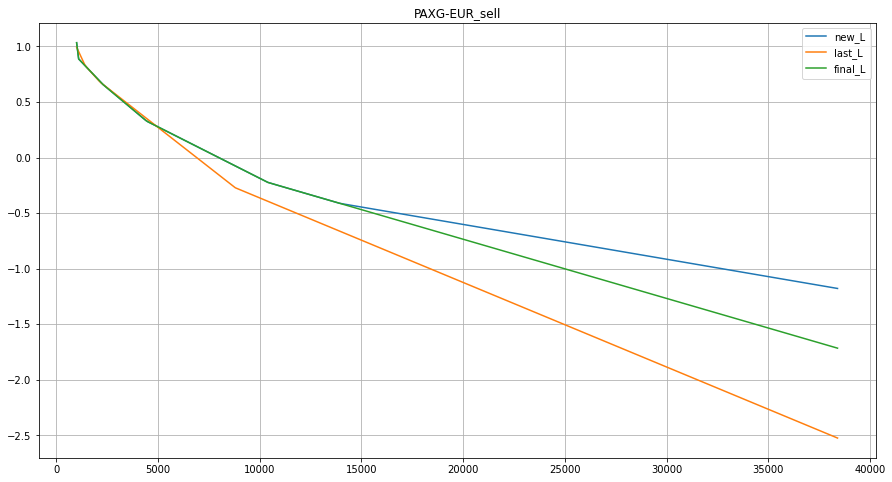

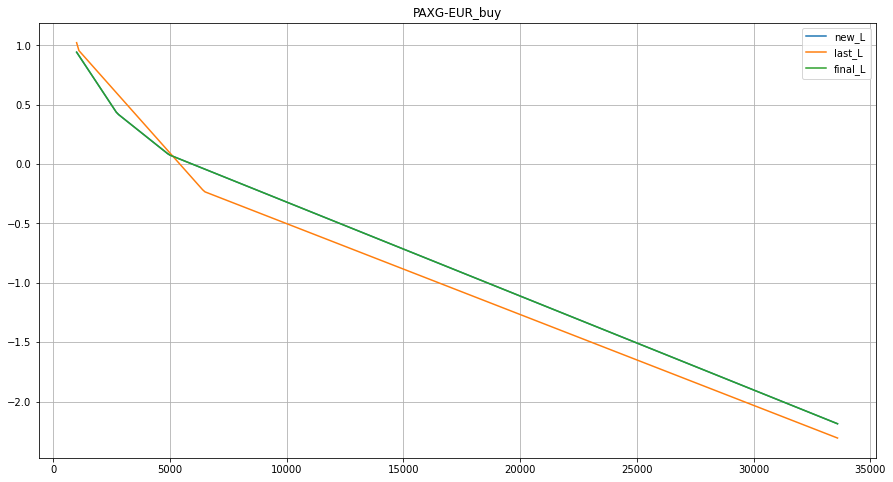

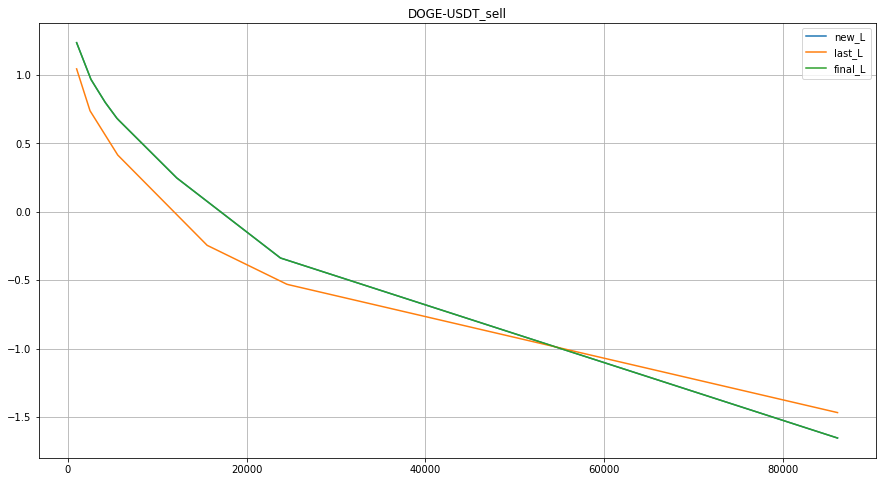

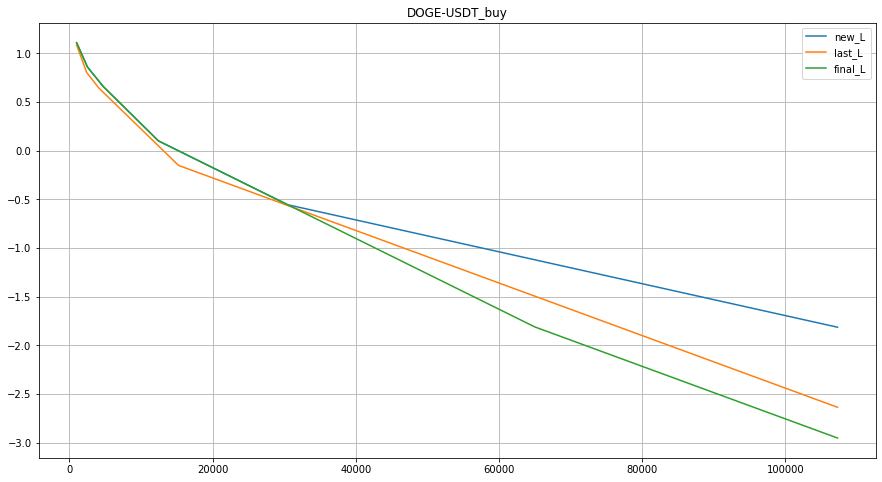

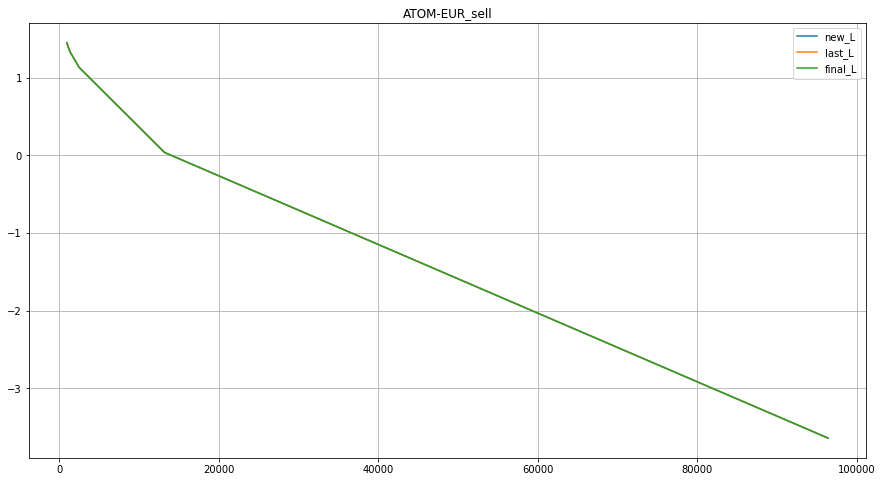

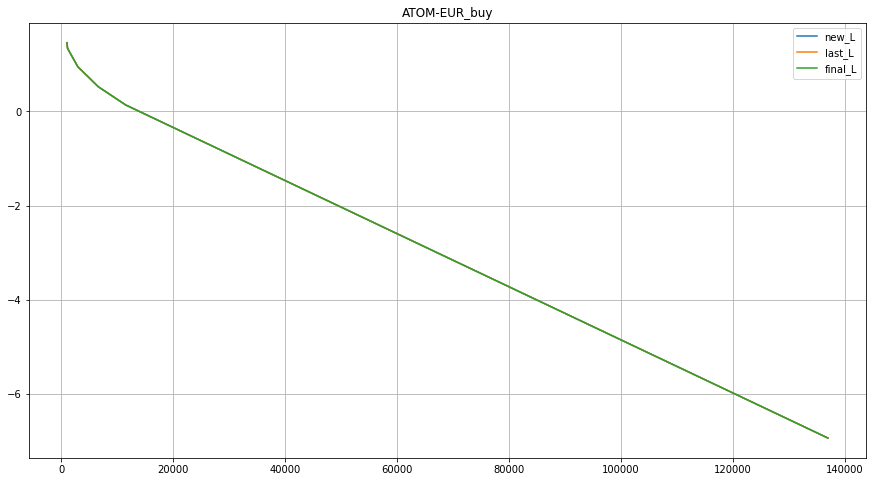

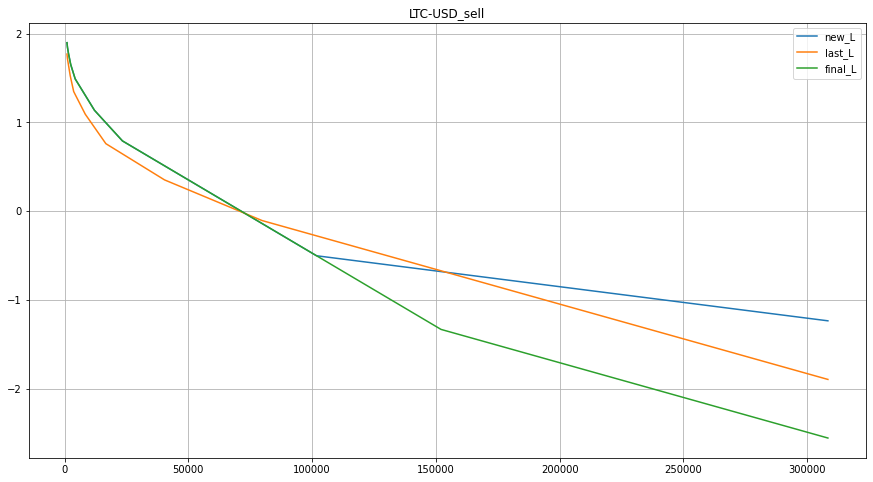

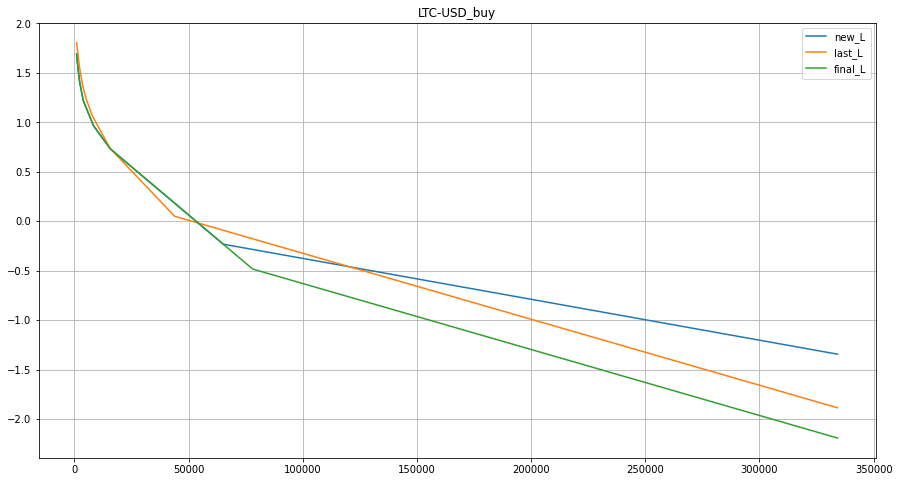

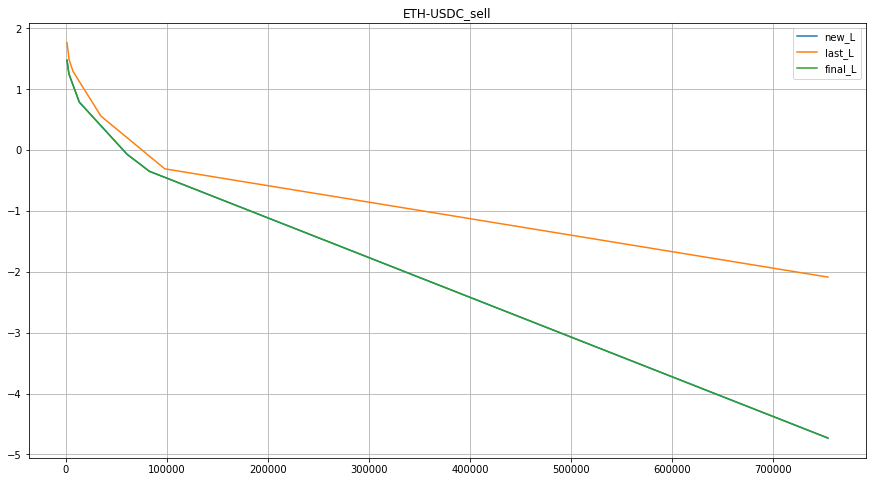

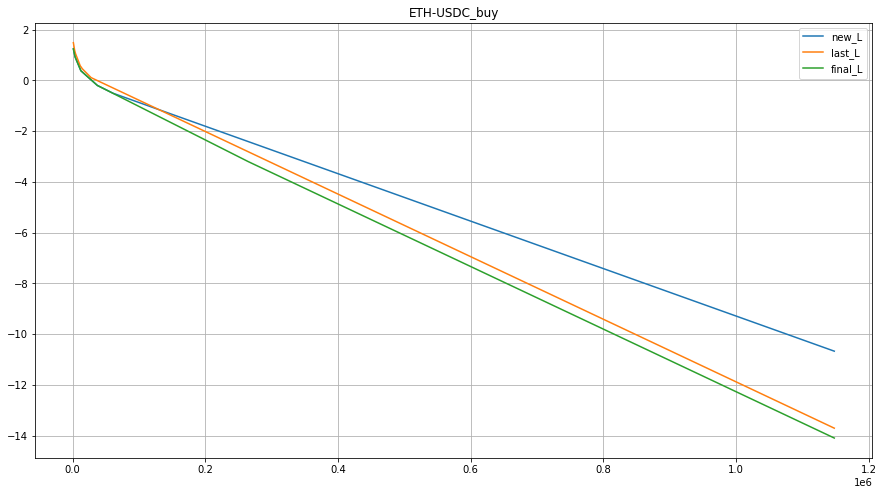

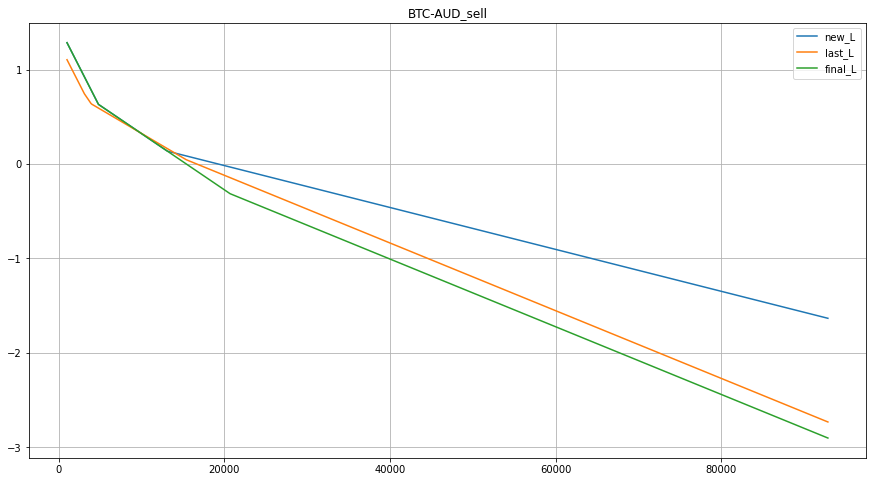

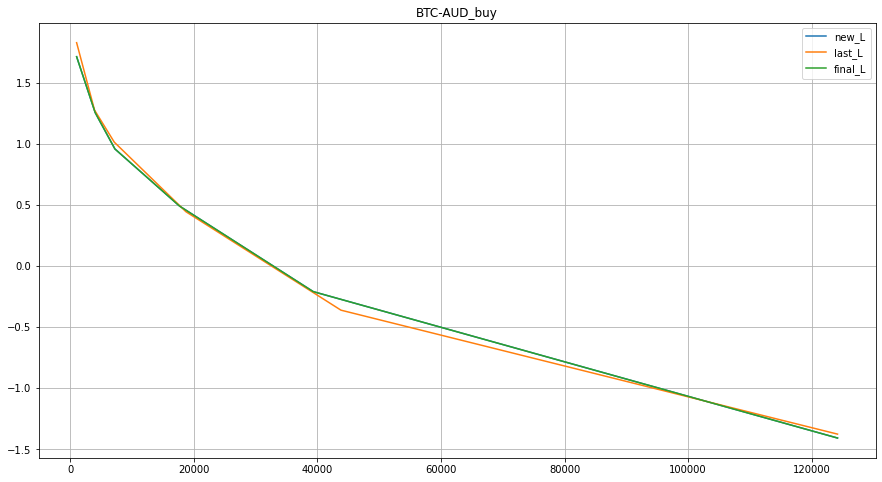

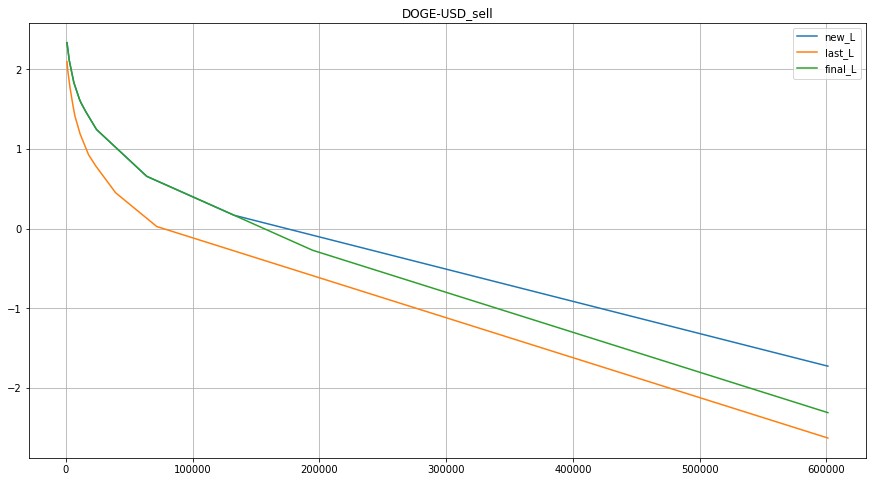

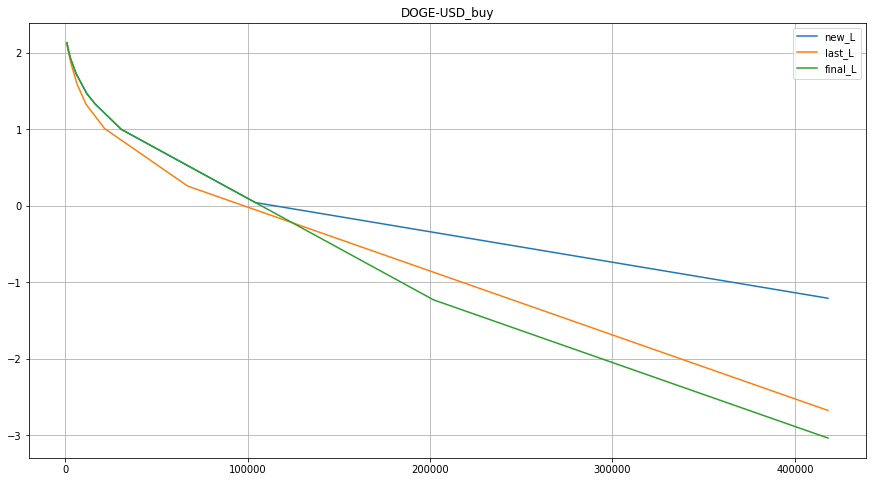

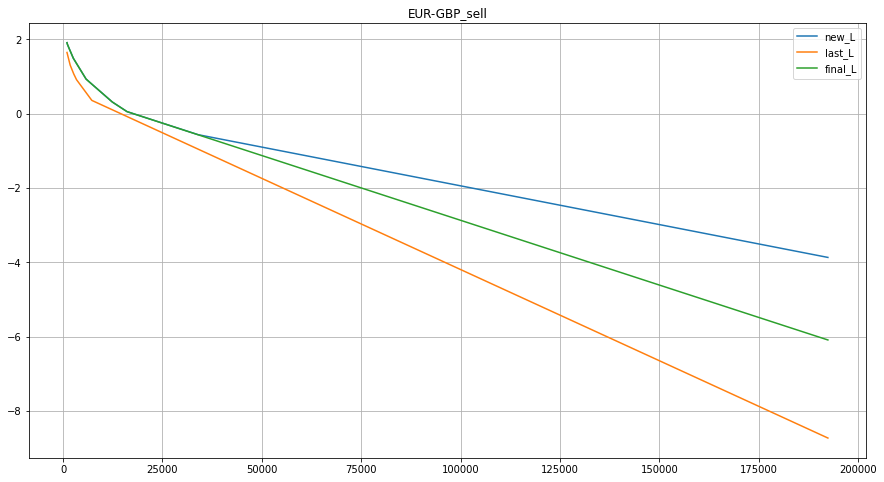

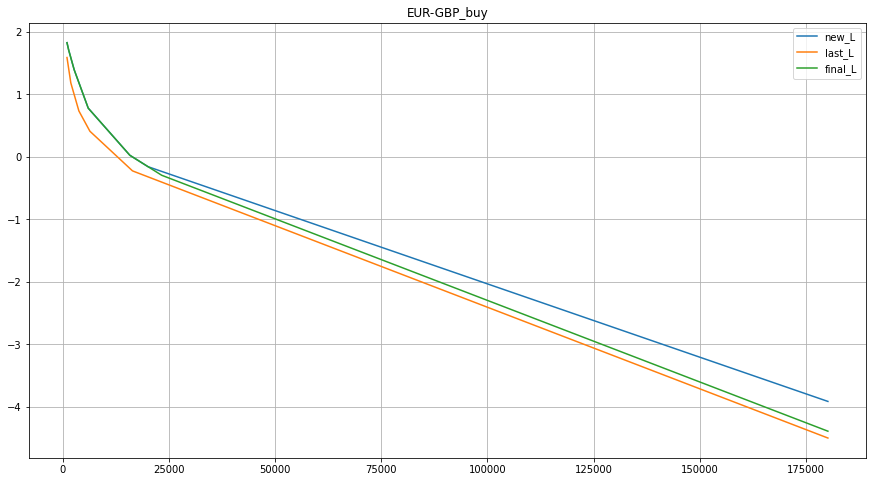

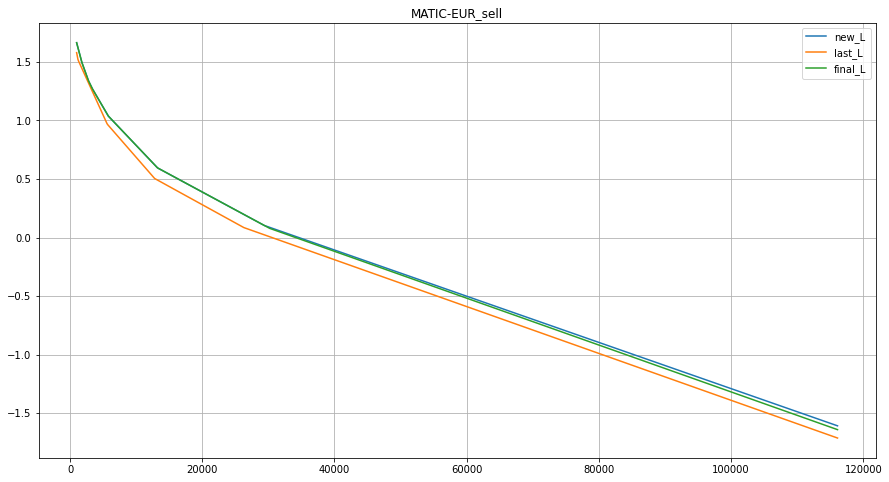

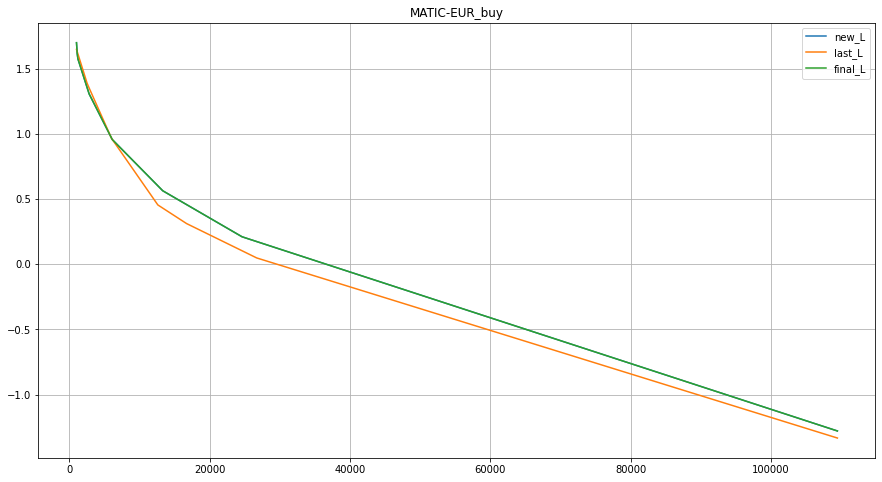

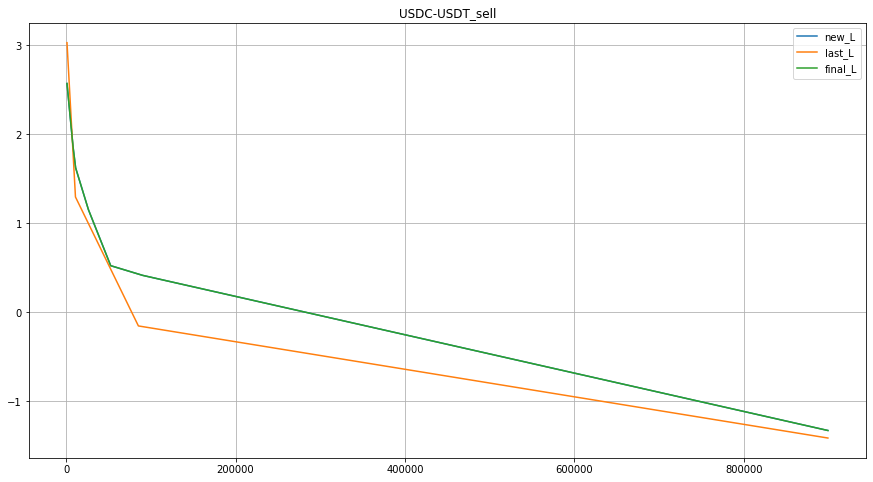

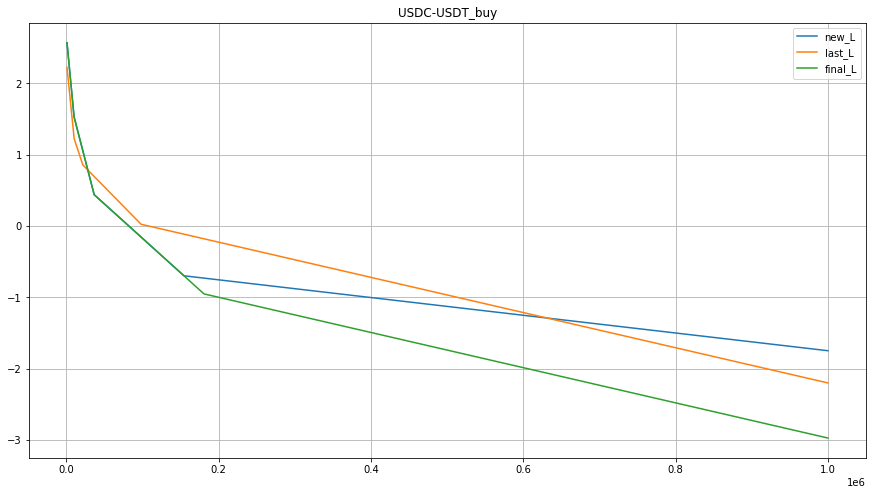

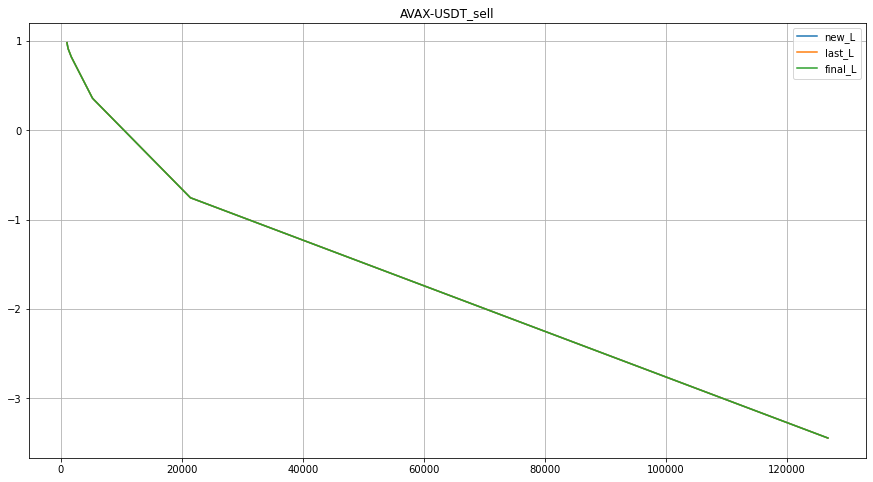

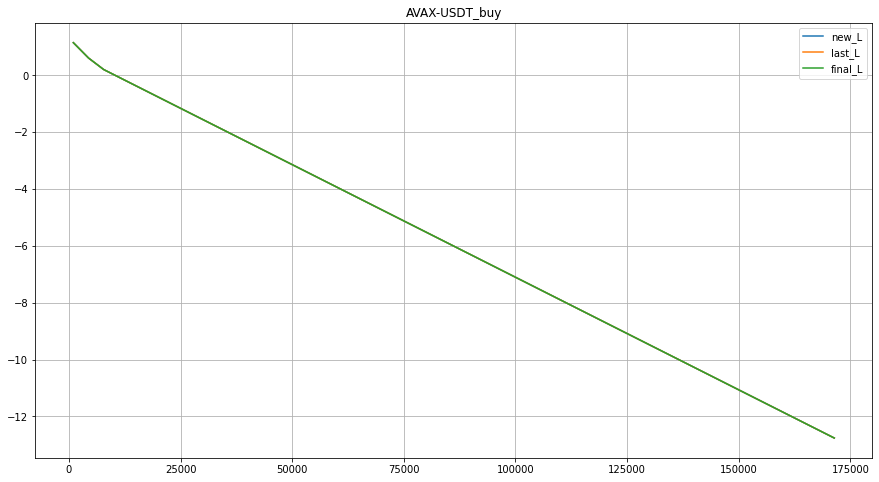

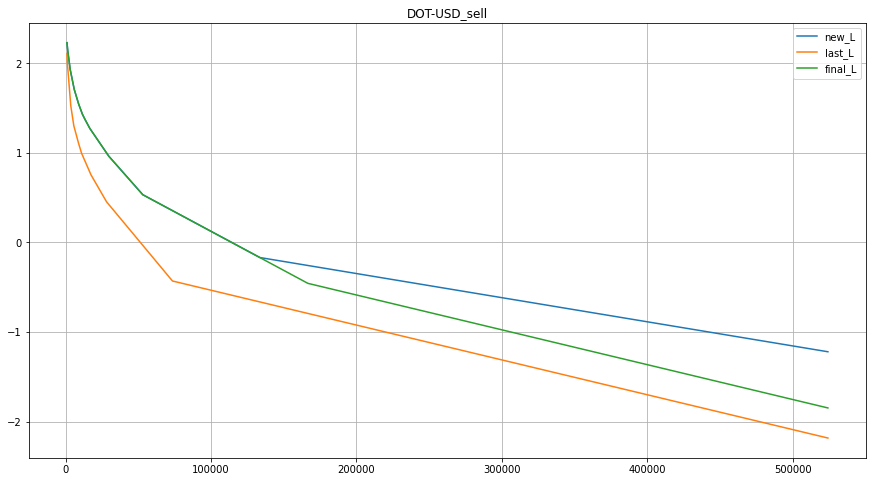

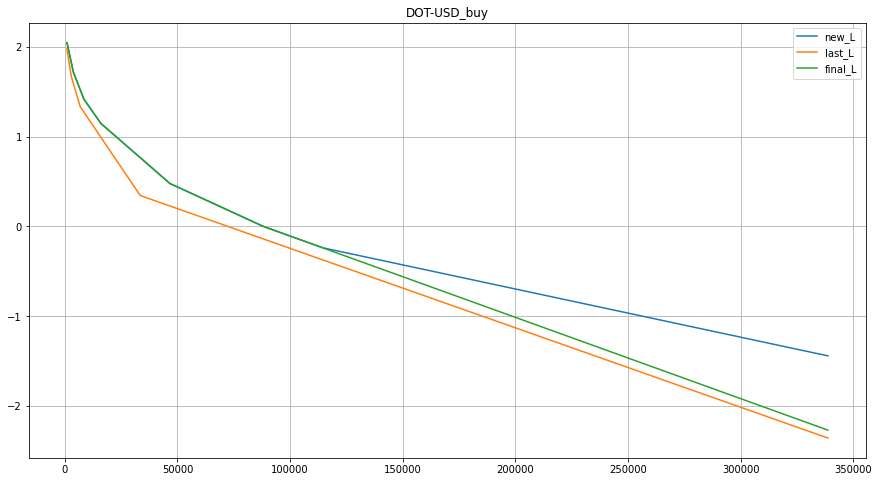

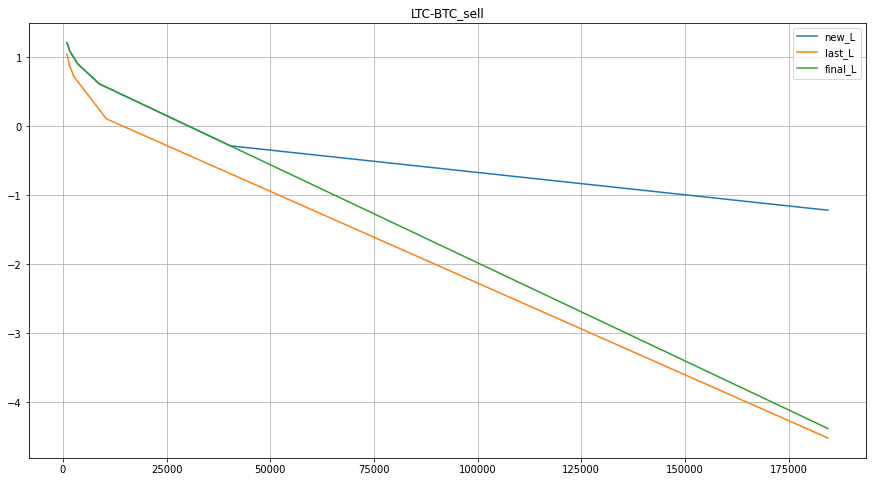

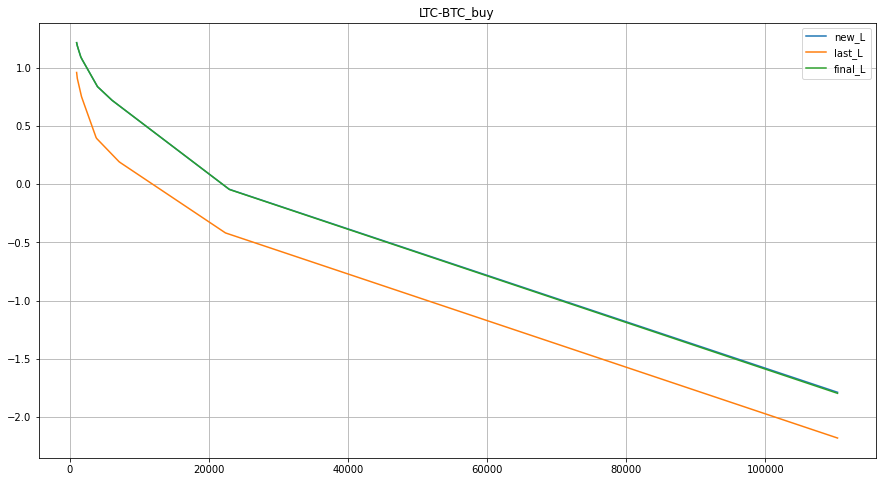

In [20]:
for coin in os.listdir(f'Y:/Trade Pro/data_wei/kraken/trade'):
    for side in ['sell', 'buy']:
        rejust(coin, side)

In [4]:
for coin in os.listdir(f'Y:/Trade Pro/data_wei/kraken/trade'):
    for side in ['sell', 'buy']:
        coin = coin.replace('XBT', 'BTC').replace('XDG', 'DOGE')
        p3 = pd.read_csv(f'C:/Users/杜威/Desktop/tardis/kraken/p3/{coin}_{side}.csv')
        p3[['a', 'b']].to_csv(f'C:/Users/杜威/Desktop/tardis/kraken/p3/{coin}_{side}.csv')